In [1]:
# Load packages
from datetime import datetime
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scipy
import sys

In [2]:
# declare universal variables
CONDITION = 'fgr'
CONDITION_CLINICAL_DF = 'FGR'
SUFFIX = ' (protein)'

In [3]:
# Set up logger
os.remove('spearman.standardized.interomics.min.power.' + CONDITION + '.pairs.all.miniDP3.log')
logger = logging.getLogger('analytics')

# Set the logging level
logger.setLevel(logging.INFO)

# Define a log format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Create a console handler to output log messages to the console
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

# (Optional) Create a file handler to log messages to a file
file_handler = logging.FileHandler('spearman.standardized.interomics.min.power.' + CONDITION + '.pairs.all.miniDP3.log')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [4]:
dfpb = pd.read_table('../../data/proteins-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfmb = pd.read_table('../../data/metabolites-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfmirna = pd.read_table('../../data/mirna-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dftb = pd.read_table('../../data/transcripts-final-adjusted.csv', sep=',', dtype={'Patient-ID':str})
dfph = pd.read_table('../../data/PlacentalHistopathologyReportsCleaned.csv', sep=',', dtype={'Patient-ID':str})
dfph2 = pd.read_table('../../data/PlacentalHistopathologySlideFeaturesCleaned.csv', sep=',', dtype={'Patient-ID':str})

dfp_analyte = pd.read_table('../../data/protein-meta-final.csv', sep=',')
dfm_analyte = pd.read_table('../../data/metabolites-meta-final.csv', sep=',')
dfmirna_analyte = pd.read_table('../../data/mirna-meta-final.csv', sep=',')
dft_analyte = pd.read_table('../../data/transcripts-meta-final.csv', sep=',')

df_clinical = pd.read_table('../../data/metadata-final.csv', sep=',', dtype={'Study_ID/ID':str})
df_clinical = df_clinical[df_clinical['Condition']==CONDITION_CLINICAL_DF]

In [5]:
dfpb.shape, dfmb.shape, dfmirna.shape, dftb.shape, dfph.shape, dfph2.shape, df_clinical.shape

((321, 352), (319, 866), (294, 450), (294, 9585), (275, 6), (348, 9), (40, 21))

# Set up annotations

In [6]:
metabolites = {}
for index, row in dfm_analyte.iterrows():
    metabolites[row['CHEMICAL_NAME']] = {'name': row['CHEMICAL_NAME'], 'sub_group': row['SUB_PATHWAY'], 'super_group': row['SUPER_PATHWAY']}
    
miRNAs = {}
for index, row in dfmirna_analyte.iterrows():
    miRNAs[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
    
proteins = {}
for index, row in dfp_analyte.iterrows():
    proteins[row['Assay'] + SUFFIX] = {'name': row['Assay'], 'sub_group': None, 'super_group': row['Panel']}
    
transcripts = {}
for index, row in dft_analyte.iterrows():
    transcripts[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
    
histopathology = {}
for item in dfph:
    if item != 'Patient-ID':
        histopathology[item] = {'name': item, 'sub_group': None, 'super_group': None}
for item in dfph2:
    if item != 'Patient-ID':
        histopathology[item] = {'name': item, 'sub_group': None, 'super_group': None}
        
# print the number of included analytes
print('Histopathology Features:', str(len(histopathology)))
print('Metabolites:', str(len(metabolites)))
print('miRNAs:', str(len(miRNAs)))
print('Proteins:', str(len(proteins)))
print('Transcripts:', str(len(transcripts)))
print('Total:', str(len(histopathology)+len(metabolites)+len(miRNAs)+len(proteins)+len(transcripts)))

Histopathology Features: 13
Metabolites: 1032
miRNAs: 2414
Proteins: 452
Transcripts: 51174
Total: 55085


# Merge against prot/met data

In [7]:
dfm_analyte = list(set(metabolites.keys()).intersection(dfmb.columns))
dfmirna_analyte = list(set(miRNAs.keys()).intersection(dfmirna.columns))
dfp_analyte = list(set(proteins.keys()).intersection(dfpb.columns))
dft_analyte = list(set(transcripts.keys()).intersection(dftb.columns))
dfph_measurement = ['MVM', 'FVM', 'AI', 'CI', 'Placental Abnormality']
dfph_measurement2 = ['DVH', 'AVM', 'Syncytial Knots', 'Segmental Avascular Villi', 'DVM', 'Villitis of Unknown Etiology', 'Diffuse Villous Edema', 'Chorangiosis']

# Get all analytes together
analytes = dfph_measurement + dfph_measurement2 + dfm_analyte + dfmirna_analyte + dfp_analyte + dft_analyte

# print the number of included analytes that pass missingness threshold
print('Histopathology Features:', str(len(dfph_measurement)+len(dfph_measurement2)))
print('Metabolites:', str(len(dfm_analyte)))
print('miRNAs:', str(len(dfmirna_analyte)))
print('Proteins:', str(len(dfp_analyte)))
print('Transcripts:', str(len(dft_analyte)))
print('Total:', str(len(analytes)))

Histopathology Features: 13
Metabolites: 865
miRNAs: 448
Proteins: 343
Transcripts: 9582
Total: 11251


In [8]:
df_clinical.head()

Patient-ID Condition  LaborInitiation  MaternalAge  isWhite  isBlack   
4     MJ-0006       FGR                0         32.0      1.0      0.0  \
9     MJ-0036       FGR                0         25.0      1.0      0.0   
10    MJ-0042       FGR                0         30.0      1.0      0.0   
12    MJ-0045       FGR                1         32.0      1.0      0.0   
13    MJ-0053       FGR                0         23.0      0.0      1.0   

    isAsian  Ethnicity    WksGest  PregravidBMI  ...  Para  LaborOnset   
4       0.0        0.0  38.000000     16.264000  ...   0.0         1.0  \
9       0.0        0.0  37.000000     21.333333  ...   0.0         1.0   
10      0.0        0.0  38.000000     21.295295  ...   1.0         1.0   
12      0.0       -1.0  39.000000     26.673324  ...   0.0         0.0   
13      0.0        0.0  36.285714     29.752066  ...   0.0         0.0   

    Smoker  IllicitDrugUser  DeliveryMethod  PregnancyRelatedHypertension   
4      0.0              0.0             0.0                             0  \
9      0.0              0.0             0.0                             0   
10     1.0              0.0             0.0                             0   
12     0.0              0.0             1.0                             1   
13     0.0              0.0             1.0                             0   

    FetalGrowthRestriction  Preeclampsia  InfSex  Birthweight  
4                        1             0     1.0       2295.0  
9                        1             0     0.0       1675.0  
10                       1             0     0.0       2245.0  
12                       1             0     1.0       2518.0  
13                       1             0     1.0       1510.0  

[5 rows x 21 columns]

In [9]:
df = df_clinical.merge(dfph[['Patient-ID'] + list(dfph_measurement)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfph2[['Patient-ID'] + list(dfph_measurement2)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfpb[['Patient-ID'] + list(dfp_analyte)], on=['Patient-ID'], how='inner')
print(df.shape)
df = df.merge(dfmb[['Patient-ID'] + list(dfm_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dfmirna[['Patient-ID'] + list(dfmirna_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.merge(dftb[['Patient-ID'] + list(dft_analyte)], on=['Patient-ID'], how='left')
print(df.shape)
df = df.fillna(-1)

(40, 26)
(40, 34)
(36, 377)
(36, 1242)
(36, 1690)
(36, 11272)


In [10]:
df.shape, dfpb.shape, dfmb.shape, dfmirna.shape, dftb.shape, dfph.shape, dfph2.shape, df_clinical.shape

((36, 11272),
 (321, 352),
 (319, 866),
 (294, 450),
 (294, 9585),
 (275, 6),
 (348, 9),
 (40, 21))

In [11]:
# Select a random subset of rows
np.random.seed(123)
num_rows_to_select = 30  # Set to smallest sample size
df = df.sample(n=num_rows_to_select)

In [12]:
df.shape

(30, 11272)

In [13]:
df['InfSex'].value_counts()

InfSex
0.0    17
1.0    13
Name: count, dtype: int64

In [14]:
df['isWhite'].value_counts()

isWhite
1.0    21
0.0     9
Name: count, dtype: int64

In [15]:
df['isBlack'].value_counts()

isBlack
0.0    23
1.0     7
Name: count, dtype: int64

In [16]:
df['isAsian'].value_counts()

isAsian
0.0    28
1.0     2
Name: count, dtype: int64

In [17]:
df.head()

Patient-ID Condition  LaborInitiation  MaternalAge  isWhite  isBlack   
6     MJ-0357       FGR                0         19.0      1.0      0.0  \
8     MJ-0433       FGR                0         15.0      0.0      1.0   
13    MJ-0788       FGR                1         29.0      0.0      1.0   
11    MJ-0715       FGR                1         30.0      0.0      1.0   
5     MJ-0286       FGR                0         43.0      1.0      0.0   

    isAsian  Ethnicity    WksGest  PregravidBMI  ...   ATF7  ZC3H18   
6       0.0        0.0  37.857143     26.402355  ...  677.0   712.0  \
8       0.0        0.0  36.142857     25.000000  ...  826.0   933.0   
13      0.0        0.0  40.285714     20.395421  ...  237.0   485.0   
11      0.0        0.0  37.285714     20.284799  ...  689.0   999.0   
5       0.0        0.0  39.285714     28.615442  ...  332.0   491.0   

     LINC00656  GTF3C4     PKM   MT-ND1    SDC3   TAF3  ANKDD1A  PLPBP  
6    65.180366   640.0  2933.0   9656.0   993.0  231.0    508.0  249.0  
8    63.274428   735.0  2910.0  12374.0   727.0  253.0    795.0  261.0  
13   63.272419   409.0  3107.0   2924.0   471.0  101.0    434.0  243.0  
11  173.151835   718.0  4282.0   8869.0   857.0  370.0    470.0  218.0  
5    58.383632   541.0  4746.0   4008.0  1171.0  154.0    180.0  256.0  

[5 rows x 11272 columns]

# Correlation network

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp
from statsmodels.genmod.families import family, links
import itertools

In [19]:
drop_cols = ['Patient-ID', 'Grav', 'DeliveryMethod', 
             'Para', 'PrePregWt_Kg', 'Ethnicity', 'isAsian', 
             'isBlack', 'WksGest', 'Condition', 'isWhite', 
             'Race', 'MaternalAge', 'Smoke', 'PregravidBMI',
             'HeightMeters']

# Pairwise GLM

In [20]:
def count_pairs(dat, analytes, proteins, metabolites, mirnas, transcripts, histopathology):

    # Create all possible pairs of inputs
    pairs = list(itertools.combinations(analytes, 2))
    logger.info('Created {} pairs'.format(len(pairs)))
         
    count = 0 
    done = 0
    skipped = 0
    completed = 0

    results = []
    columns = list(dat.columns)

    start_time = datetime.now()
    for (col1, col2) in pairs:

        if (col1 == col2):
            continue
                    
        if (col1 in histopathology.keys()) and (col2 in histopathology.keys()):
            continue
        
        if (col1 in metabolites.keys()) and (col2 in metabolites.keys()):
            continue
            
        if (col1 in mirnas.keys()) and (col2 in mirnas.keys()):
            continue

        if (col1 in proteins.keys()) and (col2 in proteins.keys()):
            continue
        
        if (col1 in transcripts.keys()) and (col2 in transcripts.keys()):
            continue
            
        if (col1 in proteins.keys()):
            name1 = proteins[col1]['name']
            subgroup1 = proteins[col1]['sub_group'] 
            supergroup1 = proteins[col1]['super_group']
            type1 = 'protein'
        elif (col1 in metabolites.keys()):
            name1 = metabolites[col1]['name']
            subgroup1 = metabolites[col1]['sub_group'] 
            supergroup1 = metabolites[col1]['super_group']
            type1 = 'metabolite'
        elif (col1 in mirnas.keys()):
            name1 = mirnas[col1]['name']
            subgroup1 = mirnas[col1]['sub_group'] 
            supergroup1 = mirnas[col1]['super_group']
            type1 = 'miRNA'
        elif (col1 in transcripts.keys()):
            name1 = transcripts[col1]['name']
            subgroup1 = transcripts[col1]['sub_group'] 
            supergroup1 = transcripts[col1]['super_group']
            type1 = 'transcript'
        elif (col1 in histopathology.keys()):
            name1 = histopathology[col1]['name']
            subgroup1 = histopathology[col1]['sub_group'] 
            supergroup1 = histopathology[col1]['super_group']
            type1 = 'histopathology'

        else:
            logger.warning('Col1 {} not found in any annotation'.format(col1))
            name1 = None
            subgroup1 = None
            supergroup1 = None
            type1 = None
            
        if (col2 in proteins.keys()):
            name2 = proteins[col2]['name']
            subgroup2 = proteins[col2]['sub_group'] 
            supergroup2 = proteins[col2]['super_group']
            type2 = 'protein'
        elif (col2 in metabolites.keys()):
            name2 = metabolites[col2]['name']
            subgroup2 = metabolites[col2]['sub_group'] 
            supergroup2 = metabolites[col2]['super_group']
            type2 = 'metabolite'
        elif (col2 in mirnas.keys()):
            name2 = mirnas[col2]['name']
            subgroup2 = mirnas[col2]['sub_group'] 
            supergroup2 = mirnas[col2]['super_group']
            type2 = 'miRNA'
        elif (col2 in transcripts.keys()):
            name2 = transcripts[col2]['name']
            subgroup2 = transcripts[col2]['sub_group'] 
            supergroup2 = transcripts[col2]['super_group']
            type2 = 'transcript'
        elif (col2 in histopathology.keys()):
            name2 = histopathology[col2]['name']
            subgroup2 = histopathology[col2]['sub_group'] 
            supergroup2 = histopathology[col2]['super_group']
            type2 = 'histopathology'
    
        else:
            logger.warning('Col2 {} not found in any annotation'.format(col2))
            name2 = None
            subgroup2 = None
            supergroup2 = None
            type2 = None
            
        count += 1
        
    print('Running {} pairs'.format(count))

count_pairs(df, analytes, proteins, metabolites, miRNAs, transcripts, histopathology)

2024-02-11 11:35:05,382 - analytics - INFO - Created 63286875 pairs


Running 16851765 pairs


In [21]:
def run_spearman_pairwise(dat, condition, analytes, proteins, metabolites, mirnas, transcripts, histopathology, max_run=None):

    # Create all possible pairs of inputs
    pairs = list(itertools.combinations(analytes, 2))
    logger.info('Created {} pairs'.format(len(pairs)))
    
    f_failed = open('failed.spearman.standardized.interomics.min.power.' + condition + '.pairs.all.miniDP3.txt', mode='w')
    f_output = 'spearman.standardized.interomics.min.power.' + condition + '.all.miniDP3.txt'
    f_output_sig = 'spearman.standardized.interomics.min.power.' + condition + '.sig.miniDP3.txt'
    f_output_sig_effect = 'spearman.standardized.interomics.min.power.' + condition + '.sig.effect.miniDP3.txt'
         
    count = 0 
    done = 0
    skipped = 0
    completed = 0

    results = []
    columns = list(dat.columns)

    start_time = datetime.now()
    for (col1, col2) in pairs:

        if (col1 == col2):
            continue
            
        if (col1 in histopathology.keys()) and (col2 in histopathology.keys()):
            continue
        
        if (col1 in metabolites.keys()) and (col2 in metabolites.keys()):
            continue
            
        if (col1 in mirnas.keys()) and (col2 in mirnas.keys()):
            continue

        if (col1 in proteins.keys()) and (col2 in proteins.keys()):
            continue
        
        if (col1 in transcripts.keys()) and (col2 in transcripts.keys()):
            continue

        if (col1 in proteins.keys()):
            name1 = proteins[col1]['name']
            subgroup1 = proteins[col1]['sub_group'] 
            supergroup1 = proteins[col1]['super_group']
            type1 = 'protein'
        elif (col1 in metabolites.keys()):
            name1 = metabolites[col1]['name']
            subgroup1 = metabolites[col1]['sub_group'] 
            supergroup1 = metabolites[col1]['super_group']
            type1 = 'metabolite'
        elif (col1 in mirnas.keys()):
            name1 = mirnas[col1]['name']
            subgroup1 = mirnas[col1]['sub_group'] 
            supergroup1 = mirnas[col1]['super_group']
            type1 = 'miRNA'
        elif (col1 in transcripts.keys()):
            name1 = transcripts[col1]['name']
            subgroup1 = transcripts[col1]['sub_group'] 
            supergroup1 = transcripts[col1]['super_group']
            type1 = 'transcript'
        elif (col1 in histopathology.keys()):
            name1 = histopathology[col1]['name']
            subgroup1 = histopathology[col1]['sub_group'] 
            supergroup1 = histopathology[col1]['super_group']
            type1 = 'histopathology'
        else:
            logger.warning('Col1 {} not found in any annotation'.format(col1))
            name1 = None
            subgroup1 = None
            supergroup1 = None
            type1 = None
            
        if (col2 in proteins.keys()):
            name2 = proteins[col2]['name']
            subgroup2 = proteins[col2]['sub_group'] 
            supergroup2 = proteins[col2]['super_group']
            type2 = 'protein'
        elif (col2 in metabolites.keys()):
            name2 = metabolites[col2]['name']
            subgroup2 = metabolites[col2]['sub_group'] 
            supergroup2 = metabolites[col2]['super_group']
            type2 = 'metabolite'
        elif (col2 in mirnas.keys()):
            name2 = mirnas[col2]['name']
            subgroup2 = mirnas[col2]['sub_group'] 
            supergroup2 = mirnas[col2]['super_group']
            type2 = 'miRNA'
        elif (col2 in transcripts.keys()):
            name2 = transcripts[col2]['name']
            subgroup2 = transcripts[col2]['sub_group'] 
            supergroup2 = transcripts[col2]['super_group']
            type2 = 'transcript'
        elif (col2 in histopathology.keys()):
            name2 = histopathology[col2]['name']
            subgroup2 = histopathology[col2]['sub_group'] 
            supergroup2 = histopathology[col2]['super_group']
            type2 = 'histopathology'
        else:
            logger.warning('Col2 {} not found in any annotation'.format(col2))
            name2 = None
            subgroup2 = None
            supergroup2 = None
            type2 = None

        sub = dat[['Patient-ID', col1, col2]].copy()
        sub.rename(columns={col1:'analyte1'}, inplace=True)
        sub.rename(columns={col2:'analyte2'}, inplace=True)


        if (sub['analyte1'].skew() > 1.5) | (sub['analyte1'].skew() < -1.5):

            #logger.info('Setting gamma family for skewed analyte %s'%(col))

            # Set any zero values to 1/2 the smallest value
            sub.loc[sub['analyte1']==0, 'analyte1'] = (sub.loc[sub['analyte1']>0, 'analyte1'].min() / 2.0)
            

        # z-score transform dependent variable data
        if col2 not in histopathology.keys():
            sub['analyte2'] = sub['analyte2'].astype(np.float64)
            sub['analyte2'] = (sub['analyte2'] - sub['analyte2'].mean() ) / sub['analyte2'].std()

            
        try:

            coef, p = scipy.stats.spearmanr(sub['analyte1'], sub['analyte2'])
            results.append((col1, name1, type1, supergroup1, subgroup1, col2, name2, type2, supergroup2, subgroup2, coef, p))
            completed += 1

        except Exception as e:
            logger.info('Failed analytes {} {} with error {}'.format(col1, col2, str(e)))
            f_failed.write(col1 + '\t' + col2 + '\n')
            
            
        count += 1
        if (max_run is not None) and (count >= max_run):
            break
        
        if (count % 1000) == 0:

            elapsed_time = datetime.now() - start_time    
            logger.info('Finished {} in {:.3f} seconds (skipped {})'.format(count, elapsed_time.total_seconds(), skipped))
            
    df = pd.DataFrame(results, columns=['col1', 'name1', 'type1', 'supergroup1', 'subgroup1', 'col2', 'name2', 'type2', 'supergroup2', 'subgroup2', 'coef', 'p-value'])
    df.sort_values(['p-value'], ascending=True, inplace=True)
    f_failed.close()

    np.seterr(all='warn')
    logger.info('\nFinished analyzing all {} pairs!'.format(str(count)))
    logger.info('Number of analyte pairs with converged formula: {}'.format(str(df.shape[0])))
    (adj_pval_index, adj_pval, _, _) = statsmodels.sandbox.stats.multicomp.multipletests(df.loc[~df['p-value'].isnull(), 'p-value'], alpha=0.05, method='fdr_bh')
    df.loc[~df['p-value'].isnull(), 'pval_adj'] = adj_pval
    df.sort_values(['pval_adj'], ascending=True, inplace=True)
    df.to_csv(f_output, index=False, sep='\t')
    
    # filter for significance
    #df = df[df['pval_adj']<0.05]  #benjammini-hochman
    bonferroni_correction = 0.05/count
    df = df[df['p-value']<bonferroni_correction]  #bonferroni correction
    logger.info('\nBonferroni Correction: p<{}'.format(str(bonferroni_correction)))
    logger.info('Number of analyte pairs whose levels are significantly associated: {}'.format(str(df.shape[0])))
    df.to_csv(f_output_sig, index=False, sep='\t')
    
    # filter for effect
    df_no_effect = df[abs(df['coef'])<0.01]
    df_very_small = df[abs(df['coef'])>=0.01]
    df_very_small = df_very_small[abs(df_very_small['coef'])<0.1]
    df_effect = df[abs(df['coef'])>=0.1]
    logger.info('\nNumber of analyte pairs whose effect size is at least weak: '.format(str(df_effect.shape[0])))
    df_effect.to_csv(f_output_sig_effect, index=False, sep='\t')
    
    # evaluate effect size - cohen's d
    df_small = df[abs(df['coef'])>=0.1]
    df_small = df_small[abs(df_small['coef'])<0.2]
    df_medium = df[abs(df['coef'])>=0.2]
    df_medium  = df_medium[abs(df_medium['coef'])<0.3]
    df_medium_large = df[abs(df['coef'])>=0.3]
    df_medium_large = df_medium_large[abs(df_medium_large['coef'])<0.5]
    df_large = df[abs(df['coef'])>=0.5]
    df_large = df_large[abs(df_large['coef'])<0.7]
    df_very_large = df[abs(df['coef'])>=0.7]
    df_very_large = df_very_large[abs(df_very_large['coef'])<0.9]
    df_huge = df[abs(df['coef'])>=0.9]
    
    # print info on effect sizes
    logger.info('Number of Analyte Pairs with No Monotonic Relationship: {}'.format(str(df_no_effect.shape[0])))
    logger.info('Number of Analyte Pairs with Very Weak Monotonic Relationship: {}'.format(str(df_very_small.shape[0])))
    logger.info('Number of Analyte Pairs with Weak Monotonic Relationship: {}'.format(str(df_small.shape[0])))
    logger.info('Number of Analyte Pairs with Moderate Monotonic Relationship: {}'.format(str(df_medium.shape[0])))
    logger.info('Number of Analyte Pairs with Moderate Strong Monotonic Relationship: {}'.format(str(df_medium_large.shape[0])))
    logger.info('Number of Analyte Pairs with Strong Monotonic Relationship: {}'.format(str(df_large.shape[0])))
    logger.info('Number of Analyte Pairs with Very Strong Monotonic Relationship: {}'.format(str(df_very_large.shape[0])))
    logger.info('Number of Analyte Pairs with Near Perfect Monotonic Relationship: {}'.format(str(df_huge.shape[0])))
    logger.info('\nFinished all correlation analyses!')
    
    return df

In [22]:
os.remove('failed.spearman.standardized.interomics.min.power.' + CONDITION + '.pairs.all.miniDP3.txt')
os.remove('spearman.standardized.interomics.min.power.' + CONDITION + '.all.miniDP3.txt')
os.remove('spearman.standardized.interomics.min.power.' + CONDITION + '.sig.miniDP3.txt')

In [23]:
spearman_pairwise = run_spearman_pairwise(df, CONDITION, analytes, proteins, metabolites, miRNAs, transcripts, histopathology)

2024-02-11 11:36:08,776 - analytics - INFO - Created 63286875 pairs
2024-02-11 11:36:11,640 - analytics - INFO - Finished 1000 in 2.861 seconds (skipped 0)
2024-02-11 11:36:14,514 - analytics - INFO - Finished 2000 in 5.735 seconds (skipped 0)
2024-02-11 11:36:17,244 - analytics - INFO - Finished 3000 in 8.466 seconds (skipped 0)
2024-02-11 11:36:20,541 - analytics - INFO - Finished 4000 in 11.763 seconds (skipped 0)
2024-02-11 11:36:23,416 - analytics - INFO - Finished 5000 in 14.638 seconds (skipped 0)
2024-02-11 11:36:26,220 - analytics - INFO - Finished 6000 in 17.442 seconds (skipped 0)
2024-02-11 11:36:29,081 - analytics - INFO - Finished 7000 in 20.303 seconds (skipped 0)
2024-02-11 11:36:31,820 - analytics - INFO - Finished 8000 in 23.042 seconds (skipped 0)
2024-02-11 11:36:34,452 - analytics - INFO - Finished 9000 in 25.673 seconds (skipped 0)
2024-02-11 11:36:37,222 - analytics - INFO - Finished 10000 in 28.443 seconds (skipped 0)
2024-02-11 11:36:40,009 - analytics - INFO -

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the

2024-02-11 11:43:47,976 - analytics - INFO - Finished 177000 in 459.197 seconds (skipped 0)
2024-02-11 11:43:50,787 - analytics - INFO - Finished 178000 in 462.008 seconds (skipped 0)
2024-02-11 11:43:53,614 - analytics - INFO - Finished 179000 in 464.835 seconds (skipped 0)
2024-02-11 11:43:56,343 - analytics - INFO - Finished 180000 in 467.564 seconds (skipped 0)
2024-02-11 11:43:59,093 - analytics - INFO - Finished 181000 in 470.314 seconds (skipped 0)
2024-02-11 11:44:01,533 - analytics - INFO - Finished 182000 in 472.754 seconds (skipped 0)
2024-02-11 11:44:04,383 - analytics - INFO - Finished 183000 in 475.605 seconds (skipped 0)
2024-02-11 11:44:07,246 - analytics - INFO - Finished 184000 in 478.467 seconds (skipped 0)
2024-02-11 11:44:10,014 - analytics - INFO - Finished 185000 in 481.235 seconds (skipped 0)
2024-02-11 11:44:12,890 - analytics - INFO - Finished 186000 in 484.111 seconds (skipped 0)
2024-02-11 11:44:15,731 - analytics - INFO - Finished 187000 in 486.953 seconds 

2024-02-11 11:47:35,527 - analytics - INFO - Finished 267000 in 686.748 seconds (skipped 0)
2024-02-11 11:47:38,335 - analytics - INFO - Finished 268000 in 689.556 seconds (skipped 0)
2024-02-11 11:47:41,152 - analytics - INFO - Finished 269000 in 692.373 seconds (skipped 0)
2024-02-11 11:47:43,933 - analytics - INFO - Finished 270000 in 695.154 seconds (skipped 0)
2024-02-11 11:47:46,393 - analytics - INFO - Finished 271000 in 697.614 seconds (skipped 0)
2024-02-11 11:47:48,673 - analytics - INFO - Finished 272000 in 699.894 seconds (skipped 0)
2024-02-11 11:47:50,969 - analytics - INFO - Finished 273000 in 702.190 seconds (skipped 0)
2024-02-11 11:47:53,245 - analytics - INFO - Finished 274000 in 704.467 seconds (skipped 0)
2024-02-11 11:47:55,542 - analytics - INFO - Finished 275000 in 706.763 seconds (skipped 0)
2024-02-11 11:47:57,795 - analytics - INFO - Finished 276000 in 709.016 seconds (skipped 0)
2024-02-11 11:47:59,972 - analytics - INFO - Finished 277000 in 711.193 seconds 

2024-02-11 11:51:30,548 - analytics - INFO - Finished 357000 in 921.769 seconds (skipped 0)
2024-02-11 11:51:32,856 - analytics - INFO - Finished 358000 in 924.078 seconds (skipped 0)
2024-02-11 11:51:35,107 - analytics - INFO - Finished 359000 in 926.328 seconds (skipped 0)
2024-02-11 11:51:37,410 - analytics - INFO - Finished 360000 in 928.631 seconds (skipped 0)
2024-02-11 11:51:39,529 - analytics - INFO - Finished 361000 in 930.751 seconds (skipped 0)
2024-02-11 11:51:41,559 - analytics - INFO - Finished 362000 in 932.780 seconds (skipped 0)
2024-02-11 11:51:43,601 - analytics - INFO - Finished 363000 in 934.823 seconds (skipped 0)
2024-02-11 11:51:45,857 - analytics - INFO - Finished 364000 in 937.078 seconds (skipped 0)
2024-02-11 11:51:48,209 - analytics - INFO - Finished 365000 in 939.431 seconds (skipped 0)
2024-02-11 11:51:50,431 - analytics - INFO - Finished 366000 in 941.652 seconds (skipped 0)
2024-02-11 11:51:52,766 - analytics - INFO - Finished 367000 in 943.987 seconds 

2024-02-11 11:55:22,350 - analytics - INFO - Finished 446000 in 1153.571 seconds (skipped 0)
2024-02-11 11:55:25,242 - analytics - INFO - Finished 447000 in 1156.463 seconds (skipped 0)
2024-02-11 11:55:28,077 - analytics - INFO - Finished 448000 in 1159.298 seconds (skipped 0)
2024-02-11 11:55:30,829 - analytics - INFO - Finished 449000 in 1162.050 seconds (skipped 0)
2024-02-11 11:55:33,418 - analytics - INFO - Finished 450000 in 1164.639 seconds (skipped 0)
2024-02-11 11:55:36,173 - analytics - INFO - Finished 451000 in 1167.394 seconds (skipped 0)
2024-02-11 11:55:39,121 - analytics - INFO - Finished 452000 in 1170.342 seconds (skipped 0)
2024-02-11 11:55:42,102 - analytics - INFO - Finished 453000 in 1173.323 seconds (skipped 0)
2024-02-11 11:55:44,857 - analytics - INFO - Finished 454000 in 1176.079 seconds (skipped 0)
2024-02-11 11:55:47,652 - analytics - INFO - Finished 455000 in 1178.873 seconds (skipped 0)
2024-02-11 11:55:50,414 - analytics - INFO - Finished 456000 in 1181.6

2024-02-11 11:59:01,105 - analytics - INFO - Finished 535000 in 1372.326 seconds (skipped 0)
2024-02-11 11:59:03,169 - analytics - INFO - Finished 536000 in 1374.390 seconds (skipped 0)
2024-02-11 11:59:05,416 - analytics - INFO - Finished 537000 in 1376.637 seconds (skipped 0)
2024-02-11 11:59:07,709 - analytics - INFO - Finished 538000 in 1378.931 seconds (skipped 0)
2024-02-11 11:59:10,019 - analytics - INFO - Finished 539000 in 1381.240 seconds (skipped 0)
2024-02-11 11:59:12,398 - analytics - INFO - Finished 540000 in 1383.619 seconds (skipped 0)
2024-02-11 11:59:15,039 - analytics - INFO - Finished 541000 in 1386.260 seconds (skipped 0)
2024-02-11 11:59:17,728 - analytics - INFO - Finished 542000 in 1388.949 seconds (skipped 0)
2024-02-11 11:59:20,838 - analytics - INFO - Finished 543000 in 1392.059 seconds (skipped 0)
2024-02-11 11:59:23,671 - analytics - INFO - Finished 544000 in 1394.893 seconds (skipped 0)
2024-02-11 11:59:26,466 - analytics - INFO - Finished 545000 in 1397.6

2024-02-11 12:02:40,801 - analytics - INFO - Finished 624000 in 1592.022 seconds (skipped 0)
2024-02-11 12:02:43,156 - analytics - INFO - Finished 625000 in 1594.378 seconds (skipped 0)
2024-02-11 12:02:45,427 - analytics - INFO - Finished 626000 in 1596.648 seconds (skipped 0)
2024-02-11 12:02:47,698 - analytics - INFO - Finished 627000 in 1598.920 seconds (skipped 0)
2024-02-11 12:02:49,843 - analytics - INFO - Finished 628000 in 1601.064 seconds (skipped 0)
2024-02-11 12:02:51,977 - analytics - INFO - Finished 629000 in 1603.198 seconds (skipped 0)
2024-02-11 12:02:54,087 - analytics - INFO - Finished 630000 in 1605.308 seconds (skipped 0)
2024-02-11 12:02:56,309 - analytics - INFO - Finished 631000 in 1607.530 seconds (skipped 0)
2024-02-11 12:02:58,549 - analytics - INFO - Finished 632000 in 1609.770 seconds (skipped 0)
2024-02-11 12:03:00,840 - analytics - INFO - Finished 633000 in 1612.062 seconds (skipped 0)
2024-02-11 12:03:03,358 - analytics - INFO - Finished 634000 in 1614.5

2024-02-11 12:06:24,423 - analytics - INFO - Finished 713000 in 1815.644 seconds (skipped 0)
2024-02-11 12:06:26,802 - analytics - INFO - Finished 714000 in 1818.023 seconds (skipped 0)
2024-02-11 12:06:29,082 - analytics - INFO - Finished 715000 in 1820.304 seconds (skipped 0)
2024-02-11 12:06:31,207 - analytics - INFO - Finished 716000 in 1822.428 seconds (skipped 0)
2024-02-11 12:06:33,548 - analytics - INFO - Finished 717000 in 1824.769 seconds (skipped 0)
2024-02-11 12:06:36,245 - analytics - INFO - Finished 718000 in 1827.466 seconds (skipped 0)
2024-02-11 12:06:38,974 - analytics - INFO - Finished 719000 in 1830.195 seconds (skipped 0)
2024-02-11 12:06:41,843 - analytics - INFO - Finished 720000 in 1833.064 seconds (skipped 0)
2024-02-11 12:06:44,668 - analytics - INFO - Finished 721000 in 1835.890 seconds (skipped 0)
2024-02-11 12:06:47,225 - analytics - INFO - Finished 722000 in 1838.447 seconds (skipped 0)
2024-02-11 12:06:49,870 - analytics - INFO - Finished 723000 in 1841.0

2024-02-11 12:10:18,278 - analytics - INFO - Finished 802000 in 2049.499 seconds (skipped 0)
2024-02-11 12:10:20,305 - analytics - INFO - Finished 803000 in 2051.527 seconds (skipped 0)
2024-02-11 12:10:22,857 - analytics - INFO - Finished 804000 in 2054.079 seconds (skipped 0)
2024-02-11 12:10:25,200 - analytics - INFO - Finished 805000 in 2056.422 seconds (skipped 0)
2024-02-11 12:10:27,544 - analytics - INFO - Finished 806000 in 2058.765 seconds (skipped 0)
2024-02-11 12:10:29,776 - analytics - INFO - Finished 807000 in 2060.997 seconds (skipped 0)
2024-02-11 12:10:32,102 - analytics - INFO - Finished 808000 in 2063.323 seconds (skipped 0)
2024-02-11 12:10:34,321 - analytics - INFO - Finished 809000 in 2065.542 seconds (skipped 0)
2024-02-11 12:10:36,366 - analytics - INFO - Finished 810000 in 2067.587 seconds (skipped 0)
2024-02-11 12:10:39,025 - analytics - INFO - Finished 811000 in 2070.246 seconds (skipped 0)
2024-02-11 12:10:41,769 - analytics - INFO - Finished 812000 in 2072.9

2024-02-11 12:14:05,471 - analytics - INFO - Finished 891000 in 2276.693 seconds (skipped 0)
2024-02-11 12:14:08,202 - analytics - INFO - Finished 892000 in 2279.423 seconds (skipped 0)
2024-02-11 12:14:10,948 - analytics - INFO - Finished 893000 in 2282.169 seconds (skipped 0)
2024-02-11 12:14:13,258 - analytics - INFO - Finished 894000 in 2284.479 seconds (skipped 0)
2024-02-11 12:14:15,483 - analytics - INFO - Finished 895000 in 2286.704 seconds (skipped 0)
2024-02-11 12:14:17,707 - analytics - INFO - Finished 896000 in 2288.928 seconds (skipped 0)
2024-02-11 12:14:20,017 - analytics - INFO - Finished 897000 in 2291.238 seconds (skipped 0)
2024-02-11 12:14:22,628 - analytics - INFO - Finished 898000 in 2293.849 seconds (skipped 0)
2024-02-11 12:14:25,037 - analytics - INFO - Finished 899000 in 2296.258 seconds (skipped 0)
2024-02-11 12:14:27,359 - analytics - INFO - Finished 900000 in 2298.580 seconds (skipped 0)
2024-02-11 12:14:29,474 - analytics - INFO - Finished 901000 in 2300.6

2024-02-11 12:17:49,649 - analytics - INFO - Finished 980000 in 2500.871 seconds (skipped 0)
2024-02-11 12:17:52,376 - analytics - INFO - Finished 981000 in 2503.597 seconds (skipped 0)
2024-02-11 12:17:55,218 - analytics - INFO - Finished 982000 in 2506.440 seconds (skipped 0)
2024-02-11 12:17:58,022 - analytics - INFO - Finished 983000 in 2509.243 seconds (skipped 0)
2024-02-11 12:18:00,647 - analytics - INFO - Finished 984000 in 2511.868 seconds (skipped 0)
2024-02-11 12:18:03,279 - analytics - INFO - Finished 985000 in 2514.501 seconds (skipped 0)
2024-02-11 12:18:05,983 - analytics - INFO - Finished 986000 in 2517.205 seconds (skipped 0)
2024-02-11 12:18:08,660 - analytics - INFO - Finished 987000 in 2519.881 seconds (skipped 0)
2024-02-11 12:18:11,380 - analytics - INFO - Finished 988000 in 2522.601 seconds (skipped 0)
2024-02-11 12:18:14,198 - analytics - INFO - Finished 989000 in 2525.419 seconds (skipped 0)
2024-02-11 12:18:16,905 - analytics - INFO - Finished 990000 in 2528.1

2024-02-11 12:21:40,984 - analytics - INFO - Finished 1068000 in 2732.205 seconds (skipped 0)
2024-02-11 12:21:43,263 - analytics - INFO - Finished 1069000 in 2734.484 seconds (skipped 0)
2024-02-11 12:21:45,848 - analytics - INFO - Finished 1070000 in 2737.069 seconds (skipped 0)
2024-02-11 12:21:48,616 - analytics - INFO - Finished 1071000 in 2739.837 seconds (skipped 0)
2024-02-11 12:21:51,344 - analytics - INFO - Finished 1072000 in 2742.565 seconds (skipped 0)
2024-02-11 12:21:54,060 - analytics - INFO - Finished 1073000 in 2745.281 seconds (skipped 0)
2024-02-11 12:21:56,811 - analytics - INFO - Finished 1074000 in 2748.032 seconds (skipped 0)
2024-02-11 12:21:59,584 - analytics - INFO - Finished 1075000 in 2750.805 seconds (skipped 0)
2024-02-11 12:22:02,327 - analytics - INFO - Finished 1076000 in 2753.548 seconds (skipped 0)
2024-02-11 12:22:05,050 - analytics - INFO - Finished 1077000 in 2756.271 seconds (skipped 0)
2024-02-11 12:22:07,763 - analytics - INFO - Finished 107800

2024-02-11 12:25:16,046 - analytics - INFO - Finished 1156000 in 2947.267 seconds (skipped 0)
2024-02-11 12:25:18,305 - analytics - INFO - Finished 1157000 in 2949.526 seconds (skipped 0)
2024-02-11 12:25:20,877 - analytics - INFO - Finished 1158000 in 2952.098 seconds (skipped 0)
2024-02-11 12:25:23,133 - analytics - INFO - Finished 1159000 in 2954.355 seconds (skipped 0)
2024-02-11 12:25:25,555 - analytics - INFO - Finished 1160000 in 2956.776 seconds (skipped 0)
2024-02-11 12:25:27,733 - analytics - INFO - Finished 1161000 in 2958.954 seconds (skipped 0)
2024-02-11 12:25:30,001 - analytics - INFO - Finished 1162000 in 2961.223 seconds (skipped 0)
2024-02-11 12:25:32,327 - analytics - INFO - Finished 1163000 in 2963.548 seconds (skipped 0)
2024-02-11 12:25:34,590 - analytics - INFO - Finished 1164000 in 2965.811 seconds (skipped 0)
2024-02-11 12:25:36,928 - analytics - INFO - Finished 1165000 in 2968.149 seconds (skipped 0)
2024-02-11 12:25:39,134 - analytics - INFO - Finished 116600

2024-02-11 12:28:51,303 - analytics - INFO - Finished 1244000 in 3162.524 seconds (skipped 0)
2024-02-11 12:28:53,647 - analytics - INFO - Finished 1245000 in 3164.868 seconds (skipped 0)
2024-02-11 12:28:56,066 - analytics - INFO - Finished 1246000 in 3167.287 seconds (skipped 0)
2024-02-11 12:28:58,708 - analytics - INFO - Finished 1247000 in 3169.929 seconds (skipped 0)
2024-02-11 12:29:01,403 - analytics - INFO - Finished 1248000 in 3172.624 seconds (skipped 0)
2024-02-11 12:29:04,111 - analytics - INFO - Finished 1249000 in 3175.332 seconds (skipped 0)
2024-02-11 12:29:06,848 - analytics - INFO - Finished 1250000 in 3178.069 seconds (skipped 0)
2024-02-11 12:29:09,538 - analytics - INFO - Finished 1251000 in 3180.760 seconds (skipped 0)
2024-02-11 12:29:12,213 - analytics - INFO - Finished 1252000 in 3183.434 seconds (skipped 0)
2024-02-11 12:29:14,695 - analytics - INFO - Finished 1253000 in 3185.916 seconds (skipped 0)
2024-02-11 12:29:17,306 - analytics - INFO - Finished 125400

2024-02-11 12:32:36,213 - analytics - INFO - Finished 1332000 in 3387.434 seconds (skipped 0)
2024-02-11 12:32:38,384 - analytics - INFO - Finished 1333000 in 3389.605 seconds (skipped 0)
2024-02-11 12:32:40,613 - analytics - INFO - Finished 1334000 in 3391.834 seconds (skipped 0)
2024-02-11 12:32:42,889 - analytics - INFO - Finished 1335000 in 3394.110 seconds (skipped 0)
2024-02-11 12:32:45,100 - analytics - INFO - Finished 1336000 in 3396.321 seconds (skipped 0)
2024-02-11 12:32:47,399 - analytics - INFO - Finished 1337000 in 3398.620 seconds (skipped 0)
2024-02-11 12:32:49,592 - analytics - INFO - Finished 1338000 in 3400.813 seconds (skipped 0)
2024-02-11 12:32:51,609 - analytics - INFO - Finished 1339000 in 3402.831 seconds (skipped 0)
2024-02-11 12:32:53,798 - analytics - INFO - Finished 1340000 in 3405.019 seconds (skipped 0)
2024-02-11 12:32:56,045 - analytics - INFO - Finished 1341000 in 3407.266 seconds (skipped 0)
2024-02-11 12:32:58,372 - analytics - INFO - Finished 134200

2024-02-11 12:36:10,397 - analytics - INFO - Finished 1420000 in 3601.618 seconds (skipped 0)
2024-02-11 12:36:12,631 - analytics - INFO - Finished 1421000 in 3603.853 seconds (skipped 0)
2024-02-11 12:36:14,857 - analytics - INFO - Finished 1422000 in 3606.078 seconds (skipped 0)
2024-02-11 12:36:17,145 - analytics - INFO - Finished 1423000 in 3608.366 seconds (skipped 0)
2024-02-11 12:36:19,401 - analytics - INFO - Finished 1424000 in 3610.622 seconds (skipped 0)
2024-02-11 12:36:21,932 - analytics - INFO - Finished 1425000 in 3613.153 seconds (skipped 0)
2024-02-11 12:36:24,219 - analytics - INFO - Finished 1426000 in 3615.440 seconds (skipped 0)
2024-02-11 12:36:26,434 - analytics - INFO - Finished 1427000 in 3617.655 seconds (skipped 0)
2024-02-11 12:36:28,689 - analytics - INFO - Finished 1428000 in 3619.911 seconds (skipped 0)
2024-02-11 12:36:31,029 - analytics - INFO - Finished 1429000 in 3622.250 seconds (skipped 0)
2024-02-11 12:36:33,329 - analytics - INFO - Finished 143000

2024-02-11 12:39:49,743 - analytics - INFO - Finished 1508000 in 3820.965 seconds (skipped 0)
2024-02-11 12:39:52,931 - analytics - INFO - Finished 1509000 in 3824.152 seconds (skipped 0)
2024-02-11 12:39:55,624 - analytics - INFO - Finished 1510000 in 3826.845 seconds (skipped 0)
2024-02-11 12:39:58,425 - analytics - INFO - Finished 1511000 in 3829.646 seconds (skipped 0)
2024-02-11 12:40:01,171 - analytics - INFO - Finished 1512000 in 3832.392 seconds (skipped 0)
2024-02-11 12:40:03,752 - analytics - INFO - Finished 1513000 in 3834.973 seconds (skipped 0)
2024-02-11 12:40:06,479 - analytics - INFO - Finished 1514000 in 3837.700 seconds (skipped 0)
2024-02-11 12:40:09,150 - analytics - INFO - Finished 1515000 in 3840.371 seconds (skipped 0)
2024-02-11 12:40:11,969 - analytics - INFO - Finished 1516000 in 3843.190 seconds (skipped 0)
2024-02-11 12:40:14,720 - analytics - INFO - Finished 1517000 in 3845.941 seconds (skipped 0)
2024-02-11 12:40:17,350 - analytics - INFO - Finished 151800

2024-02-11 12:43:40,558 - analytics - INFO - Finished 1596000 in 4051.780 seconds (skipped 0)
2024-02-11 12:43:43,349 - analytics - INFO - Finished 1597000 in 4054.570 seconds (skipped 0)
2024-02-11 12:43:46,122 - analytics - INFO - Finished 1598000 in 4057.343 seconds (skipped 0)
2024-02-11 12:43:48,869 - analytics - INFO - Finished 1599000 in 4060.091 seconds (skipped 0)
2024-02-11 12:43:51,582 - analytics - INFO - Finished 1600000 in 4062.803 seconds (skipped 0)
2024-02-11 12:43:54,200 - analytics - INFO - Finished 1601000 in 4065.421 seconds (skipped 0)
2024-02-11 12:43:56,947 - analytics - INFO - Finished 1602000 in 4068.168 seconds (skipped 0)
2024-02-11 12:43:59,662 - analytics - INFO - Finished 1603000 in 4070.883 seconds (skipped 0)
2024-02-11 12:44:02,330 - analytics - INFO - Finished 1604000 in 4073.551 seconds (skipped 0)
2024-02-11 12:44:05,019 - analytics - INFO - Finished 1605000 in 4076.241 seconds (skipped 0)
2024-02-11 12:44:07,499 - analytics - INFO - Finished 160600

2024-02-11 12:47:26,068 - analytics - INFO - Finished 1684000 in 4277.290 seconds (skipped 0)
2024-02-11 12:47:28,858 - analytics - INFO - Finished 1685000 in 4280.080 seconds (skipped 0)
2024-02-11 12:47:31,720 - analytics - INFO - Finished 1686000 in 4282.941 seconds (skipped 0)
2024-02-11 12:47:34,451 - analytics - INFO - Finished 1687000 in 4285.672 seconds (skipped 0)
2024-02-11 12:47:37,004 - analytics - INFO - Finished 1688000 in 4288.225 seconds (skipped 0)
2024-02-11 12:47:39,707 - analytics - INFO - Finished 1689000 in 4290.928 seconds (skipped 0)
2024-02-11 12:47:42,488 - analytics - INFO - Finished 1690000 in 4293.709 seconds (skipped 0)
2024-02-11 12:47:45,194 - analytics - INFO - Finished 1691000 in 4296.415 seconds (skipped 0)
2024-02-11 12:47:47,762 - analytics - INFO - Finished 1692000 in 4298.984 seconds (skipped 0)
2024-02-11 12:47:49,953 - analytics - INFO - Finished 1693000 in 4301.174 seconds (skipped 0)
2024-02-11 12:47:52,121 - analytics - INFO - Finished 169400

2024-02-11 12:51:13,740 - analytics - INFO - Finished 1772000 in 4504.961 seconds (skipped 0)
2024-02-11 12:51:16,469 - analytics - INFO - Finished 1773000 in 4507.690 seconds (skipped 0)
2024-02-11 12:51:19,298 - analytics - INFO - Finished 1774000 in 4510.519 seconds (skipped 0)
2024-02-11 12:51:22,242 - analytics - INFO - Finished 1775000 in 4513.463 seconds (skipped 0)
2024-02-11 12:51:25,119 - analytics - INFO - Finished 1776000 in 4516.341 seconds (skipped 0)
2024-02-11 12:51:27,846 - analytics - INFO - Finished 1777000 in 4519.067 seconds (skipped 0)
2024-02-11 12:51:30,389 - analytics - INFO - Finished 1778000 in 4521.610 seconds (skipped 0)
2024-02-11 12:51:33,155 - analytics - INFO - Finished 1779000 in 4524.376 seconds (skipped 0)
2024-02-11 12:51:35,838 - analytics - INFO - Finished 1780000 in 4527.060 seconds (skipped 0)
2024-02-11 12:51:38,604 - analytics - INFO - Finished 1781000 in 4529.826 seconds (skipped 0)
2024-02-11 12:51:41,331 - analytics - INFO - Finished 178200

2024-02-11 12:54:51,230 - analytics - INFO - Finished 1860000 in 4722.451 seconds (skipped 0)
2024-02-11 12:54:53,957 - analytics - INFO - Finished 1861000 in 4725.178 seconds (skipped 0)
2024-02-11 12:54:56,719 - analytics - INFO - Finished 1862000 in 4727.940 seconds (skipped 0)
2024-02-11 12:54:59,616 - analytics - INFO - Finished 1863000 in 4730.837 seconds (skipped 0)
2024-02-11 12:55:02,363 - analytics - INFO - Finished 1864000 in 4733.585 seconds (skipped 0)
2024-02-11 12:55:05,166 - analytics - INFO - Finished 1865000 in 4736.387 seconds (skipped 0)
2024-02-11 12:55:07,802 - analytics - INFO - Finished 1866000 in 4739.024 seconds (skipped 0)
2024-02-11 12:55:10,564 - analytics - INFO - Finished 1867000 in 4741.785 seconds (skipped 0)
2024-02-11 12:55:13,264 - analytics - INFO - Finished 1868000 in 4744.485 seconds (skipped 0)
2024-02-11 12:55:15,915 - analytics - INFO - Finished 1869000 in 4747.136 seconds (skipped 0)
2024-02-11 12:55:18,562 - analytics - INFO - Finished 187000

2024-02-11 12:58:38,621 - analytics - INFO - Finished 1948000 in 4949.842 seconds (skipped 0)
2024-02-11 12:58:40,670 - analytics - INFO - Finished 1949000 in 4951.891 seconds (skipped 0)
2024-02-11 12:58:42,975 - analytics - INFO - Finished 1950000 in 4954.196 seconds (skipped 0)
2024-02-11 12:58:45,216 - analytics - INFO - Finished 1951000 in 4956.437 seconds (skipped 0)
2024-02-11 12:58:47,496 - analytics - INFO - Finished 1952000 in 4958.717 seconds (skipped 0)
2024-02-11 12:58:49,779 - analytics - INFO - Finished 1953000 in 4961.000 seconds (skipped 0)
2024-02-11 12:58:52,060 - analytics - INFO - Finished 1954000 in 4963.281 seconds (skipped 0)
2024-02-11 12:58:54,315 - analytics - INFO - Finished 1955000 in 4965.537 seconds (skipped 0)
2024-02-11 12:58:56,411 - analytics - INFO - Finished 1956000 in 4967.632 seconds (skipped 0)
2024-02-11 12:58:58,626 - analytics - INFO - Finished 1957000 in 4969.848 seconds (skipped 0)
2024-02-11 12:59:00,924 - analytics - INFO - Finished 195800

2024-02-11 13:02:22,474 - analytics - INFO - Finished 2036000 in 5173.695 seconds (skipped 0)
2024-02-11 13:02:24,698 - analytics - INFO - Finished 2037000 in 5175.919 seconds (skipped 0)
2024-02-11 13:02:26,839 - analytics - INFO - Finished 2038000 in 5178.060 seconds (skipped 0)
2024-02-11 13:02:28,872 - analytics - INFO - Finished 2039000 in 5180.094 seconds (skipped 0)
2024-02-11 13:02:31,028 - analytics - INFO - Finished 2040000 in 5182.249 seconds (skipped 0)
2024-02-11 13:02:33,291 - analytics - INFO - Finished 2041000 in 5184.512 seconds (skipped 0)
2024-02-11 13:02:35,548 - analytics - INFO - Finished 2042000 in 5186.769 seconds (skipped 0)
2024-02-11 13:02:37,842 - analytics - INFO - Finished 2043000 in 5189.063 seconds (skipped 0)
2024-02-11 13:02:40,155 - analytics - INFO - Finished 2044000 in 5191.377 seconds (skipped 0)
2024-02-11 13:02:42,429 - analytics - INFO - Finished 2045000 in 5193.650 seconds (skipped 0)
2024-02-11 13:02:44,482 - analytics - INFO - Finished 204600

2024-02-11 13:05:52,156 - analytics - INFO - Finished 2124000 in 5383.377 seconds (skipped 0)
2024-02-11 13:05:54,427 - analytics - INFO - Finished 2125000 in 5385.648 seconds (skipped 0)
2024-02-11 13:05:56,811 - analytics - INFO - Finished 2126000 in 5388.032 seconds (skipped 0)
2024-02-11 13:05:59,031 - analytics - INFO - Finished 2127000 in 5390.253 seconds (skipped 0)
2024-02-11 13:06:01,620 - analytics - INFO - Finished 2128000 in 5392.842 seconds (skipped 0)
2024-02-11 13:06:04,402 - analytics - INFO - Finished 2129000 in 5395.623 seconds (skipped 0)
2024-02-11 13:06:07,115 - analytics - INFO - Finished 2130000 in 5398.336 seconds (skipped 0)
2024-02-11 13:06:09,901 - analytics - INFO - Finished 2131000 in 5401.122 seconds (skipped 0)
2024-02-11 13:06:12,677 - analytics - INFO - Finished 2132000 in 5403.898 seconds (skipped 0)
2024-02-11 13:06:15,480 - analytics - INFO - Finished 2133000 in 5406.702 seconds (skipped 0)
2024-02-11 13:06:18,251 - analytics - INFO - Finished 213400

2024-02-11 13:09:25,398 - analytics - INFO - Finished 2212000 in 5596.619 seconds (skipped 0)
2024-02-11 13:09:28,159 - analytics - INFO - Finished 2213000 in 5599.380 seconds (skipped 0)
2024-02-11 13:09:30,988 - analytics - INFO - Finished 2214000 in 5602.209 seconds (skipped 0)
2024-02-11 13:09:33,890 - analytics - INFO - Finished 2215000 in 5605.111 seconds (skipped 0)
2024-02-11 13:09:36,620 - analytics - INFO - Finished 2216000 in 5607.842 seconds (skipped 0)
2024-02-11 13:09:39,212 - analytics - INFO - Finished 2217000 in 5610.433 seconds (skipped 0)
2024-02-11 13:09:41,969 - analytics - INFO - Finished 2218000 in 5613.190 seconds (skipped 0)
2024-02-11 13:09:44,820 - analytics - INFO - Finished 2219000 in 5616.041 seconds (skipped 0)
2024-02-11 13:09:47,615 - analytics - INFO - Finished 2220000 in 5618.837 seconds (skipped 0)
2024-02-11 13:09:50,387 - analytics - INFO - Finished 2221000 in 5621.608 seconds (skipped 0)
2024-02-11 13:09:52,983 - analytics - INFO - Finished 222200

2024-02-11 13:13:11,497 - analytics - INFO - Finished 2300000 in 5822.719 seconds (skipped 0)
2024-02-11 13:13:13,724 - analytics - INFO - Finished 2301000 in 5824.945 seconds (skipped 0)
2024-02-11 13:13:16,005 - analytics - INFO - Finished 2302000 in 5827.227 seconds (skipped 0)
2024-02-11 13:13:18,471 - analytics - INFO - Finished 2303000 in 5829.692 seconds (skipped 0)
2024-02-11 13:13:21,080 - analytics - INFO - Finished 2304000 in 5832.301 seconds (skipped 0)
2024-02-11 13:13:23,865 - analytics - INFO - Finished 2305000 in 5835.086 seconds (skipped 0)
2024-02-11 13:13:26,692 - analytics - INFO - Finished 2306000 in 5837.913 seconds (skipped 0)
2024-02-11 13:13:29,385 - analytics - INFO - Finished 2307000 in 5840.606 seconds (skipped 0)
2024-02-11 13:13:32,196 - analytics - INFO - Finished 2308000 in 5843.417 seconds (skipped 0)
2024-02-11 13:13:34,907 - analytics - INFO - Finished 2309000 in 5846.129 seconds (skipped 0)
2024-02-11 13:13:37,600 - analytics - INFO - Finished 231000

2024-02-11 13:16:56,209 - analytics - INFO - Finished 2388000 in 6047.430 seconds (skipped 0)
2024-02-11 13:16:58,923 - analytics - INFO - Finished 2389000 in 6050.144 seconds (skipped 0)
2024-02-11 13:17:01,556 - analytics - INFO - Finished 2390000 in 6052.777 seconds (skipped 0)
2024-02-11 13:17:04,302 - analytics - INFO - Finished 2391000 in 6055.523 seconds (skipped 0)
2024-02-11 13:17:07,115 - analytics - INFO - Finished 2392000 in 6058.336 seconds (skipped 0)
2024-02-11 13:17:09,828 - analytics - INFO - Finished 2393000 in 6061.050 seconds (skipped 0)
2024-02-11 13:17:12,583 - analytics - INFO - Finished 2394000 in 6063.804 seconds (skipped 0)
2024-02-11 13:17:15,254 - analytics - INFO - Finished 2395000 in 6066.475 seconds (skipped 0)
2024-02-11 13:17:17,731 - analytics - INFO - Finished 2396000 in 6068.952 seconds (skipped 0)
2024-02-11 13:17:20,773 - analytics - INFO - Finished 2397000 in 6071.994 seconds (skipped 0)
2024-02-11 13:17:23,060 - analytics - INFO - Finished 239800

2024-02-11 13:20:31,259 - analytics - INFO - Finished 2476000 in 6262.480 seconds (skipped 0)
2024-02-11 13:20:34,055 - analytics - INFO - Finished 2477000 in 6265.277 seconds (skipped 0)
2024-02-11 13:20:36,704 - analytics - INFO - Finished 2478000 in 6267.925 seconds (skipped 0)
2024-02-11 13:20:39,366 - analytics - INFO - Finished 2479000 in 6270.587 seconds (skipped 0)
2024-02-11 13:20:42,095 - analytics - INFO - Finished 2480000 in 6273.316 seconds (skipped 0)
2024-02-11 13:20:45,111 - analytics - INFO - Finished 2481000 in 6276.332 seconds (skipped 0)
2024-02-11 13:20:48,027 - analytics - INFO - Finished 2482000 in 6279.249 seconds (skipped 0)
2024-02-11 13:20:50,844 - analytics - INFO - Finished 2483000 in 6282.065 seconds (skipped 0)
2024-02-11 13:20:53,749 - analytics - INFO - Finished 2484000 in 6284.970 seconds (skipped 0)
2024-02-11 13:20:56,730 - analytics - INFO - Finished 2485000 in 6287.951 seconds (skipped 0)
2024-02-11 13:20:59,569 - analytics - INFO - Finished 248600

2024-02-11 13:24:22,306 - analytics - INFO - Finished 2564000 in 6493.527 seconds (skipped 0)
2024-02-11 13:24:25,051 - analytics - INFO - Finished 2565000 in 6496.272 seconds (skipped 0)
2024-02-11 13:24:27,834 - analytics - INFO - Finished 2566000 in 6499.055 seconds (skipped 0)
2024-02-11 13:24:30,467 - analytics - INFO - Finished 2567000 in 6501.688 seconds (skipped 0)
2024-02-11 13:24:33,349 - analytics - INFO - Finished 2568000 in 6504.570 seconds (skipped 0)
2024-02-11 13:24:36,118 - analytics - INFO - Finished 2569000 in 6507.339 seconds (skipped 0)
2024-02-11 13:24:38,854 - analytics - INFO - Finished 2570000 in 6510.076 seconds (skipped 0)
2024-02-11 13:24:41,374 - analytics - INFO - Finished 2571000 in 6512.595 seconds (skipped 0)
2024-02-11 13:24:44,143 - analytics - INFO - Finished 2572000 in 6515.364 seconds (skipped 0)
2024-02-11 13:24:46,863 - analytics - INFO - Finished 2573000 in 6518.084 seconds (skipped 0)
2024-02-11 13:24:49,301 - analytics - INFO - Finished 257400

2024-02-11 13:28:00,757 - analytics - INFO - Finished 2652000 in 6711.978 seconds (skipped 0)
2024-02-11 13:28:03,481 - analytics - INFO - Finished 2653000 in 6714.702 seconds (skipped 0)
2024-02-11 13:28:06,064 - analytics - INFO - Finished 2654000 in 6717.285 seconds (skipped 0)
2024-02-11 13:28:08,513 - analytics - INFO - Finished 2655000 in 6719.735 seconds (skipped 0)
2024-02-11 13:28:11,082 - analytics - INFO - Finished 2656000 in 6722.304 seconds (skipped 0)
2024-02-11 13:28:13,449 - analytics - INFO - Finished 2657000 in 6724.670 seconds (skipped 0)
2024-02-11 13:28:15,795 - analytics - INFO - Finished 2658000 in 6727.016 seconds (skipped 0)
2024-02-11 13:28:18,137 - analytics - INFO - Finished 2659000 in 6729.359 seconds (skipped 0)
2024-02-11 13:28:20,528 - analytics - INFO - Finished 2660000 in 6731.749 seconds (skipped 0)
2024-02-11 13:28:22,924 - analytics - INFO - Finished 2661000 in 6734.145 seconds (skipped 0)
2024-02-11 13:28:25,233 - analytics - INFO - Finished 266200

2024-02-11 13:31:30,479 - analytics - INFO - Finished 2740000 in 6921.700 seconds (skipped 0)
2024-02-11 13:31:33,314 - analytics - INFO - Finished 2741000 in 6924.535 seconds (skipped 0)
2024-02-11 13:31:35,983 - analytics - INFO - Finished 2742000 in 6927.205 seconds (skipped 0)
2024-02-11 13:31:38,778 - analytics - INFO - Finished 2743000 in 6929.999 seconds (skipped 0)
2024-02-11 13:31:41,509 - analytics - INFO - Finished 2744000 in 6932.730 seconds (skipped 0)
2024-02-11 13:31:44,130 - analytics - INFO - Finished 2745000 in 6935.351 seconds (skipped 0)
2024-02-11 13:31:46,594 - analytics - INFO - Finished 2746000 in 6937.815 seconds (skipped 0)
2024-02-11 13:31:49,291 - analytics - INFO - Finished 2747000 in 6940.513 seconds (skipped 0)
2024-02-11 13:31:51,950 - analytics - INFO - Finished 2748000 in 6943.171 seconds (skipped 0)
2024-02-11 13:31:54,670 - analytics - INFO - Finished 2749000 in 6945.892 seconds (skipped 0)
2024-02-11 13:31:57,365 - analytics - INFO - Finished 275000

2024-02-11 13:35:15,878 - analytics - INFO - Finished 2828000 in 7147.099 seconds (skipped 0)
2024-02-11 13:35:18,628 - analytics - INFO - Finished 2829000 in 7149.849 seconds (skipped 0)
2024-02-11 13:35:21,860 - analytics - INFO - Finished 2830000 in 7153.082 seconds (skipped 0)
2024-02-11 13:35:24,715 - analytics - INFO - Finished 2831000 in 7155.936 seconds (skipped 0)
2024-02-11 13:35:27,568 - analytics - INFO - Finished 2832000 in 7158.790 seconds (skipped 0)
2024-02-11 13:35:30,357 - analytics - INFO - Finished 2833000 in 7161.579 seconds (skipped 0)
2024-02-11 13:35:33,144 - analytics - INFO - Finished 2834000 in 7164.365 seconds (skipped 0)
2024-02-11 13:35:35,828 - analytics - INFO - Finished 2835000 in 7167.049 seconds (skipped 0)
2024-02-11 13:35:38,427 - analytics - INFO - Finished 2836000 in 7169.648 seconds (skipped 0)
2024-02-11 13:35:40,874 - analytics - INFO - Finished 2837000 in 7172.095 seconds (skipped 0)
2024-02-11 13:35:43,581 - analytics - INFO - Finished 283800

2024-02-11 13:39:00,049 - analytics - INFO - Finished 2916000 in 7371.270 seconds (skipped 0)
2024-02-11 13:39:02,291 - analytics - INFO - Finished 2917000 in 7373.513 seconds (skipped 0)
2024-02-11 13:39:04,527 - analytics - INFO - Finished 2918000 in 7375.748 seconds (skipped 0)
2024-02-11 13:39:06,813 - analytics - INFO - Finished 2919000 in 7378.034 seconds (skipped 0)
2024-02-11 13:39:09,047 - analytics - INFO - Finished 2920000 in 7380.268 seconds (skipped 0)
2024-02-11 13:39:11,081 - analytics - INFO - Finished 2921000 in 7382.302 seconds (skipped 0)
2024-02-11 13:39:13,254 - analytics - INFO - Finished 2922000 in 7384.475 seconds (skipped 0)
2024-02-11 13:39:15,462 - analytics - INFO - Finished 2923000 in 7386.683 seconds (skipped 0)
2024-02-11 13:39:17,730 - analytics - INFO - Finished 2924000 in 7388.952 seconds (skipped 0)
2024-02-11 13:39:19,990 - analytics - INFO - Finished 2925000 in 7391.211 seconds (skipped 0)
2024-02-11 13:39:22,431 - analytics - INFO - Finished 292600

2024-02-11 13:42:28,336 - analytics - INFO - Finished 3004000 in 7579.557 seconds (skipped 0)
2024-02-11 13:42:30,611 - analytics - INFO - Finished 3005000 in 7581.832 seconds (skipped 0)
2024-02-11 13:42:32,872 - analytics - INFO - Finished 3006000 in 7584.093 seconds (skipped 0)
2024-02-11 13:42:35,093 - analytics - INFO - Finished 3007000 in 7586.315 seconds (skipped 0)
2024-02-11 13:42:37,356 - analytics - INFO - Finished 3008000 in 7588.578 seconds (skipped 0)
2024-02-11 13:42:39,603 - analytics - INFO - Finished 3009000 in 7590.824 seconds (skipped 0)
2024-02-11 13:42:41,929 - analytics - INFO - Finished 3010000 in 7593.150 seconds (skipped 0)
2024-02-11 13:42:44,114 - analytics - INFO - Finished 3011000 in 7595.335 seconds (skipped 0)
2024-02-11 13:42:46,326 - analytics - INFO - Finished 3012000 in 7597.547 seconds (skipped 0)
2024-02-11 13:42:48,399 - analytics - INFO - Finished 3013000 in 7599.621 seconds (skipped 0)
2024-02-11 13:42:50,535 - analytics - INFO - Finished 301400

2024-02-11 13:46:20,059 - analytics - INFO - Finished 3092000 in 7811.280 seconds (skipped 0)
2024-02-11 13:46:23,036 - analytics - INFO - Finished 3093000 in 7814.257 seconds (skipped 0)
2024-02-11 13:46:25,868 - analytics - INFO - Finished 3094000 in 7817.090 seconds (skipped 0)
2024-02-11 13:46:28,691 - analytics - INFO - Finished 3095000 in 7819.912 seconds (skipped 0)
2024-02-11 13:46:31,426 - analytics - INFO - Finished 3096000 in 7822.647 seconds (skipped 0)
2024-02-11 13:46:34,134 - analytics - INFO - Finished 3097000 in 7825.355 seconds (skipped 0)
2024-02-11 13:46:36,629 - analytics - INFO - Finished 3098000 in 7827.850 seconds (skipped 0)
2024-02-11 13:46:39,089 - analytics - INFO - Finished 3099000 in 7830.310 seconds (skipped 0)
2024-02-11 13:46:41,545 - analytics - INFO - Finished 3100000 in 7832.767 seconds (skipped 0)
2024-02-11 13:46:44,266 - analytics - INFO - Finished 3101000 in 7835.487 seconds (skipped 0)
2024-02-11 13:46:46,973 - analytics - INFO - Finished 310200

2024-02-11 13:49:52,607 - analytics - INFO - Finished 3180000 in 8023.829 seconds (skipped 0)
2024-02-11 13:49:54,917 - analytics - INFO - Finished 3181000 in 8026.139 seconds (skipped 0)
2024-02-11 13:49:57,021 - analytics - INFO - Finished 3182000 in 8028.242 seconds (skipped 0)
2024-02-11 13:49:59,038 - analytics - INFO - Finished 3183000 in 8030.260 seconds (skipped 0)
2024-02-11 13:50:01,170 - analytics - INFO - Finished 3184000 in 8032.391 seconds (skipped 0)
2024-02-11 13:50:03,458 - analytics - INFO - Finished 3185000 in 8034.680 seconds (skipped 0)
2024-02-11 13:50:05,761 - analytics - INFO - Finished 3186000 in 8036.982 seconds (skipped 0)
2024-02-11 13:50:08,017 - analytics - INFO - Finished 3187000 in 8039.238 seconds (skipped 0)
2024-02-11 13:50:10,287 - analytics - INFO - Finished 3188000 in 8041.508 seconds (skipped 0)
2024-02-11 13:50:12,578 - analytics - INFO - Finished 3189000 in 8043.799 seconds (skipped 0)
2024-02-11 13:50:14,770 - analytics - INFO - Finished 319000

2024-02-11 13:53:34,062 - analytics - INFO - Finished 3268000 in 8245.283 seconds (skipped 0)
2024-02-11 13:53:36,735 - analytics - INFO - Finished 3269000 in 8247.956 seconds (skipped 0)
2024-02-11 13:53:39,485 - analytics - INFO - Finished 3270000 in 8250.706 seconds (skipped 0)
2024-02-11 13:53:42,131 - analytics - INFO - Finished 3271000 in 8253.352 seconds (skipped 0)
2024-02-11 13:53:44,825 - analytics - INFO - Finished 3272000 in 8256.046 seconds (skipped 0)
2024-02-11 13:53:47,496 - analytics - INFO - Finished 3273000 in 8258.718 seconds (skipped 0)
2024-02-11 13:53:50,226 - analytics - INFO - Finished 3274000 in 8261.447 seconds (skipped 0)
2024-02-11 13:53:53,012 - analytics - INFO - Finished 3275000 in 8264.233 seconds (skipped 0)
2024-02-11 13:53:55,781 - analytics - INFO - Finished 3276000 in 8267.002 seconds (skipped 0)
2024-02-11 13:53:58,264 - analytics - INFO - Finished 3277000 in 8269.486 seconds (skipped 0)
2024-02-11 13:54:01,076 - analytics - INFO - Finished 327800

2024-02-11 13:57:14,718 - analytics - INFO - Finished 3356000 in 8465.939 seconds (skipped 0)
2024-02-11 13:57:17,504 - analytics - INFO - Finished 3357000 in 8468.725 seconds (skipped 0)
2024-02-11 13:57:20,225 - analytics - INFO - Finished 3358000 in 8471.446 seconds (skipped 0)
2024-02-11 13:57:23,384 - analytics - INFO - Finished 3359000 in 8474.606 seconds (skipped 0)
2024-02-11 13:57:26,135 - analytics - INFO - Finished 3360000 in 8477.356 seconds (skipped 0)
2024-02-11 13:57:28,946 - analytics - INFO - Finished 3361000 in 8480.167 seconds (skipped 0)
2024-02-11 13:57:31,669 - analytics - INFO - Finished 3362000 in 8482.890 seconds (skipped 0)
2024-02-11 13:57:34,455 - analytics - INFO - Finished 3363000 in 8485.677 seconds (skipped 0)
2024-02-11 13:57:37,019 - analytics - INFO - Finished 3364000 in 8488.240 seconds (skipped 0)
2024-02-11 13:57:39,706 - analytics - INFO - Finished 3365000 in 8490.927 seconds (skipped 0)
2024-02-11 13:57:42,512 - analytics - INFO - Finished 336600

2024-02-11 14:01:02,112 - analytics - INFO - Finished 3444000 in 8693.333 seconds (skipped 0)
2024-02-11 14:01:04,406 - analytics - INFO - Finished 3445000 in 8695.627 seconds (skipped 0)
2024-02-11 14:01:07,157 - analytics - INFO - Finished 3446000 in 8698.378 seconds (skipped 0)
2024-02-11 14:01:09,893 - analytics - INFO - Finished 3447000 in 8701.115 seconds (skipped 0)
2024-02-11 14:01:12,722 - analytics - INFO - Finished 3448000 in 8703.943 seconds (skipped 0)
2024-02-11 14:01:15,474 - analytics - INFO - Finished 3449000 in 8706.696 seconds (skipped 0)
2024-02-11 14:01:18,095 - analytics - INFO - Finished 3450000 in 8709.316 seconds (skipped 0)
2024-02-11 14:01:20,779 - analytics - INFO - Finished 3451000 in 8712.000 seconds (skipped 0)
2024-02-11 14:01:23,652 - analytics - INFO - Finished 3452000 in 8714.873 seconds (skipped 0)
2024-02-11 14:01:26,536 - analytics - INFO - Finished 3453000 in 8717.757 seconds (skipped 0)
2024-02-11 14:01:29,283 - analytics - INFO - Finished 345400

2024-02-11 14:04:40,875 - analytics - INFO - Finished 3532000 in 8912.096 seconds (skipped 0)
2024-02-11 14:04:43,163 - analytics - INFO - Finished 3533000 in 8914.385 seconds (skipped 0)
2024-02-11 14:04:45,342 - analytics - INFO - Finished 3534000 in 8916.563 seconds (skipped 0)
2024-02-11 14:04:47,837 - analytics - INFO - Finished 3535000 in 8919.059 seconds (skipped 0)
2024-02-11 14:04:50,427 - analytics - INFO - Finished 3536000 in 8921.648 seconds (skipped 0)
2024-02-11 14:04:52,726 - analytics - INFO - Finished 3537000 in 8923.947 seconds (skipped 0)
2024-02-11 14:04:54,951 - analytics - INFO - Finished 3538000 in 8926.172 seconds (skipped 0)
2024-02-11 14:04:57,721 - analytics - INFO - Finished 3539000 in 8928.943 seconds (skipped 0)
2024-02-11 14:05:00,399 - analytics - INFO - Finished 3540000 in 8931.620 seconds (skipped 0)
2024-02-11 14:05:03,154 - analytics - INFO - Finished 3541000 in 8934.376 seconds (skipped 0)
2024-02-11 14:05:05,892 - analytics - INFO - Finished 354200

2024-02-11 14:08:33,865 - analytics - INFO - Finished 3620000 in 9145.087 seconds (skipped 0)
2024-02-11 14:08:36,626 - analytics - INFO - Finished 3621000 in 9147.847 seconds (skipped 0)
2024-02-11 14:08:39,290 - analytics - INFO - Finished 3622000 in 9150.511 seconds (skipped 0)
2024-02-11 14:08:41,750 - analytics - INFO - Finished 3623000 in 9152.971 seconds (skipped 0)
2024-02-11 14:08:44,488 - analytics - INFO - Finished 3624000 in 9155.709 seconds (skipped 0)
2024-02-11 14:08:47,324 - analytics - INFO - Finished 3625000 in 9158.545 seconds (skipped 0)
2024-02-11 14:08:50,198 - analytics - INFO - Finished 3626000 in 9161.419 seconds (skipped 0)
2024-02-11 14:08:52,978 - analytics - INFO - Finished 3627000 in 9164.199 seconds (skipped 0)
2024-02-11 14:08:55,676 - analytics - INFO - Finished 3628000 in 9166.897 seconds (skipped 0)
2024-02-11 14:08:58,207 - analytics - INFO - Finished 3629000 in 9169.428 seconds (skipped 0)
2024-02-11 14:09:00,904 - analytics - INFO - Finished 363000

2024-02-11 14:12:18,627 - analytics - INFO - Finished 3708000 in 9369.848 seconds (skipped 0)
2024-02-11 14:12:21,220 - analytics - INFO - Finished 3709000 in 9372.441 seconds (skipped 0)
2024-02-11 14:12:23,567 - analytics - INFO - Finished 3710000 in 9374.788 seconds (skipped 0)
2024-02-11 14:12:25,860 - analytics - INFO - Finished 3711000 in 9377.081 seconds (skipped 0)
2024-02-11 14:12:28,172 - analytics - INFO - Finished 3712000 in 9379.393 seconds (skipped 0)
2024-02-11 14:12:30,295 - analytics - INFO - Finished 3713000 in 9381.516 seconds (skipped 0)
2024-02-11 14:12:32,636 - analytics - INFO - Finished 3714000 in 9383.857 seconds (skipped 0)
2024-02-11 14:12:34,908 - analytics - INFO - Finished 3715000 in 9386.129 seconds (skipped 0)
2024-02-11 14:12:37,194 - analytics - INFO - Finished 3716000 in 9388.415 seconds (skipped 0)
2024-02-11 14:12:39,499 - analytics - INFO - Finished 3717000 in 9390.721 seconds (skipped 0)
2024-02-11 14:12:41,743 - analytics - INFO - Finished 371800

2024-02-11 14:15:52,333 - analytics - INFO - Finished 3796000 in 9583.554 seconds (skipped 0)
2024-02-11 14:15:55,068 - analytics - INFO - Finished 3797000 in 9586.289 seconds (skipped 0)
2024-02-11 14:15:57,558 - analytics - INFO - Finished 3798000 in 9588.779 seconds (skipped 0)
2024-02-11 14:15:59,794 - analytics - INFO - Finished 3799000 in 9591.015 seconds (skipped 0)
2024-02-11 14:16:02,110 - analytics - INFO - Finished 3800000 in 9593.331 seconds (skipped 0)
2024-02-11 14:16:04,365 - analytics - INFO - Finished 3801000 in 9595.586 seconds (skipped 0)
2024-02-11 14:16:06,612 - analytics - INFO - Finished 3802000 in 9597.833 seconds (skipped 0)
2024-02-11 14:16:08,864 - analytics - INFO - Finished 3803000 in 9600.085 seconds (skipped 0)
2024-02-11 14:16:11,209 - analytics - INFO - Finished 3804000 in 9602.430 seconds (skipped 0)
2024-02-11 14:16:13,394 - analytics - INFO - Finished 3805000 in 9604.615 seconds (skipped 0)
2024-02-11 14:16:15,647 - analytics - INFO - Finished 380600

2024-02-11 14:19:36,522 - analytics - INFO - Finished 3884000 in 9807.743 seconds (skipped 0)
2024-02-11 14:19:38,777 - analytics - INFO - Finished 3885000 in 9809.999 seconds (skipped 0)
2024-02-11 14:19:41,005 - analytics - INFO - Finished 3886000 in 9812.226 seconds (skipped 0)
2024-02-11 14:19:43,314 - analytics - INFO - Finished 3887000 in 9814.535 seconds (skipped 0)
2024-02-11 14:19:45,562 - analytics - INFO - Finished 3888000 in 9816.783 seconds (skipped 0)
2024-02-11 14:19:47,789 - analytics - INFO - Finished 3889000 in 9819.010 seconds (skipped 0)
2024-02-11 14:19:49,859 - analytics - INFO - Finished 3890000 in 9821.080 seconds (skipped 0)
2024-02-11 14:19:52,111 - analytics - INFO - Finished 3891000 in 9823.332 seconds (skipped 0)
2024-02-11 14:19:54,362 - analytics - INFO - Finished 3892000 in 9825.584 seconds (skipped 0)
2024-02-11 14:19:56,653 - analytics - INFO - Finished 3893000 in 9827.874 seconds (skipped 0)
2024-02-11 14:19:58,948 - analytics - INFO - Finished 389400

2024-02-11 14:23:06,349 - analytics - INFO - Finished 3972000 in 10017.570 seconds (skipped 0)
2024-02-11 14:23:08,748 - analytics - INFO - Finished 3973000 in 10019.970 seconds (skipped 0)
2024-02-11 14:23:11,178 - analytics - INFO - Finished 3974000 in 10022.399 seconds (skipped 0)
2024-02-11 14:23:13,944 - analytics - INFO - Finished 3975000 in 10025.165 seconds (skipped 0)
2024-02-11 14:23:16,601 - analytics - INFO - Finished 3976000 in 10027.823 seconds (skipped 0)
2024-02-11 14:23:19,227 - analytics - INFO - Finished 3977000 in 10030.448 seconds (skipped 0)
2024-02-11 14:23:22,236 - analytics - INFO - Finished 3978000 in 10033.457 seconds (skipped 0)
2024-02-11 14:23:25,037 - analytics - INFO - Finished 3979000 in 10036.258 seconds (skipped 0)
2024-02-11 14:23:27,929 - analytics - INFO - Finished 3980000 in 10039.151 seconds (skipped 0)
2024-02-11 14:23:30,782 - analytics - INFO - Finished 3981000 in 10042.004 seconds (skipped 0)
2024-02-11 14:23:33,386 - analytics - INFO - Finis

2024-02-11 14:26:45,087 - analytics - INFO - Finished 4059000 in 10236.309 seconds (skipped 0)
2024-02-11 14:26:47,918 - analytics - INFO - Finished 4060000 in 10239.139 seconds (skipped 0)
2024-02-11 14:26:50,619 - analytics - INFO - Finished 4061000 in 10241.840 seconds (skipped 0)
2024-02-11 14:26:53,433 - analytics - INFO - Finished 4062000 in 10244.654 seconds (skipped 0)
2024-02-11 14:26:56,305 - analytics - INFO - Finished 4063000 in 10247.526 seconds (skipped 0)
2024-02-11 14:26:59,145 - analytics - INFO - Finished 4064000 in 10250.367 seconds (skipped 0)
2024-02-11 14:27:02,095 - analytics - INFO - Finished 4065000 in 10253.316 seconds (skipped 0)
2024-02-11 14:27:04,883 - analytics - INFO - Finished 4066000 in 10256.104 seconds (skipped 0)
2024-02-11 14:27:07,792 - analytics - INFO - Finished 4067000 in 10259.014 seconds (skipped 0)
2024-02-11 14:27:10,270 - analytics - INFO - Finished 4068000 in 10261.491 seconds (skipped 0)
2024-02-11 14:27:12,987 - analytics - INFO - Finis

2024-02-11 14:30:30,351 - analytics - INFO - Finished 4146000 in 10461.573 seconds (skipped 0)
2024-02-11 14:30:32,684 - analytics - INFO - Finished 4147000 in 10463.905 seconds (skipped 0)
2024-02-11 14:30:34,800 - analytics - INFO - Finished 4148000 in 10466.021 seconds (skipped 0)
2024-02-11 14:30:37,080 - analytics - INFO - Finished 4149000 in 10468.301 seconds (skipped 0)
2024-02-11 14:30:39,288 - analytics - INFO - Finished 4150000 in 10470.509 seconds (skipped 0)
2024-02-11 14:30:42,175 - analytics - INFO - Finished 4151000 in 10473.396 seconds (skipped 0)
2024-02-11 14:30:44,909 - analytics - INFO - Finished 4152000 in 10476.130 seconds (skipped 0)
2024-02-11 14:30:47,672 - analytics - INFO - Finished 4153000 in 10478.894 seconds (skipped 0)
2024-02-11 14:30:50,337 - analytics - INFO - Finished 4154000 in 10481.558 seconds (skipped 0)
2024-02-11 14:30:53,238 - analytics - INFO - Finished 4155000 in 10484.460 seconds (skipped 0)
2024-02-11 14:30:55,972 - analytics - INFO - Finis

2024-02-11 14:33:56,513 - analytics - INFO - Finished 4233000 in 10667.734 seconds (skipped 0)
2024-02-11 14:33:58,801 - analytics - INFO - Finished 4234000 in 10670.022 seconds (skipped 0)
2024-02-11 14:34:01,017 - analytics - INFO - Finished 4235000 in 10672.238 seconds (skipped 0)
2024-02-11 14:34:03,297 - analytics - INFO - Finished 4236000 in 10674.519 seconds (skipped 0)
2024-02-11 14:34:05,493 - analytics - INFO - Finished 4237000 in 10676.714 seconds (skipped 0)
2024-02-11 14:34:07,740 - analytics - INFO - Finished 4238000 in 10678.961 seconds (skipped 0)
2024-02-11 14:34:10,031 - analytics - INFO - Finished 4239000 in 10681.252 seconds (skipped 0)
2024-02-11 14:34:12,311 - analytics - INFO - Finished 4240000 in 10683.533 seconds (skipped 0)
2024-02-11 14:34:14,589 - analytics - INFO - Finished 4241000 in 10685.810 seconds (skipped 0)
2024-02-11 14:34:16,941 - analytics - INFO - Finished 4242000 in 10688.162 seconds (skipped 0)
2024-02-11 14:34:19,084 - analytics - INFO - Finis

2024-02-11 14:37:38,551 - analytics - INFO - Finished 4320000 in 10889.772 seconds (skipped 0)
2024-02-11 14:37:40,494 - analytics - INFO - Finished 4321000 in 10891.716 seconds (skipped 0)
2024-02-11 14:37:42,549 - analytics - INFO - Finished 4322000 in 10893.770 seconds (skipped 0)
2024-02-11 14:37:44,581 - analytics - INFO - Finished 4323000 in 10895.803 seconds (skipped 0)
2024-02-11 14:37:46,828 - analytics - INFO - Finished 4324000 in 10898.049 seconds (skipped 0)
2024-02-11 14:37:49,048 - analytics - INFO - Finished 4325000 in 10900.269 seconds (skipped 0)
2024-02-11 14:37:51,319 - analytics - INFO - Finished 4326000 in 10902.540 seconds (skipped 0)
2024-02-11 14:37:53,802 - analytics - INFO - Finished 4327000 in 10905.023 seconds (skipped 0)
2024-02-11 14:37:56,528 - analytics - INFO - Finished 4328000 in 10907.749 seconds (skipped 0)
2024-02-11 14:37:59,204 - analytics - INFO - Finished 4329000 in 10910.425 seconds (skipped 0)
2024-02-11 14:38:01,836 - analytics - INFO - Finis

2024-02-11 14:41:23,905 - analytics - INFO - Finished 4407000 in 11115.126 seconds (skipped 0)
2024-02-11 14:41:26,267 - analytics - INFO - Finished 4408000 in 11117.489 seconds (skipped 0)
2024-02-11 14:41:28,566 - analytics - INFO - Finished 4409000 in 11119.787 seconds (skipped 0)
2024-02-11 14:41:30,867 - analytics - INFO - Finished 4410000 in 11122.088 seconds (skipped 0)
2024-02-11 14:41:33,361 - analytics - INFO - Finished 4411000 in 11124.582 seconds (skipped 0)
2024-02-11 14:41:35,710 - analytics - INFO - Finished 4412000 in 11126.931 seconds (skipped 0)
2024-02-11 14:41:37,951 - analytics - INFO - Finished 4413000 in 11129.172 seconds (skipped 0)
2024-02-11 14:41:40,197 - analytics - INFO - Finished 4414000 in 11131.419 seconds (skipped 0)
2024-02-11 14:41:42,388 - analytics - INFO - Finished 4415000 in 11133.609 seconds (skipped 0)
2024-02-11 14:41:44,648 - analytics - INFO - Finished 4416000 in 11135.869 seconds (skipped 0)
2024-02-11 14:41:46,776 - analytics - INFO - Finis

2024-02-11 14:44:47,450 - analytics - INFO - Finished 4494000 in 11318.671 seconds (skipped 0)
2024-02-11 14:44:49,997 - analytics - INFO - Finished 4495000 in 11321.218 seconds (skipped 0)
2024-02-11 14:44:52,712 - analytics - INFO - Finished 4496000 in 11323.933 seconds (skipped 0)
2024-02-11 14:44:55,459 - analytics - INFO - Finished 4497000 in 11326.681 seconds (skipped 0)
2024-02-11 14:44:58,340 - analytics - INFO - Finished 4498000 in 11329.561 seconds (skipped 0)
2024-02-11 14:45:01,057 - analytics - INFO - Finished 4499000 in 11332.278 seconds (skipped 0)
2024-02-11 14:45:03,674 - analytics - INFO - Finished 4500000 in 11334.895 seconds (skipped 0)
2024-02-11 14:45:06,351 - analytics - INFO - Finished 4501000 in 11337.573 seconds (skipped 0)
2024-02-11 14:45:09,111 - analytics - INFO - Finished 4502000 in 11340.332 seconds (skipped 0)
2024-02-11 14:45:11,847 - analytics - INFO - Finished 4503000 in 11343.069 seconds (skipped 0)
2024-02-11 14:45:14,079 - analytics - INFO - Finis

2024-02-11 14:48:26,025 - analytics - INFO - Finished 4581000 in 11537.246 seconds (skipped 0)
2024-02-11 14:48:28,851 - analytics - INFO - Finished 4582000 in 11540.072 seconds (skipped 0)
2024-02-11 14:48:31,621 - analytics - INFO - Finished 4583000 in 11542.842 seconds (skipped 0)
2024-02-11 14:48:34,358 - analytics - INFO - Finished 4584000 in 11545.579 seconds (skipped 0)
2024-02-11 14:48:37,155 - analytics - INFO - Finished 4585000 in 11548.376 seconds (skipped 0)
2024-02-11 14:48:39,779 - analytics - INFO - Finished 4586000 in 11551.000 seconds (skipped 0)
2024-02-11 14:48:42,501 - analytics - INFO - Finished 4587000 in 11553.722 seconds (skipped 0)
2024-02-11 14:48:45,246 - analytics - INFO - Finished 4588000 in 11556.468 seconds (skipped 0)
2024-02-11 14:48:47,967 - analytics - INFO - Finished 4589000 in 11559.189 seconds (skipped 0)
2024-02-11 14:48:50,498 - analytics - INFO - Finished 4590000 in 11561.719 seconds (skipped 0)
2024-02-11 14:48:52,960 - analytics - INFO - Finis

2024-02-11 14:52:03,176 - analytics - INFO - Finished 4668000 in 11754.397 seconds (skipped 0)
2024-02-11 14:52:05,890 - analytics - INFO - Finished 4669000 in 11757.111 seconds (skipped 0)
2024-02-11 14:52:08,682 - analytics - INFO - Finished 4670000 in 11759.903 seconds (skipped 0)
2024-02-11 14:52:11,473 - analytics - INFO - Finished 4671000 in 11762.694 seconds (skipped 0)
2024-02-11 14:52:14,272 - analytics - INFO - Finished 4672000 in 11765.493 seconds (skipped 0)
2024-02-11 14:52:17,018 - analytics - INFO - Finished 4673000 in 11768.239 seconds (skipped 0)
2024-02-11 14:52:19,770 - analytics - INFO - Finished 4674000 in 11770.991 seconds (skipped 0)
2024-02-11 14:52:22,915 - analytics - INFO - Finished 4675000 in 11774.137 seconds (skipped 0)
2024-02-11 14:52:25,618 - analytics - INFO - Finished 4676000 in 11776.839 seconds (skipped 0)
2024-02-11 14:52:28,333 - analytics - INFO - Finished 4677000 in 11779.555 seconds (skipped 0)
2024-02-11 14:52:31,058 - analytics - INFO - Finis

2024-02-11 14:55:40,047 - analytics - INFO - Finished 4755000 in 11971.268 seconds (skipped 0)
2024-02-11 14:55:42,330 - analytics - INFO - Finished 4756000 in 11973.551 seconds (skipped 0)
2024-02-11 14:55:44,619 - analytics - INFO - Finished 4757000 in 11975.840 seconds (skipped 0)
2024-02-11 14:55:46,900 - analytics - INFO - Finished 4758000 in 11978.121 seconds (skipped 0)
2024-02-11 14:55:49,184 - analytics - INFO - Finished 4759000 in 11980.405 seconds (skipped 0)
2024-02-11 14:55:51,317 - analytics - INFO - Finished 4760000 in 11982.538 seconds (skipped 0)
2024-02-11 14:55:53,591 - analytics - INFO - Finished 4761000 in 11984.812 seconds (skipped 0)
2024-02-11 14:55:55,822 - analytics - INFO - Finished 4762000 in 11987.043 seconds (skipped 0)
2024-02-11 14:55:58,138 - analytics - INFO - Finished 4763000 in 11989.359 seconds (skipped 0)
2024-02-11 14:56:00,362 - analytics - INFO - Finished 4764000 in 11991.583 seconds (skipped 0)
2024-02-11 14:56:02,591 - analytics - INFO - Finis

2024-02-11 14:58:59,533 - analytics - INFO - Finished 4842000 in 12170.754 seconds (skipped 0)
2024-02-11 14:59:02,109 - analytics - INFO - Finished 4843000 in 12173.330 seconds (skipped 0)
2024-02-11 14:59:04,977 - analytics - INFO - Finished 4844000 in 12176.198 seconds (skipped 0)
2024-02-11 14:59:07,831 - analytics - INFO - Finished 4845000 in 12179.052 seconds (skipped 0)
2024-02-11 14:59:10,140 - analytics - INFO - Finished 4846000 in 12181.362 seconds (skipped 0)
2024-02-11 14:59:12,470 - analytics - INFO - Finished 4847000 in 12183.691 seconds (skipped 0)
2024-02-11 14:59:14,704 - analytics - INFO - Finished 4848000 in 12185.925 seconds (skipped 0)
2024-02-11 14:59:17,203 - analytics - INFO - Finished 4849000 in 12188.424 seconds (skipped 0)
2024-02-11 14:59:19,860 - analytics - INFO - Finished 4850000 in 12191.081 seconds (skipped 0)
2024-02-11 14:59:22,424 - analytics - INFO - Finished 4851000 in 12193.645 seconds (skipped 0)
2024-02-11 14:59:24,635 - analytics - INFO - Finis

2024-02-11 15:02:31,951 - analytics - INFO - Finished 4929000 in 12383.172 seconds (skipped 0)
2024-02-11 15:02:34,211 - analytics - INFO - Finished 4930000 in 12385.432 seconds (skipped 0)
2024-02-11 15:02:36,439 - analytics - INFO - Finished 4931000 in 12387.660 seconds (skipped 0)
2024-02-11 15:02:38,705 - analytics - INFO - Finished 4932000 in 12389.926 seconds (skipped 0)
2024-02-11 15:02:40,812 - analytics - INFO - Finished 4933000 in 12392.033 seconds (skipped 0)
2024-02-11 15:02:42,829 - analytics - INFO - Finished 4934000 in 12394.050 seconds (skipped 0)
2024-02-11 15:02:45,011 - analytics - INFO - Finished 4935000 in 12396.232 seconds (skipped 0)
2024-02-11 15:02:47,229 - analytics - INFO - Finished 4936000 in 12398.450 seconds (skipped 0)
2024-02-11 15:02:49,483 - analytics - INFO - Finished 4937000 in 12400.704 seconds (skipped 0)
2024-02-11 15:02:51,801 - analytics - INFO - Finished 4938000 in 12403.022 seconds (skipped 0)
2024-02-11 15:02:54,008 - analytics - INFO - Finis

2024-02-11 15:06:03,776 - analytics - INFO - Finished 5016000 in 12594.998 seconds (skipped 0)
2024-02-11 15:06:06,585 - analytics - INFO - Finished 5017000 in 12597.806 seconds (skipped 0)
2024-02-11 15:06:09,368 - analytics - INFO - Finished 5018000 in 12600.590 seconds (skipped 0)
2024-02-11 15:06:12,124 - analytics - INFO - Finished 5019000 in 12603.345 seconds (skipped 0)
2024-02-11 15:06:14,883 - analytics - INFO - Finished 5020000 in 12606.104 seconds (skipped 0)
2024-02-11 15:06:17,576 - analytics - INFO - Finished 5021000 in 12608.797 seconds (skipped 0)
2024-02-11 15:06:20,275 - analytics - INFO - Finished 5022000 in 12611.496 seconds (skipped 0)
2024-02-11 15:06:23,343 - analytics - INFO - Finished 5023000 in 12614.564 seconds (skipped 0)
2024-02-11 15:06:26,145 - analytics - INFO - Finished 5024000 in 12617.366 seconds (skipped 0)
2024-02-11 15:06:28,834 - analytics - INFO - Finished 5025000 in 12620.055 seconds (skipped 0)
2024-02-11 15:06:31,408 - analytics - INFO - Finis

2024-02-11 15:09:47,479 - analytics - INFO - Finished 5103000 in 12818.700 seconds (skipped 0)
2024-02-11 15:09:50,411 - analytics - INFO - Finished 5104000 in 12821.632 seconds (skipped 0)
2024-02-11 15:09:52,898 - analytics - INFO - Finished 5105000 in 12824.119 seconds (skipped 0)
2024-02-11 15:09:55,190 - analytics - INFO - Finished 5106000 in 12826.411 seconds (skipped 0)
2024-02-11 15:09:57,347 - analytics - INFO - Finished 5107000 in 12828.568 seconds (skipped 0)
2024-02-11 15:09:59,483 - analytics - INFO - Finished 5108000 in 12830.704 seconds (skipped 0)
2024-02-11 15:10:01,677 - analytics - INFO - Finished 5109000 in 12832.898 seconds (skipped 0)
2024-02-11 15:10:03,908 - analytics - INFO - Finished 5110000 in 12835.130 seconds (skipped 0)
2024-02-11 15:10:06,149 - analytics - INFO - Finished 5111000 in 12837.370 seconds (skipped 0)
2024-02-11 15:10:08,404 - analytics - INFO - Finished 5112000 in 12839.626 seconds (skipped 0)
2024-02-11 15:10:10,639 - analytics - INFO - Finis

2024-02-11 15:13:13,369 - analytics - INFO - Finished 5190000 in 13024.590 seconds (skipped 0)
2024-02-11 15:13:15,472 - analytics - INFO - Finished 5191000 in 13026.693 seconds (skipped 0)
2024-02-11 15:13:17,491 - analytics - INFO - Finished 5192000 in 13028.712 seconds (skipped 0)
2024-02-11 15:13:19,728 - analytics - INFO - Finished 5193000 in 13030.949 seconds (skipped 0)
2024-02-11 15:13:22,247 - analytics - INFO - Finished 5194000 in 13033.468 seconds (skipped 0)
2024-02-11 15:13:24,638 - analytics - INFO - Finished 5195000 in 13035.859 seconds (skipped 0)
2024-02-11 15:13:26,953 - analytics - INFO - Finished 5196000 in 13038.174 seconds (skipped 0)
2024-02-11 15:13:29,279 - analytics - INFO - Finished 5197000 in 13040.501 seconds (skipped 0)
2024-02-11 15:13:31,709 - analytics - INFO - Finished 5198000 in 13042.930 seconds (skipped 0)
2024-02-11 15:13:34,213 - analytics - INFO - Finished 5199000 in 13045.434 seconds (skipped 0)
2024-02-11 15:13:36,851 - analytics - INFO - Finis

2024-02-11 15:16:49,410 - analytics - INFO - Finished 5277000 in 13240.631 seconds (skipped 0)
2024-02-11 15:16:51,510 - analytics - INFO - Finished 5278000 in 13242.731 seconds (skipped 0)
2024-02-11 15:16:53,521 - analytics - INFO - Finished 5279000 in 13244.742 seconds (skipped 0)
2024-02-11 15:16:55,547 - analytics - INFO - Finished 5280000 in 13246.768 seconds (skipped 0)
2024-02-11 15:16:57,682 - analytics - INFO - Finished 5281000 in 13248.903 seconds (skipped 0)
2024-02-11 15:17:00,492 - analytics - INFO - Finished 5282000 in 13251.713 seconds (skipped 0)
2024-02-11 15:17:03,238 - analytics - INFO - Finished 5283000 in 13254.460 seconds (skipped 0)
2024-02-11 15:17:06,028 - analytics - INFO - Finished 5284000 in 13257.250 seconds (skipped 0)
2024-02-11 15:17:08,826 - analytics - INFO - Finished 5285000 in 13260.047 seconds (skipped 0)
2024-02-11 15:17:11,472 - analytics - INFO - Finished 5286000 in 13262.694 seconds (skipped 0)
2024-02-11 15:17:14,229 - analytics - INFO - Finis

2024-02-11 15:20:30,831 - analytics - INFO - Finished 5364000 in 13462.052 seconds (skipped 0)
2024-02-11 15:20:33,096 - analytics - INFO - Finished 5365000 in 13464.317 seconds (skipped 0)
2024-02-11 15:20:35,362 - analytics - INFO - Finished 5366000 in 13466.583 seconds (skipped 0)
2024-02-11 15:20:37,802 - analytics - INFO - Finished 5367000 in 13469.023 seconds (skipped 0)
2024-02-11 15:20:40,067 - analytics - INFO - Finished 5368000 in 13471.288 seconds (skipped 0)
2024-02-11 15:20:42,391 - analytics - INFO - Finished 5369000 in 13473.613 seconds (skipped 0)
2024-02-11 15:20:44,641 - analytics - INFO - Finished 5370000 in 13475.863 seconds (skipped 0)
2024-02-11 15:20:46,935 - analytics - INFO - Finished 5371000 in 13478.156 seconds (skipped 0)
2024-02-11 15:20:49,173 - analytics - INFO - Finished 5372000 in 13480.394 seconds (skipped 0)
2024-02-11 15:20:51,419 - analytics - INFO - Finished 5373000 in 13482.640 seconds (skipped 0)
2024-02-11 15:20:53,638 - analytics - INFO - Finis

2024-02-11 15:24:04,231 - analytics - INFO - Finished 5451000 in 13675.452 seconds (skipped 0)
2024-02-11 15:24:06,940 - analytics - INFO - Finished 5452000 in 13678.161 seconds (skipped 0)
2024-02-11 15:24:09,665 - analytics - INFO - Finished 5453000 in 13680.886 seconds (skipped 0)
2024-02-11 15:24:12,455 - analytics - INFO - Finished 5454000 in 13683.676 seconds (skipped 0)
2024-02-11 15:24:15,184 - analytics - INFO - Finished 5455000 in 13686.405 seconds (skipped 0)
2024-02-11 15:24:17,935 - analytics - INFO - Finished 5456000 in 13689.156 seconds (skipped 0)
2024-02-11 15:24:20,859 - analytics - INFO - Finished 5457000 in 13692.080 seconds (skipped 0)
2024-02-11 15:24:23,142 - analytics - INFO - Finished 5458000 in 13694.363 seconds (skipped 0)
2024-02-11 15:24:25,445 - analytics - INFO - Finished 5459000 in 13696.667 seconds (skipped 0)
2024-02-11 15:24:27,684 - analytics - INFO - Finished 5460000 in 13698.905 seconds (skipped 0)
2024-02-11 15:24:29,976 - analytics - INFO - Finis

2024-02-11 15:27:46,954 - analytics - INFO - Finished 5538000 in 13898.175 seconds (skipped 0)
2024-02-11 15:27:49,297 - analytics - INFO - Finished 5539000 in 13900.518 seconds (skipped 0)
2024-02-11 15:27:51,632 - analytics - INFO - Finished 5540000 in 13902.853 seconds (skipped 0)
2024-02-11 15:27:54,383 - analytics - INFO - Finished 5541000 in 13905.604 seconds (skipped 0)
2024-02-11 15:27:57,311 - analytics - INFO - Finished 5542000 in 13908.532 seconds (skipped 0)
2024-02-11 15:28:00,035 - analytics - INFO - Finished 5543000 in 13911.256 seconds (skipped 0)
2024-02-11 15:28:02,907 - analytics - INFO - Finished 5544000 in 13914.128 seconds (skipped 0)
2024-02-11 15:28:05,734 - analytics - INFO - Finished 5545000 in 13916.955 seconds (skipped 0)
2024-02-11 15:28:08,624 - analytics - INFO - Finished 5546000 in 13919.845 seconds (skipped 0)
2024-02-11 15:28:11,688 - analytics - INFO - Finished 5547000 in 13922.909 seconds (skipped 0)
2024-02-11 15:28:14,588 - analytics - INFO - Finis

2024-02-11 15:31:24,920 - analytics - INFO - Finished 5625000 in 14116.142 seconds (skipped 0)
2024-02-11 15:31:27,664 - analytics - INFO - Finished 5626000 in 14118.885 seconds (skipped 0)
2024-02-11 15:31:30,303 - analytics - INFO - Finished 5627000 in 14121.524 seconds (skipped 0)
2024-02-11 15:31:32,977 - analytics - INFO - Finished 5628000 in 14124.198 seconds (skipped 0)
2024-02-11 15:31:35,712 - analytics - INFO - Finished 5629000 in 14126.933 seconds (skipped 0)
2024-02-11 15:31:38,461 - analytics - INFO - Finished 5630000 in 14129.682 seconds (skipped 0)
2024-02-11 15:31:41,243 - analytics - INFO - Finished 5631000 in 14132.464 seconds (skipped 0)
2024-02-11 15:31:43,986 - analytics - INFO - Finished 5632000 in 14135.207 seconds (skipped 0)
2024-02-11 15:31:46,631 - analytics - INFO - Finished 5633000 in 14137.852 seconds (skipped 0)
2024-02-11 15:31:49,061 - analytics - INFO - Finished 5634000 in 14140.282 seconds (skipped 0)
2024-02-11 15:31:51,347 - analytics - INFO - Finis

2024-02-11 15:35:03,064 - analytics - INFO - Finished 5712000 in 14334.285 seconds (skipped 0)
2024-02-11 15:35:05,757 - analytics - INFO - Finished 5713000 in 14336.978 seconds (skipped 0)
2024-02-11 15:35:08,511 - analytics - INFO - Finished 5714000 in 14339.732 seconds (skipped 0)
2024-02-11 15:35:11,208 - analytics - INFO - Finished 5715000 in 14342.430 seconds (skipped 0)
2024-02-11 15:35:13,938 - analytics - INFO - Finished 5716000 in 14345.159 seconds (skipped 0)
2024-02-11 15:35:16,439 - analytics - INFO - Finished 5717000 in 14347.660 seconds (skipped 0)
2024-02-11 15:35:18,567 - analytics - INFO - Finished 5718000 in 14349.788 seconds (skipped 0)
2024-02-11 15:35:21,150 - analytics - INFO - Finished 5719000 in 14352.371 seconds (skipped 0)
2024-02-11 15:35:23,462 - analytics - INFO - Finished 5720000 in 14354.683 seconds (skipped 0)
2024-02-11 15:35:25,782 - analytics - INFO - Finished 5721000 in 14357.003 seconds (skipped 0)
2024-02-11 15:35:28,052 - analytics - INFO - Finis

2024-02-11 15:38:38,335 - analytics - INFO - Finished 5799000 in 14549.556 seconds (skipped 0)
2024-02-11 15:38:40,939 - analytics - INFO - Finished 5800000 in 14552.160 seconds (skipped 0)
2024-02-11 15:38:43,754 - analytics - INFO - Finished 5801000 in 14554.975 seconds (skipped 0)
2024-02-11 15:38:46,367 - analytics - INFO - Finished 5802000 in 14557.589 seconds (skipped 0)
2024-02-11 15:38:48,863 - analytics - INFO - Finished 5803000 in 14560.084 seconds (skipped 0)
2024-02-11 15:38:51,525 - analytics - INFO - Finished 5804000 in 14562.746 seconds (skipped 0)
2024-02-11 15:38:54,193 - analytics - INFO - Finished 5805000 in 14565.414 seconds (skipped 0)
2024-02-11 15:38:56,997 - analytics - INFO - Finished 5806000 in 14568.218 seconds (skipped 0)
2024-02-11 15:38:59,666 - analytics - INFO - Finished 5807000 in 14570.887 seconds (skipped 0)
2024-02-11 15:39:02,445 - analytics - INFO - Finished 5808000 in 14573.666 seconds (skipped 0)
2024-02-11 15:39:05,030 - analytics - INFO - Finis

2024-02-11 15:42:08,816 - analytics - INFO - Finished 5886000 in 14760.037 seconds (skipped 0)
2024-02-11 15:42:11,306 - analytics - INFO - Finished 5887000 in 14762.527 seconds (skipped 0)
2024-02-11 15:42:13,928 - analytics - INFO - Finished 5888000 in 14765.150 seconds (skipped 0)
2024-02-11 15:42:16,555 - analytics - INFO - Finished 5889000 in 14767.776 seconds (skipped 0)
2024-02-11 15:42:19,350 - analytics - INFO - Finished 5890000 in 14770.571 seconds (skipped 0)
2024-02-11 15:42:22,379 - analytics - INFO - Finished 5891000 in 14773.601 seconds (skipped 0)
2024-02-11 15:42:25,072 - analytics - INFO - Finished 5892000 in 14776.294 seconds (skipped 0)
2024-02-11 15:42:27,618 - analytics - INFO - Finished 5893000 in 14778.839 seconds (skipped 0)
2024-02-11 15:42:29,889 - analytics - INFO - Finished 5894000 in 14781.110 seconds (skipped 0)
2024-02-11 15:42:32,138 - analytics - INFO - Finished 5895000 in 14783.359 seconds (skipped 0)
2024-02-11 15:42:34,407 - analytics - INFO - Finis

2024-02-11 15:45:46,542 - analytics - INFO - Finished 5973000 in 14977.763 seconds (skipped 0)
2024-02-11 15:45:48,794 - analytics - INFO - Finished 5974000 in 14980.015 seconds (skipped 0)
2024-02-11 15:45:51,054 - analytics - INFO - Finished 5975000 in 14982.275 seconds (skipped 0)
2024-02-11 15:45:53,289 - analytics - INFO - Finished 5976000 in 14984.510 seconds (skipped 0)
2024-02-11 15:45:55,593 - analytics - INFO - Finished 5977000 in 14986.814 seconds (skipped 0)
2024-02-11 15:45:57,826 - analytics - INFO - Finished 5978000 in 14989.048 seconds (skipped 0)
2024-02-11 15:45:59,988 - analytics - INFO - Finished 5979000 in 14991.209 seconds (skipped 0)
2024-02-11 15:46:02,250 - analytics - INFO - Finished 5980000 in 14993.472 seconds (skipped 0)
2024-02-11 15:46:04,458 - analytics - INFO - Finished 5981000 in 14995.680 seconds (skipped 0)
2024-02-11 15:46:06,693 - analytics - INFO - Finished 5982000 in 14997.914 seconds (skipped 0)
2024-02-11 15:46:08,958 - analytics - INFO - Finis

2024-02-11 15:49:11,637 - analytics - INFO - Finished 6060000 in 15182.858 seconds (skipped 0)
2024-02-11 15:49:14,277 - analytics - INFO - Finished 6061000 in 15185.498 seconds (skipped 0)
2024-02-11 15:49:16,702 - analytics - INFO - Finished 6062000 in 15187.924 seconds (skipped 0)
2024-02-11 15:49:19,171 - analytics - INFO - Finished 6063000 in 15190.392 seconds (skipped 0)
2024-02-11 15:49:22,107 - analytics - INFO - Finished 6064000 in 15193.329 seconds (skipped 0)
2024-02-11 15:49:24,960 - analytics - INFO - Finished 6065000 in 15196.181 seconds (skipped 0)
2024-02-11 15:49:27,747 - analytics - INFO - Finished 6066000 in 15198.968 seconds (skipped 0)
2024-02-11 15:49:30,460 - analytics - INFO - Finished 6067000 in 15201.681 seconds (skipped 0)
2024-02-11 15:49:33,222 - analytics - INFO - Finished 6068000 in 15204.443 seconds (skipped 0)
2024-02-11 15:49:35,844 - analytics - INFO - Finished 6069000 in 15207.065 seconds (skipped 0)
2024-02-11 15:49:38,456 - analytics - INFO - Finis

2024-02-11 15:52:46,233 - analytics - INFO - Finished 6147000 in 15397.454 seconds (skipped 0)
2024-02-11 15:52:48,468 - analytics - INFO - Finished 6148000 in 15399.689 seconds (skipped 0)
2024-02-11 15:52:50,814 - analytics - INFO - Finished 6149000 in 15402.035 seconds (skipped 0)
2024-02-11 15:52:53,388 - analytics - INFO - Finished 6150000 in 15404.610 seconds (skipped 0)
2024-02-11 15:52:55,619 - analytics - INFO - Finished 6151000 in 15406.840 seconds (skipped 0)
2024-02-11 15:52:57,874 - analytics - INFO - Finished 6152000 in 15409.096 seconds (skipped 0)
2024-02-11 15:53:00,146 - analytics - INFO - Finished 6153000 in 15411.367 seconds (skipped 0)
2024-02-11 15:53:02,438 - analytics - INFO - Finished 6154000 in 15413.659 seconds (skipped 0)
2024-02-11 15:53:04,693 - analytics - INFO - Finished 6155000 in 15415.914 seconds (skipped 0)
2024-02-11 15:53:06,950 - analytics - INFO - Finished 6156000 in 15418.172 seconds (skipped 0)
2024-02-11 15:53:09,216 - analytics - INFO - Finis

2024-02-11 15:56:17,526 - analytics - INFO - Finished 6234000 in 15608.748 seconds (skipped 0)
2024-02-11 15:56:19,538 - analytics - INFO - Finished 6235000 in 15610.759 seconds (skipped 0)
2024-02-11 15:56:21,957 - analytics - INFO - Finished 6236000 in 15613.178 seconds (skipped 0)
2024-02-11 15:56:24,154 - analytics - INFO - Finished 6237000 in 15615.375 seconds (skipped 0)
2024-02-11 15:56:26,432 - analytics - INFO - Finished 6238000 in 15617.654 seconds (skipped 0)
2024-02-11 15:56:28,691 - analytics - INFO - Finished 6239000 in 15619.912 seconds (skipped 0)
2024-02-11 15:56:30,908 - analytics - INFO - Finished 6240000 in 15622.129 seconds (skipped 0)
2024-02-11 15:56:33,153 - analytics - INFO - Finished 6241000 in 15624.375 seconds (skipped 0)
2024-02-11 15:56:35,319 - analytics - INFO - Finished 6242000 in 15626.541 seconds (skipped 0)
2024-02-11 15:56:37,467 - analytics - INFO - Finished 6243000 in 15628.688 seconds (skipped 0)
2024-02-11 15:56:39,769 - analytics - INFO - Finis

2024-02-11 15:59:55,957 - analytics - INFO - Finished 6321000 in 15827.178 seconds (skipped 0)
2024-02-11 15:59:58,298 - analytics - INFO - Finished 6322000 in 15829.519 seconds (skipped 0)
2024-02-11 16:00:00,805 - analytics - INFO - Finished 6323000 in 15832.026 seconds (skipped 0)
2024-02-11 16:00:03,077 - analytics - INFO - Finished 6324000 in 15834.298 seconds (skipped 0)
2024-02-11 16:00:05,374 - analytics - INFO - Finished 6325000 in 15836.595 seconds (skipped 0)
2024-02-11 16:00:07,634 - analytics - INFO - Finished 6326000 in 15838.856 seconds (skipped 0)
2024-02-11 16:00:09,853 - analytics - INFO - Finished 6327000 in 15841.075 seconds (skipped 0)
2024-02-11 16:00:12,105 - analytics - INFO - Finished 6328000 in 15843.326 seconds (skipped 0)
2024-02-11 16:00:14,666 - analytics - INFO - Finished 6329000 in 15845.887 seconds (skipped 0)
2024-02-11 16:00:17,254 - analytics - INFO - Finished 6330000 in 15848.475 seconds (skipped 0)
2024-02-11 16:00:19,707 - analytics - INFO - Finis

2024-02-11 16:03:36,440 - analytics - INFO - Finished 6408000 in 16047.661 seconds (skipped 0)
2024-02-11 16:03:38,924 - analytics - INFO - Finished 6409000 in 16050.145 seconds (skipped 0)
2024-02-11 16:03:41,268 - analytics - INFO - Finished 6410000 in 16052.489 seconds (skipped 0)
2024-02-11 16:03:43,512 - analytics - INFO - Finished 6411000 in 16054.733 seconds (skipped 0)
2024-02-11 16:03:46,055 - analytics - INFO - Finished 6412000 in 16057.277 seconds (skipped 0)
2024-02-11 16:03:48,806 - analytics - INFO - Finished 6413000 in 16060.027 seconds (skipped 0)
2024-02-11 16:03:51,527 - analytics - INFO - Finished 6414000 in 16062.748 seconds (skipped 0)
2024-02-11 16:03:54,126 - analytics - INFO - Finished 6415000 in 16065.347 seconds (skipped 0)
2024-02-11 16:03:56,583 - analytics - INFO - Finished 6416000 in 16067.804 seconds (skipped 0)
2024-02-11 16:03:59,062 - analytics - INFO - Finished 6417000 in 16070.283 seconds (skipped 0)
2024-02-11 16:04:01,637 - analytics - INFO - Finis

2024-02-11 16:07:05,696 - analytics - INFO - Finished 6495000 in 16256.917 seconds (skipped 0)
2024-02-11 16:07:08,014 - analytics - INFO - Finished 6496000 in 16259.235 seconds (skipped 0)
2024-02-11 16:07:10,017 - analytics - INFO - Finished 6497000 in 16261.238 seconds (skipped 0)
2024-02-11 16:07:12,228 - analytics - INFO - Finished 6498000 in 16263.449 seconds (skipped 0)
2024-02-11 16:07:14,455 - analytics - INFO - Finished 6499000 in 16265.676 seconds (skipped 0)
2024-02-11 16:07:16,710 - analytics - INFO - Finished 6500000 in 16267.931 seconds (skipped 0)
2024-02-11 16:07:18,923 - analytics - INFO - Finished 6501000 in 16270.144 seconds (skipped 0)
2024-02-11 16:07:21,504 - analytics - INFO - Finished 6502000 in 16272.726 seconds (skipped 0)
2024-02-11 16:07:23,768 - analytics - INFO - Finished 6503000 in 16274.989 seconds (skipped 0)
2024-02-11 16:07:26,078 - analytics - INFO - Finished 6504000 in 16277.299 seconds (skipped 0)
2024-02-11 16:07:28,460 - analytics - INFO - Finis

2024-02-11 16:10:29,074 - analytics - INFO - Finished 6582000 in 16460.295 seconds (skipped 0)
2024-02-11 16:10:31,783 - analytics - INFO - Finished 6583000 in 16463.004 seconds (skipped 0)
2024-02-11 16:10:34,508 - analytics - INFO - Finished 6584000 in 16465.729 seconds (skipped 0)
2024-02-11 16:10:37,317 - analytics - INFO - Finished 6585000 in 16468.538 seconds (skipped 0)
2024-02-11 16:10:40,118 - analytics - INFO - Finished 6586000 in 16471.339 seconds (skipped 0)
2024-02-11 16:10:42,882 - analytics - INFO - Finished 6587000 in 16474.103 seconds (skipped 0)
2024-02-11 16:10:45,198 - analytics - INFO - Finished 6588000 in 16476.419 seconds (skipped 0)
2024-02-11 16:10:47,410 - analytics - INFO - Finished 6589000 in 16478.631 seconds (skipped 0)
2024-02-11 16:10:49,580 - analytics - INFO - Finished 6590000 in 16480.801 seconds (skipped 0)
2024-02-11 16:10:51,875 - analytics - INFO - Finished 6591000 in 16483.096 seconds (skipped 0)
2024-02-11 16:10:54,093 - analytics - INFO - Finis

2024-02-11 16:14:12,227 - analytics - INFO - Finished 6669000 in 16683.448 seconds (skipped 0)
2024-02-11 16:14:14,981 - analytics - INFO - Finished 6670000 in 16686.202 seconds (skipped 0)
2024-02-11 16:14:17,595 - analytics - INFO - Finished 6671000 in 16688.816 seconds (skipped 0)
2024-02-11 16:14:19,740 - analytics - INFO - Finished 6672000 in 16690.961 seconds (skipped 0)
2024-02-11 16:14:22,030 - analytics - INFO - Finished 6673000 in 16693.252 seconds (skipped 0)
2024-02-11 16:14:24,266 - analytics - INFO - Finished 6674000 in 16695.488 seconds (skipped 0)
2024-02-11 16:14:26,492 - analytics - INFO - Finished 6675000 in 16697.713 seconds (skipped 0)
2024-02-11 16:14:28,763 - analytics - INFO - Finished 6676000 in 16699.984 seconds (skipped 0)
2024-02-11 16:14:30,991 - analytics - INFO - Finished 6677000 in 16702.212 seconds (skipped 0)
2024-02-11 16:14:33,321 - analytics - INFO - Finished 6678000 in 16704.543 seconds (skipped 0)
2024-02-11 16:14:35,405 - analytics - INFO - Finis

2024-02-11 16:17:40,761 - analytics - INFO - Finished 6756000 in 16891.982 seconds (skipped 0)
2024-02-11 16:17:43,544 - analytics - INFO - Finished 6757000 in 16894.765 seconds (skipped 0)
2024-02-11 16:17:46,296 - analytics - INFO - Finished 6758000 in 16897.518 seconds (skipped 0)
2024-02-11 16:17:49,029 - analytics - INFO - Finished 6759000 in 16900.251 seconds (skipped 0)
2024-02-11 16:17:51,678 - analytics - INFO - Finished 6760000 in 16902.900 seconds (skipped 0)
2024-02-11 16:17:54,366 - analytics - INFO - Finished 6761000 in 16905.587 seconds (skipped 0)
2024-02-11 16:17:57,116 - analytics - INFO - Finished 6762000 in 16908.337 seconds (skipped 0)
2024-02-11 16:17:59,859 - analytics - INFO - Finished 6763000 in 16911.080 seconds (skipped 0)
2024-02-11 16:18:02,637 - analytics - INFO - Finished 6764000 in 16913.858 seconds (skipped 0)
2024-02-11 16:18:04,885 - analytics - INFO - Finished 6765000 in 16916.106 seconds (skipped 0)
2024-02-11 16:18:07,067 - analytics - INFO - Finis

2024-02-11 16:21:04,290 - analytics - INFO - Finished 6843000 in 17095.511 seconds (skipped 0)
2024-02-11 16:21:06,534 - analytics - INFO - Finished 6844000 in 17097.756 seconds (skipped 0)
2024-02-11 16:21:08,793 - analytics - INFO - Finished 6845000 in 17100.014 seconds (skipped 0)
2024-02-11 16:21:11,071 - analytics - INFO - Finished 6846000 in 17102.292 seconds (skipped 0)
2024-02-11 16:21:13,231 - analytics - INFO - Finished 6847000 in 17104.452 seconds (skipped 0)
2024-02-11 16:21:15,937 - analytics - INFO - Finished 6848000 in 17107.158 seconds (skipped 0)
2024-02-11 16:21:18,612 - analytics - INFO - Finished 6849000 in 17109.833 seconds (skipped 0)
2024-02-11 16:21:21,541 - analytics - INFO - Finished 6850000 in 17112.762 seconds (skipped 0)
2024-02-11 16:21:24,372 - analytics - INFO - Finished 6851000 in 17115.593 seconds (skipped 0)
2024-02-11 16:21:27,129 - analytics - INFO - Finished 6852000 in 17118.350 seconds (skipped 0)
2024-02-11 16:21:29,794 - analytics - INFO - Finis

2024-02-11 16:24:23,804 - analytics - INFO - Finished 6930000 in 17295.025 seconds (skipped 0)
2024-02-11 16:24:26,539 - analytics - INFO - Finished 6931000 in 17297.761 seconds (skipped 0)
2024-02-11 16:24:29,303 - analytics - INFO - Finished 6932000 in 17300.524 seconds (skipped 0)
2024-02-11 16:24:32,152 - analytics - INFO - Finished 6933000 in 17303.374 seconds (skipped 0)
2024-02-11 16:24:34,979 - analytics - INFO - Finished 6934000 in 17306.200 seconds (skipped 0)
2024-02-11 16:24:37,768 - analytics - INFO - Finished 6935000 in 17308.990 seconds (skipped 0)
2024-02-11 16:24:40,465 - analytics - INFO - Finished 6936000 in 17311.686 seconds (skipped 0)
2024-02-11 16:24:43,156 - analytics - INFO - Finished 6937000 in 17314.377 seconds (skipped 0)
2024-02-11 16:24:45,773 - analytics - INFO - Finished 6938000 in 17316.994 seconds (skipped 0)
2024-02-11 16:24:48,327 - analytics - INFO - Finished 6939000 in 17319.548 seconds (skipped 0)
2024-02-11 16:24:51,005 - analytics - INFO - Finis

2024-02-11 16:27:56,048 - analytics - INFO - Finished 7017000 in 17507.269 seconds (skipped 0)
2024-02-11 16:27:58,944 - analytics - INFO - Finished 7018000 in 17510.165 seconds (skipped 0)
2024-02-11 16:28:01,792 - analytics - INFO - Finished 7019000 in 17513.014 seconds (skipped 0)
2024-02-11 16:28:04,617 - analytics - INFO - Finished 7020000 in 17515.839 seconds (skipped 0)
2024-02-11 16:28:07,295 - analytics - INFO - Finished 7021000 in 17518.517 seconds (skipped 0)
2024-02-11 16:28:10,023 - analytics - INFO - Finished 7022000 in 17521.244 seconds (skipped 0)
2024-02-11 16:28:12,827 - analytics - INFO - Finished 7023000 in 17524.048 seconds (skipped 0)
2024-02-11 16:28:15,300 - analytics - INFO - Finished 7024000 in 17526.521 seconds (skipped 0)
2024-02-11 16:28:17,542 - analytics - INFO - Finished 7025000 in 17528.764 seconds (skipped 0)
2024-02-11 16:28:19,712 - analytics - INFO - Finished 7026000 in 17530.933 seconds (skipped 0)
2024-02-11 16:28:22,104 - analytics - INFO - Finis

2024-02-11 16:31:36,779 - analytics - INFO - Finished 7104000 in 17728.000 seconds (skipped 0)
2024-02-11 16:31:39,598 - analytics - INFO - Finished 7105000 in 17730.819 seconds (skipped 0)
2024-02-11 16:31:42,180 - analytics - INFO - Finished 7106000 in 17733.402 seconds (skipped 0)
2024-02-11 16:31:44,616 - analytics - INFO - Finished 7107000 in 17735.837 seconds (skipped 0)
2024-02-11 16:31:47,163 - analytics - INFO - Finished 7108000 in 17738.385 seconds (skipped 0)
2024-02-11 16:31:49,758 - analytics - INFO - Finished 7109000 in 17740.979 seconds (skipped 0)
2024-02-11 16:31:52,262 - analytics - INFO - Finished 7110000 in 17743.483 seconds (skipped 0)
2024-02-11 16:31:54,619 - analytics - INFO - Finished 7111000 in 17745.840 seconds (skipped 0)
2024-02-11 16:31:56,893 - analytics - INFO - Finished 7112000 in 17748.114 seconds (skipped 0)
2024-02-11 16:31:59,065 - analytics - INFO - Finished 7113000 in 17750.286 seconds (skipped 0)
2024-02-11 16:32:01,176 - analytics - INFO - Finis

2024-02-11 16:35:08,496 - analytics - INFO - Finished 7191000 in 17939.717 seconds (skipped 0)
2024-02-11 16:35:11,148 - analytics - INFO - Finished 7192000 in 17942.369 seconds (skipped 0)
2024-02-11 16:35:13,864 - analytics - INFO - Finished 7193000 in 17945.085 seconds (skipped 0)
2024-02-11 16:35:16,550 - analytics - INFO - Finished 7194000 in 17947.771 seconds (skipped 0)
2024-02-11 16:35:19,308 - analytics - INFO - Finished 7195000 in 17950.529 seconds (skipped 0)
2024-02-11 16:35:22,367 - analytics - INFO - Finished 7196000 in 17953.588 seconds (skipped 0)
2024-02-11 16:35:25,132 - analytics - INFO - Finished 7197000 in 17956.354 seconds (skipped 0)
2024-02-11 16:35:27,973 - analytics - INFO - Finished 7198000 in 17959.195 seconds (skipped 0)
2024-02-11 16:35:30,946 - analytics - INFO - Finished 7199000 in 17962.167 seconds (skipped 0)
2024-02-11 16:35:33,707 - analytics - INFO - Finished 7200000 in 17964.928 seconds (skipped 0)
2024-02-11 16:35:36,437 - analytics - INFO - Finis

2024-02-11 16:38:51,667 - analytics - INFO - Finished 7278000 in 18162.889 seconds (skipped 0)
2024-02-11 16:38:54,407 - analytics - INFO - Finished 7279000 in 18165.629 seconds (skipped 0)
2024-02-11 16:38:57,072 - analytics - INFO - Finished 7280000 in 18168.293 seconds (skipped 0)
2024-02-11 16:38:59,720 - analytics - INFO - Finished 7281000 in 18170.941 seconds (skipped 0)
2024-02-11 16:39:02,460 - analytics - INFO - Finished 7282000 in 18173.681 seconds (skipped 0)
2024-02-11 16:39:05,145 - analytics - INFO - Finished 7283000 in 18176.366 seconds (skipped 0)
2024-02-11 16:39:07,481 - analytics - INFO - Finished 7284000 in 18178.702 seconds (skipped 0)
2024-02-11 16:39:09,743 - analytics - INFO - Finished 7285000 in 18180.964 seconds (skipped 0)
2024-02-11 16:39:12,139 - analytics - INFO - Finished 7286000 in 18183.361 seconds (skipped 0)
2024-02-11 16:39:14,321 - analytics - INFO - Finished 7287000 in 18185.542 seconds (skipped 0)
2024-02-11 16:39:16,798 - analytics - INFO - Finis

2024-02-11 16:42:36,851 - analytics - INFO - Finished 7365000 in 18388.072 seconds (skipped 0)
2024-02-11 16:42:39,121 - analytics - INFO - Finished 7366000 in 18390.342 seconds (skipped 0)
2024-02-11 16:42:41,382 - analytics - INFO - Finished 7367000 in 18392.604 seconds (skipped 0)
2024-02-11 16:42:43,685 - analytics - INFO - Finished 7368000 in 18394.906 seconds (skipped 0)
2024-02-11 16:42:46,023 - analytics - INFO - Finished 7369000 in 18397.244 seconds (skipped 0)
2024-02-11 16:42:48,468 - analytics - INFO - Finished 7370000 in 18399.689 seconds (skipped 0)
2024-02-11 16:42:50,679 - analytics - INFO - Finished 7371000 in 18401.900 seconds (skipped 0)
2024-02-11 16:42:52,894 - analytics - INFO - Finished 7372000 in 18404.115 seconds (skipped 0)
2024-02-11 16:42:55,100 - analytics - INFO - Finished 7373000 in 18406.321 seconds (skipped 0)
2024-02-11 16:42:57,356 - analytics - INFO - Finished 7374000 in 18408.577 seconds (skipped 0)
2024-02-11 16:42:59,565 - analytics - INFO - Finis

2024-02-11 16:46:13,221 - analytics - INFO - Finished 7452000 in 18604.442 seconds (skipped 0)
2024-02-11 16:46:15,266 - analytics - INFO - Finished 7453000 in 18606.488 seconds (skipped 0)
2024-02-11 16:46:17,271 - analytics - INFO - Finished 7454000 in 18608.492 seconds (skipped 0)
2024-02-11 16:46:19,466 - analytics - INFO - Finished 7455000 in 18610.687 seconds (skipped 0)
2024-02-11 16:46:21,873 - analytics - INFO - Finished 7456000 in 18613.094 seconds (skipped 0)
2024-02-11 16:46:24,101 - analytics - INFO - Finished 7457000 in 18615.322 seconds (skipped 0)
2024-02-11 16:46:26,324 - analytics - INFO - Finished 7458000 in 18617.545 seconds (skipped 0)
2024-02-11 16:46:28,503 - analytics - INFO - Finished 7459000 in 18619.725 seconds (skipped 0)
2024-02-11 16:46:30,783 - analytics - INFO - Finished 7460000 in 18622.005 seconds (skipped 0)
2024-02-11 16:46:32,981 - analytics - INFO - Finished 7461000 in 18624.202 seconds (skipped 0)
2024-02-11 16:46:35,134 - analytics - INFO - Finis

2024-02-11 16:49:43,272 - analytics - INFO - Finished 7539000 in 18814.493 seconds (skipped 0)
2024-02-11 16:49:45,553 - analytics - INFO - Finished 7540000 in 18816.774 seconds (skipped 0)
2024-02-11 16:49:47,854 - analytics - INFO - Finished 7541000 in 18819.076 seconds (skipped 0)
2024-02-11 16:49:50,108 - analytics - INFO - Finished 7542000 in 18821.329 seconds (skipped 0)
2024-02-11 16:49:52,824 - analytics - INFO - Finished 7543000 in 18824.045 seconds (skipped 0)
2024-02-11 16:49:55,510 - analytics - INFO - Finished 7544000 in 18826.731 seconds (skipped 0)
2024-02-11 16:49:58,264 - analytics - INFO - Finished 7545000 in 18829.486 seconds (skipped 0)
2024-02-11 16:50:01,023 - analytics - INFO - Finished 7546000 in 18832.244 seconds (skipped 0)
2024-02-11 16:50:03,746 - analytics - INFO - Finished 7547000 in 18834.968 seconds (skipped 0)
2024-02-11 16:50:06,361 - analytics - INFO - Finished 7548000 in 18837.582 seconds (skipped 0)
2024-02-11 16:50:08,845 - analytics - INFO - Finis

2024-02-11 16:53:10,586 - analytics - INFO - Finished 7626000 in 19021.807 seconds (skipped 0)
2024-02-11 16:53:12,851 - analytics - INFO - Finished 7627000 in 19024.072 seconds (skipped 0)
2024-02-11 16:53:15,120 - analytics - INFO - Finished 7628000 in 19026.342 seconds (skipped 0)
2024-02-11 16:53:17,353 - analytics - INFO - Finished 7629000 in 19028.574 seconds (skipped 0)
2024-02-11 16:53:19,689 - analytics - INFO - Finished 7630000 in 19030.910 seconds (skipped 0)
2024-02-11 16:53:22,292 - analytics - INFO - Finished 7631000 in 19033.514 seconds (skipped 0)
2024-02-11 16:53:24,652 - analytics - INFO - Finished 7632000 in 19035.873 seconds (skipped 0)
2024-02-11 16:53:26,783 - analytics - INFO - Finished 7633000 in 19038.004 seconds (skipped 0)
2024-02-11 16:53:28,751 - analytics - INFO - Finished 7634000 in 19039.972 seconds (skipped 0)
2024-02-11 16:53:30,808 - analytics - INFO - Finished 7635000 in 19042.030 seconds (skipped 0)
2024-02-11 16:53:33,406 - analytics - INFO - Finis

2024-02-11 16:56:46,045 - analytics - INFO - Finished 7713000 in 19237.266 seconds (skipped 0)
2024-02-11 16:56:48,061 - analytics - INFO - Finished 7714000 in 19239.282 seconds (skipped 0)
2024-02-11 16:56:50,098 - analytics - INFO - Finished 7715000 in 19241.320 seconds (skipped 0)
2024-02-11 16:56:52,115 - analytics - INFO - Finished 7716000 in 19243.336 seconds (skipped 0)
2024-02-11 16:56:54,077 - analytics - INFO - Finished 7717000 in 19245.298 seconds (skipped 0)
2024-02-11 16:56:56,277 - analytics - INFO - Finished 7718000 in 19247.498 seconds (skipped 0)
2024-02-11 16:56:58,795 - analytics - INFO - Finished 7719000 in 19250.016 seconds (skipped 0)
2024-02-11 16:57:01,490 - analytics - INFO - Finished 7720000 in 19252.711 seconds (skipped 0)
2024-02-11 16:57:04,226 - analytics - INFO - Finished 7721000 in 19255.447 seconds (skipped 0)
2024-02-11 16:57:07,006 - analytics - INFO - Finished 7722000 in 19258.228 seconds (skipped 0)
2024-02-11 16:57:09,456 - analytics - INFO - Finis

2024-02-11 17:00:22,303 - analytics - INFO - Finished 7800000 in 19453.524 seconds (skipped 0)
2024-02-11 17:00:24,595 - analytics - INFO - Finished 7801000 in 19455.816 seconds (skipped 0)
2024-02-11 17:00:27,101 - analytics - INFO - Finished 7802000 in 19458.322 seconds (skipped 0)
2024-02-11 17:00:29,487 - analytics - INFO - Finished 7803000 in 19460.709 seconds (skipped 0)
2024-02-11 17:00:32,081 - analytics - INFO - Finished 7804000 in 19463.302 seconds (skipped 0)
2024-02-11 17:00:34,803 - analytics - INFO - Finished 7805000 in 19466.024 seconds (skipped 0)
2024-02-11 17:00:37,499 - analytics - INFO - Finished 7806000 in 19468.721 seconds (skipped 0)
2024-02-11 17:00:40,226 - analytics - INFO - Finished 7807000 in 19471.448 seconds (skipped 0)
2024-02-11 17:00:42,999 - analytics - INFO - Finished 7808000 in 19474.221 seconds (skipped 0)
2024-02-11 17:00:45,648 - analytics - INFO - Finished 7809000 in 19476.869 seconds (skipped 0)
2024-02-11 17:00:48,436 - analytics - INFO - Finis

2024-02-11 17:04:01,243 - analytics - INFO - Finished 7887000 in 19672.464 seconds (skipped 0)
2024-02-11 17:04:03,528 - analytics - INFO - Finished 7888000 in 19674.750 seconds (skipped 0)
2024-02-11 17:04:05,853 - analytics - INFO - Finished 7889000 in 19677.074 seconds (skipped 0)
2024-02-11 17:04:08,010 - analytics - INFO - Finished 7890000 in 19679.231 seconds (skipped 0)
2024-02-11 17:04:10,178 - analytics - INFO - Finished 7891000 in 19681.399 seconds (skipped 0)
2024-02-11 17:04:12,414 - analytics - INFO - Finished 7892000 in 19683.635 seconds (skipped 0)
2024-02-11 17:04:14,613 - analytics - INFO - Finished 7893000 in 19685.835 seconds (skipped 0)
2024-02-11 17:04:16,801 - analytics - INFO - Finished 7894000 in 19688.023 seconds (skipped 0)
2024-02-11 17:04:19,166 - analytics - INFO - Finished 7895000 in 19690.387 seconds (skipped 0)
2024-02-11 17:04:21,950 - analytics - INFO - Finished 7896000 in 19693.171 seconds (skipped 0)
2024-02-11 17:04:24,680 - analytics - INFO - Finis

2024-02-11 17:07:23,287 - analytics - INFO - Finished 7974000 in 19874.508 seconds (skipped 0)
2024-02-11 17:07:26,204 - analytics - INFO - Finished 7975000 in 19877.425 seconds (skipped 0)
2024-02-11 17:07:28,833 - analytics - INFO - Finished 7976000 in 19880.054 seconds (skipped 0)
2024-02-11 17:07:31,566 - analytics - INFO - Finished 7977000 in 19882.787 seconds (skipped 0)
2024-02-11 17:07:34,304 - analytics - INFO - Finished 7978000 in 19885.525 seconds (skipped 0)
2024-02-11 17:07:36,654 - analytics - INFO - Finished 7979000 in 19887.875 seconds (skipped 0)
2024-02-11 17:07:38,997 - analytics - INFO - Finished 7980000 in 19890.219 seconds (skipped 0)
2024-02-11 17:07:41,288 - analytics - INFO - Finished 7981000 in 19892.509 seconds (skipped 0)
2024-02-11 17:07:43,647 - analytics - INFO - Finished 7982000 in 19894.868 seconds (skipped 0)
2024-02-11 17:07:46,196 - analytics - INFO - Finished 7983000 in 19897.417 seconds (skipped 0)
2024-02-11 17:07:48,765 - analytics - INFO - Finis

2024-02-11 17:11:08,092 - analytics - INFO - Finished 8061000 in 20099.313 seconds (skipped 0)
2024-02-11 17:11:10,343 - analytics - INFO - Finished 8062000 in 20101.564 seconds (skipped 0)
2024-02-11 17:11:12,631 - analytics - INFO - Finished 8063000 in 20103.852 seconds (skipped 0)
2024-02-11 17:11:14,940 - analytics - INFO - Finished 8064000 in 20106.161 seconds (skipped 0)
2024-02-11 17:11:17,187 - analytics - INFO - Finished 8065000 in 20108.408 seconds (skipped 0)
2024-02-11 17:11:19,259 - analytics - INFO - Finished 8066000 in 20110.480 seconds (skipped 0)
2024-02-11 17:11:21,637 - analytics - INFO - Finished 8067000 in 20112.858 seconds (skipped 0)
2024-02-11 17:11:24,105 - analytics - INFO - Finished 8068000 in 20115.326 seconds (skipped 0)
2024-02-11 17:11:26,461 - analytics - INFO - Finished 8069000 in 20117.682 seconds (skipped 0)
2024-02-11 17:11:28,752 - analytics - INFO - Finished 8070000 in 20119.974 seconds (skipped 0)
2024-02-11 17:11:31,069 - analytics - INFO - Finis

2024-02-11 17:14:40,039 - analytics - INFO - Finished 8148000 in 20311.260 seconds (skipped 0)
2024-02-11 17:14:42,858 - analytics - INFO - Finished 8149000 in 20314.079 seconds (skipped 0)
2024-02-11 17:14:45,582 - analytics - INFO - Finished 8150000 in 20316.803 seconds (skipped 0)
2024-02-11 17:14:48,306 - analytics - INFO - Finished 8151000 in 20319.527 seconds (skipped 0)
2024-02-11 17:14:50,930 - analytics - INFO - Finished 8152000 in 20322.151 seconds (skipped 0)
2024-02-11 17:14:53,697 - analytics - INFO - Finished 8153000 in 20324.918 seconds (skipped 0)
2024-02-11 17:14:56,465 - analytics - INFO - Finished 8154000 in 20327.687 seconds (skipped 0)
2024-02-11 17:14:58,817 - analytics - INFO - Finished 8155000 in 20330.039 seconds (skipped 0)
2024-02-11 17:15:01,065 - analytics - INFO - Finished 8156000 in 20332.286 seconds (skipped 0)
2024-02-11 17:15:03,209 - analytics - INFO - Finished 8157000 in 20334.430 seconds (skipped 0)
2024-02-11 17:15:05,286 - analytics - INFO - Finis

2024-02-11 17:18:16,894 - analytics - INFO - Finished 8235000 in 20528.115 seconds (skipped 0)
2024-02-11 17:18:19,565 - analytics - INFO - Finished 8236000 in 20530.786 seconds (skipped 0)
2024-02-11 17:18:22,408 - analytics - INFO - Finished 8237000 in 20533.629 seconds (skipped 0)
2024-02-11 17:18:24,729 - analytics - INFO - Finished 8238000 in 20535.950 seconds (skipped 0)
2024-02-11 17:18:26,971 - analytics - INFO - Finished 8239000 in 20538.192 seconds (skipped 0)
2024-02-11 17:18:29,205 - analytics - INFO - Finished 8240000 in 20540.427 seconds (skipped 0)
2024-02-11 17:18:31,523 - analytics - INFO - Finished 8241000 in 20542.744 seconds (skipped 0)
2024-02-11 17:18:33,795 - analytics - INFO - Finished 8242000 in 20545.016 seconds (skipped 0)
2024-02-11 17:18:35,932 - analytics - INFO - Finished 8243000 in 20547.153 seconds (skipped 0)
2024-02-11 17:18:38,163 - analytics - INFO - Finished 8244000 in 20549.384 seconds (skipped 0)
2024-02-11 17:18:40,412 - analytics - INFO - Finis

2024-02-11 17:21:48,165 - analytics - INFO - Finished 8322000 in 20739.386 seconds (skipped 0)
2024-02-11 17:21:50,986 - analytics - INFO - Finished 8323000 in 20742.207 seconds (skipped 0)
2024-02-11 17:21:53,739 - analytics - INFO - Finished 8324000 in 20744.960 seconds (skipped 0)
2024-02-11 17:21:56,446 - analytics - INFO - Finished 8325000 in 20747.668 seconds (skipped 0)
2024-02-11 17:21:58,876 - analytics - INFO - Finished 8326000 in 20750.097 seconds (skipped 0)
2024-02-11 17:22:01,323 - analytics - INFO - Finished 8327000 in 20752.544 seconds (skipped 0)
2024-02-11 17:22:03,808 - analytics - INFO - Finished 8328000 in 20755.029 seconds (skipped 0)
2024-02-11 17:22:06,455 - analytics - INFO - Finished 8329000 in 20757.676 seconds (skipped 0)
2024-02-11 17:22:09,219 - analytics - INFO - Finished 8330000 in 20760.440 seconds (skipped 0)
2024-02-11 17:22:11,670 - analytics - INFO - Finished 8331000 in 20762.891 seconds (skipped 0)
2024-02-11 17:22:13,923 - analytics - INFO - Finis

2024-02-11 17:25:23,608 - analytics - INFO - Finished 8409000 in 20954.830 seconds (skipped 0)
2024-02-11 17:25:26,632 - analytics - INFO - Finished 8410000 in 20957.853 seconds (skipped 0)
2024-02-11 17:25:29,398 - analytics - INFO - Finished 8411000 in 20960.619 seconds (skipped 0)
2024-02-11 17:25:32,615 - analytics - INFO - Finished 8412000 in 20963.836 seconds (skipped 0)
2024-02-11 17:25:35,945 - analytics - INFO - Finished 8413000 in 20967.166 seconds (skipped 0)
2024-02-11 17:25:38,754 - analytics - INFO - Finished 8414000 in 20969.975 seconds (skipped 0)
2024-02-11 17:25:41,618 - analytics - INFO - Finished 8415000 in 20972.839 seconds (skipped 0)
2024-02-11 17:25:44,574 - analytics - INFO - Finished 8416000 in 20975.795 seconds (skipped 0)
2024-02-11 17:25:47,639 - analytics - INFO - Finished 8417000 in 20978.860 seconds (skipped 0)
2024-02-11 17:25:50,540 - analytics - INFO - Finished 8418000 in 20981.762 seconds (skipped 0)
2024-02-11 17:25:53,313 - analytics - INFO - Finis

2024-02-11 17:29:03,692 - analytics - INFO - Finished 8496000 in 21174.914 seconds (skipped 0)
2024-02-11 17:29:06,268 - analytics - INFO - Finished 8497000 in 21177.489 seconds (skipped 0)
2024-02-11 17:29:08,975 - analytics - INFO - Finished 8498000 in 21180.196 seconds (skipped 0)
2024-02-11 17:29:11,668 - analytics - INFO - Finished 8499000 in 21182.889 seconds (skipped 0)
2024-02-11 17:29:14,356 - analytics - INFO - Finished 8500000 in 21185.577 seconds (skipped 0)
2024-02-11 17:29:17,075 - analytics - INFO - Finished 8501000 in 21188.296 seconds (skipped 0)
2024-02-11 17:29:19,545 - analytics - INFO - Finished 8502000 in 21190.767 seconds (skipped 0)
2024-02-11 17:29:22,419 - analytics - INFO - Finished 8503000 in 21193.640 seconds (skipped 0)
2024-02-11 17:29:25,366 - analytics - INFO - Finished 8504000 in 21196.588 seconds (skipped 0)
2024-02-11 17:29:28,277 - analytics - INFO - Finished 8505000 in 21199.498 seconds (skipped 0)
2024-02-11 17:29:31,014 - analytics - INFO - Finis

2024-02-11 17:32:50,641 - analytics - INFO - Finished 8583000 in 21401.863 seconds (skipped 0)
2024-02-11 17:32:53,421 - analytics - INFO - Finished 8584000 in 21404.643 seconds (skipped 0)
2024-02-11 17:32:56,198 - analytics - INFO - Finished 8585000 in 21407.419 seconds (skipped 0)
2024-02-11 17:32:58,857 - analytics - INFO - Finished 8586000 in 21410.078 seconds (skipped 0)
2024-02-11 17:33:01,322 - analytics - INFO - Finished 8587000 in 21412.544 seconds (skipped 0)
2024-02-11 17:33:04,057 - analytics - INFO - Finished 8588000 in 21415.278 seconds (skipped 0)
2024-02-11 17:33:06,766 - analytics - INFO - Finished 8589000 in 21417.987 seconds (skipped 0)
2024-02-11 17:33:09,582 - analytics - INFO - Finished 8590000 in 21420.803 seconds (skipped 0)
2024-02-11 17:33:12,358 - analytics - INFO - Finished 8591000 in 21423.579 seconds (skipped 0)
2024-02-11 17:33:15,020 - analytics - INFO - Finished 8592000 in 21426.241 seconds (skipped 0)
2024-02-11 17:33:17,741 - analytics - INFO - Finis

2024-02-11 17:36:32,497 - analytics - INFO - Finished 8670000 in 21623.718 seconds (skipped 0)
2024-02-11 17:36:35,243 - analytics - INFO - Finished 8671000 in 21626.464 seconds (skipped 0)
2024-02-11 17:36:37,943 - analytics - INFO - Finished 8672000 in 21629.165 seconds (skipped 0)
2024-02-11 17:36:40,766 - analytics - INFO - Finished 8673000 in 21631.987 seconds (skipped 0)
2024-02-11 17:36:43,440 - analytics - INFO - Finished 8674000 in 21634.662 seconds (skipped 0)
2024-02-11 17:36:45,886 - analytics - INFO - Finished 8675000 in 21637.107 seconds (skipped 0)
2024-02-11 17:36:48,618 - analytics - INFO - Finished 8676000 in 21639.839 seconds (skipped 0)
2024-02-11 17:36:51,392 - analytics - INFO - Finished 8677000 in 21642.613 seconds (skipped 0)
2024-02-11 17:36:54,198 - analytics - INFO - Finished 8678000 in 21645.419 seconds (skipped 0)
2024-02-11 17:36:56,916 - analytics - INFO - Finished 8679000 in 21648.137 seconds (skipped 0)
2024-02-11 17:36:59,619 - analytics - INFO - Finis

2024-02-11 17:40:18,030 - analytics - INFO - Finished 8757000 in 21849.252 seconds (skipped 0)
2024-02-11 17:40:20,058 - analytics - INFO - Finished 8758000 in 21851.280 seconds (skipped 0)
2024-02-11 17:40:22,393 - analytics - INFO - Finished 8759000 in 21853.614 seconds (skipped 0)
2024-02-11 17:40:24,604 - analytics - INFO - Finished 8760000 in 21855.825 seconds (skipped 0)
2024-02-11 17:40:26,881 - analytics - INFO - Finished 8761000 in 21858.102 seconds (skipped 0)
2024-02-11 17:40:29,234 - analytics - INFO - Finished 8762000 in 21860.456 seconds (skipped 0)
2024-02-11 17:40:31,513 - analytics - INFO - Finished 8763000 in 21862.734 seconds (skipped 0)
2024-02-11 17:40:33,850 - analytics - INFO - Finished 8764000 in 21865.071 seconds (skipped 0)
2024-02-11 17:40:35,979 - analytics - INFO - Finished 8765000 in 21867.200 seconds (skipped 0)
2024-02-11 17:40:38,256 - analytics - INFO - Finished 8766000 in 21869.477 seconds (skipped 0)
2024-02-11 17:40:40,519 - analytics - INFO - Finis

2024-02-11 17:43:51,998 - analytics - INFO - Finished 8844000 in 22063.219 seconds (skipped 0)
2024-02-11 17:43:54,712 - analytics - INFO - Finished 8845000 in 22065.934 seconds (skipped 0)
2024-02-11 17:43:57,420 - analytics - INFO - Finished 8846000 in 22068.641 seconds (skipped 0)
2024-02-11 17:44:00,128 - analytics - INFO - Finished 8847000 in 22071.349 seconds (skipped 0)
2024-02-11 17:44:02,853 - analytics - INFO - Finished 8848000 in 22074.074 seconds (skipped 0)
2024-02-11 17:44:05,375 - analytics - INFO - Finished 8849000 in 22076.596 seconds (skipped 0)
2024-02-11 17:44:08,076 - analytics - INFO - Finished 8850000 in 22079.297 seconds (skipped 0)
2024-02-11 17:44:10,754 - analytics - INFO - Finished 8851000 in 22081.975 seconds (skipped 0)
2024-02-11 17:44:13,517 - analytics - INFO - Finished 8852000 in 22084.738 seconds (skipped 0)
2024-02-11 17:44:16,248 - analytics - INFO - Finished 8853000 in 22087.469 seconds (skipped 0)
2024-02-11 17:44:19,018 - analytics - INFO - Finis

2024-02-11 17:47:30,047 - analytics - INFO - Finished 8931000 in 22281.268 seconds (skipped 0)
2024-02-11 17:47:32,890 - analytics - INFO - Finished 8932000 in 22284.111 seconds (skipped 0)
2024-02-11 17:47:35,106 - analytics - INFO - Finished 8933000 in 22286.328 seconds (skipped 0)
2024-02-11 17:47:37,278 - analytics - INFO - Finished 8934000 in 22288.499 seconds (skipped 0)
2024-02-11 17:47:39,508 - analytics - INFO - Finished 8935000 in 22290.729 seconds (skipped 0)
2024-02-11 17:47:41,772 - analytics - INFO - Finished 8936000 in 22292.993 seconds (skipped 0)
2024-02-11 17:47:44,096 - analytics - INFO - Finished 8937000 in 22295.317 seconds (skipped 0)
2024-02-11 17:47:46,319 - analytics - INFO - Finished 8938000 in 22297.540 seconds (skipped 0)
2024-02-11 17:47:48,563 - analytics - INFO - Finished 8939000 in 22299.785 seconds (skipped 0)
2024-02-11 17:47:50,549 - analytics - INFO - Finished 8940000 in 22301.770 seconds (skipped 0)
2024-02-11 17:47:52,762 - analytics - INFO - Finis

2024-02-11 17:51:03,035 - analytics - INFO - Finished 9018000 in 22494.256 seconds (skipped 0)
2024-02-11 17:51:05,075 - analytics - INFO - Finished 9019000 in 22496.296 seconds (skipped 0)
2024-02-11 17:51:07,194 - analytics - INFO - Finished 9020000 in 22498.415 seconds (skipped 0)
2024-02-11 17:51:09,393 - analytics - INFO - Finished 9021000 in 22500.614 seconds (skipped 0)
2024-02-11 17:51:11,673 - analytics - INFO - Finished 9022000 in 22502.894 seconds (skipped 0)
2024-02-11 17:51:13,995 - analytics - INFO - Finished 9023000 in 22505.216 seconds (skipped 0)
2024-02-11 17:51:16,248 - analytics - INFO - Finished 9024000 in 22507.469 seconds (skipped 0)
2024-02-11 17:51:18,469 - analytics - INFO - Finished 9025000 in 22509.691 seconds (skipped 0)
2024-02-11 17:51:21,098 - analytics - INFO - Finished 9026000 in 22512.319 seconds (skipped 0)
2024-02-11 17:51:23,858 - analytics - INFO - Finished 9027000 in 22515.079 seconds (skipped 0)
2024-02-11 17:51:26,696 - analytics - INFO - Finis

2024-02-11 17:54:33,712 - analytics - INFO - Finished 9105000 in 22704.933 seconds (skipped 0)
2024-02-11 17:54:35,951 - analytics - INFO - Finished 9106000 in 22707.173 seconds (skipped 0)
2024-02-11 17:54:38,227 - analytics - INFO - Finished 9107000 in 22709.448 seconds (skipped 0)
2024-02-11 17:54:40,490 - analytics - INFO - Finished 9108000 in 22711.711 seconds (skipped 0)
2024-02-11 17:54:42,752 - analytics - INFO - Finished 9109000 in 22713.974 seconds (skipped 0)
2024-02-11 17:54:44,966 - analytics - INFO - Finished 9110000 in 22716.187 seconds (skipped 0)
2024-02-11 17:54:47,269 - analytics - INFO - Finished 9111000 in 22718.490 seconds (skipped 0)
2024-02-11 17:54:49,551 - analytics - INFO - Finished 9112000 in 22720.772 seconds (skipped 0)
2024-02-11 17:54:51,858 - analytics - INFO - Finished 9113000 in 22723.080 seconds (skipped 0)
2024-02-11 17:54:54,098 - analytics - INFO - Finished 9114000 in 22725.319 seconds (skipped 0)
2024-02-11 17:54:56,361 - analytics - INFO - Finis

2024-02-11 17:57:48,868 - analytics - INFO - Finished 9192000 in 22900.089 seconds (skipped 0)
2024-02-11 17:57:51,067 - analytics - INFO - Finished 9193000 in 22902.289 seconds (skipped 0)
2024-02-11 17:57:53,596 - analytics - INFO - Finished 9194000 in 22904.817 seconds (skipped 0)
2024-02-11 17:57:56,124 - analytics - INFO - Finished 9195000 in 22907.345 seconds (skipped 0)
2024-02-11 17:57:58,419 - analytics - INFO - Finished 9196000 in 22909.640 seconds (skipped 0)
2024-02-11 17:58:00,697 - analytics - INFO - Finished 9197000 in 22911.918 seconds (skipped 0)
2024-02-11 17:58:02,966 - analytics - INFO - Finished 9198000 in 22914.187 seconds (skipped 0)
2024-02-11 17:58:05,175 - analytics - INFO - Finished 9199000 in 22916.397 seconds (skipped 0)
2024-02-11 17:58:07,493 - analytics - INFO - Finished 9200000 in 22918.715 seconds (skipped 0)
2024-02-11 17:58:10,249 - analytics - INFO - Finished 9201000 in 22921.471 seconds (skipped 0)
2024-02-11 17:58:12,609 - analytics - INFO - Finis

2024-02-11 18:01:10,907 - analytics - INFO - Finished 9279000 in 23102.128 seconds (skipped 0)
2024-02-11 18:01:13,257 - analytics - INFO - Finished 9280000 in 23104.478 seconds (skipped 0)
2024-02-11 18:01:15,705 - analytics - INFO - Finished 9281000 in 23106.926 seconds (skipped 0)
2024-02-11 18:01:18,001 - analytics - INFO - Finished 9282000 in 23109.222 seconds (skipped 0)
2024-02-11 18:01:20,281 - analytics - INFO - Finished 9283000 in 23111.502 seconds (skipped 0)
2024-02-11 18:01:22,780 - analytics - INFO - Finished 9284000 in 23114.001 seconds (skipped 0)
2024-02-11 18:01:25,170 - analytics - INFO - Finished 9285000 in 23116.391 seconds (skipped 0)
2024-02-11 18:01:27,414 - analytics - INFO - Finished 9286000 in 23118.635 seconds (skipped 0)
2024-02-11 18:01:29,644 - analytics - INFO - Finished 9287000 in 23120.865 seconds (skipped 0)
2024-02-11 18:01:31,873 - analytics - INFO - Finished 9288000 in 23123.094 seconds (skipped 0)
2024-02-11 18:01:34,154 - analytics - INFO - Finis

2024-02-11 18:04:31,691 - analytics - INFO - Finished 9366000 in 23302.912 seconds (skipped 0)
2024-02-11 18:04:34,170 - analytics - INFO - Finished 9367000 in 23305.391 seconds (skipped 0)
2024-02-11 18:04:36,893 - analytics - INFO - Finished 9368000 in 23308.114 seconds (skipped 0)
2024-02-11 18:04:39,610 - analytics - INFO - Finished 9369000 in 23310.831 seconds (skipped 0)
2024-02-11 18:04:42,393 - analytics - INFO - Finished 9370000 in 23313.615 seconds (skipped 0)
2024-02-11 18:04:45,038 - analytics - INFO - Finished 9371000 in 23316.259 seconds (skipped 0)
2024-02-11 18:04:47,573 - analytics - INFO - Finished 9372000 in 23318.794 seconds (skipped 0)
2024-02-11 18:04:50,335 - analytics - INFO - Finished 9373000 in 23321.556 seconds (skipped 0)
2024-02-11 18:04:53,032 - analytics - INFO - Finished 9374000 in 23324.254 seconds (skipped 0)
2024-02-11 18:04:55,806 - analytics - INFO - Finished 9375000 in 23327.028 seconds (skipped 0)
2024-02-11 18:04:58,566 - analytics - INFO - Finis

2024-02-11 18:07:55,789 - analytics - INFO - Finished 9453000 in 23507.011 seconds (skipped 0)
2024-02-11 18:07:58,547 - analytics - INFO - Finished 9454000 in 23509.768 seconds (skipped 0)
2024-02-11 18:08:01,306 - analytics - INFO - Finished 9455000 in 23512.527 seconds (skipped 0)
2024-02-11 18:08:04,087 - analytics - INFO - Finished 9456000 in 23515.308 seconds (skipped 0)
2024-02-11 18:08:06,372 - analytics - INFO - Finished 9457000 in 23517.594 seconds (skipped 0)
2024-02-11 18:08:08,472 - analytics - INFO - Finished 9458000 in 23519.693 seconds (skipped 0)
2024-02-11 18:08:11,007 - analytics - INFO - Finished 9459000 in 23522.229 seconds (skipped 0)
2024-02-11 18:08:13,307 - analytics - INFO - Finished 9460000 in 23524.528 seconds (skipped 0)
2024-02-11 18:08:15,534 - analytics - INFO - Finished 9461000 in 23526.755 seconds (skipped 0)
2024-02-11 18:08:17,885 - analytics - INFO - Finished 9462000 in 23529.106 seconds (skipped 0)
2024-02-11 18:08:20,094 - analytics - INFO - Finis

2024-02-11 18:11:23,222 - analytics - INFO - Finished 9540000 in 23714.443 seconds (skipped 0)
2024-02-11 18:11:25,556 - analytics - INFO - Finished 9541000 in 23716.777 seconds (skipped 0)
2024-02-11 18:11:27,886 - analytics - INFO - Finished 9542000 in 23719.107 seconds (skipped 0)
2024-02-11 18:11:30,051 - analytics - INFO - Finished 9543000 in 23721.272 seconds (skipped 0)
2024-02-11 18:11:32,351 - analytics - INFO - Finished 9544000 in 23723.572 seconds (skipped 0)
2024-02-11 18:11:34,657 - analytics - INFO - Finished 9545000 in 23725.878 seconds (skipped 0)
2024-02-11 18:11:37,185 - analytics - INFO - Finished 9546000 in 23728.407 seconds (skipped 0)
2024-02-11 18:11:39,881 - analytics - INFO - Finished 9547000 in 23731.103 seconds (skipped 0)
2024-02-11 18:11:42,477 - analytics - INFO - Finished 9548000 in 23733.698 seconds (skipped 0)
2024-02-11 18:11:44,925 - analytics - INFO - Finished 9549000 in 23736.147 seconds (skipped 0)
2024-02-11 18:11:47,631 - analytics - INFO - Finis

2024-02-11 18:14:48,080 - analytics - INFO - Finished 9627000 in 23919.301 seconds (skipped 0)
2024-02-11 18:14:50,280 - analytics - INFO - Finished 9628000 in 23921.502 seconds (skipped 0)
2024-02-11 18:14:52,492 - analytics - INFO - Finished 9629000 in 23923.713 seconds (skipped 0)
2024-02-11 18:14:54,794 - analytics - INFO - Finished 9630000 in 23926.015 seconds (skipped 0)
2024-02-11 18:14:57,071 - analytics - INFO - Finished 9631000 in 23928.292 seconds (skipped 0)
2024-02-11 18:14:59,254 - analytics - INFO - Finished 9632000 in 23930.475 seconds (skipped 0)
2024-02-11 18:15:01,477 - analytics - INFO - Finished 9633000 in 23932.698 seconds (skipped 0)
2024-02-11 18:15:03,533 - analytics - INFO - Finished 9634000 in 23934.754 seconds (skipped 0)
2024-02-11 18:15:05,740 - analytics - INFO - Finished 9635000 in 23936.962 seconds (skipped 0)
2024-02-11 18:15:07,989 - analytics - INFO - Finished 9636000 in 23939.210 seconds (skipped 0)
2024-02-11 18:15:10,230 - analytics - INFO - Finis

2024-02-11 18:18:03,546 - analytics - INFO - Finished 9714000 in 24114.767 seconds (skipped 0)
2024-02-11 18:18:05,763 - analytics - INFO - Finished 9715000 in 24116.985 seconds (skipped 0)
2024-02-11 18:18:08,031 - analytics - INFO - Finished 9716000 in 24119.252 seconds (skipped 0)
2024-02-11 18:18:10,292 - analytics - INFO - Finished 9717000 in 24121.513 seconds (skipped 0)
2024-02-11 18:18:12,507 - analytics - INFO - Finished 9718000 in 24123.728 seconds (skipped 0)
2024-02-11 18:18:14,511 - analytics - INFO - Finished 9719000 in 24125.732 seconds (skipped 0)
2024-02-11 18:18:16,713 - analytics - INFO - Finished 9720000 in 24127.934 seconds (skipped 0)
2024-02-11 18:18:18,961 - analytics - INFO - Finished 9721000 in 24130.182 seconds (skipped 0)
2024-02-11 18:18:21,354 - analytics - INFO - Finished 9722000 in 24132.575 seconds (skipped 0)
2024-02-11 18:18:23,664 - analytics - INFO - Finished 9723000 in 24134.885 seconds (skipped 0)
2024-02-11 18:18:25,926 - analytics - INFO - Finis

2024-02-11 18:21:29,123 - analytics - INFO - Finished 9801000 in 24320.344 seconds (skipped 0)
2024-02-11 18:21:31,301 - analytics - INFO - Finished 9802000 in 24322.523 seconds (skipped 0)
2024-02-11 18:21:33,514 - analytics - INFO - Finished 9803000 in 24324.736 seconds (skipped 0)
2024-02-11 18:21:35,796 - analytics - INFO - Finished 9804000 in 24327.018 seconds (skipped 0)
2024-02-11 18:21:38,096 - analytics - INFO - Finished 9805000 in 24329.317 seconds (skipped 0)
2024-02-11 18:21:40,383 - analytics - INFO - Finished 9806000 in 24331.604 seconds (skipped 0)
2024-02-11 18:21:42,607 - analytics - INFO - Finished 9807000 in 24333.828 seconds (skipped 0)
2024-02-11 18:21:44,850 - analytics - INFO - Finished 9808000 in 24336.072 seconds (skipped 0)
2024-02-11 18:21:46,902 - analytics - INFO - Finished 9809000 in 24338.123 seconds (skipped 0)
2024-02-11 18:21:48,933 - analytics - INFO - Finished 9810000 in 24340.154 seconds (skipped 0)
2024-02-11 18:21:51,159 - analytics - INFO - Finis

2024-02-11 18:24:55,023 - analytics - INFO - Finished 9888000 in 24526.244 seconds (skipped 0)
2024-02-11 18:24:57,034 - analytics - INFO - Finished 9889000 in 24528.256 seconds (skipped 0)
2024-02-11 18:24:59,069 - analytics - INFO - Finished 9890000 in 24530.290 seconds (skipped 0)
2024-02-11 18:25:01,303 - analytics - INFO - Finished 9891000 in 24532.524 seconds (skipped 0)
2024-02-11 18:25:03,579 - analytics - INFO - Finished 9892000 in 24534.801 seconds (skipped 0)
2024-02-11 18:25:05,935 - analytics - INFO - Finished 9893000 in 24537.156 seconds (skipped 0)
2024-02-11 18:25:08,236 - analytics - INFO - Finished 9894000 in 24539.457 seconds (skipped 0)
2024-02-11 18:25:10,473 - analytics - INFO - Finished 9895000 in 24541.694 seconds (skipped 0)
2024-02-11 18:25:12,627 - analytics - INFO - Finished 9896000 in 24543.848 seconds (skipped 0)
2024-02-11 18:25:14,638 - analytics - INFO - Finished 9897000 in 24545.860 seconds (skipped 0)
2024-02-11 18:25:16,870 - analytics - INFO - Finis

2024-02-11 18:28:20,940 - analytics - INFO - Finished 9975000 in 24732.161 seconds (skipped 0)
2024-02-11 18:28:23,187 - analytics - INFO - Finished 9976000 in 24734.408 seconds (skipped 0)
2024-02-11 18:28:25,407 - analytics - INFO - Finished 9977000 in 24736.628 seconds (skipped 0)
2024-02-11 18:28:27,793 - analytics - INFO - Finished 9978000 in 24739.014 seconds (skipped 0)
2024-02-11 18:28:30,105 - analytics - INFO - Finished 9979000 in 24741.326 seconds (skipped 0)
2024-02-11 18:28:32,383 - analytics - INFO - Finished 9980000 in 24743.604 seconds (skipped 0)
2024-02-11 18:28:34,461 - analytics - INFO - Finished 9981000 in 24745.682 seconds (skipped 0)
2024-02-11 18:28:36,556 - analytics - INFO - Finished 9982000 in 24747.777 seconds (skipped 0)
2024-02-11 18:28:38,803 - analytics - INFO - Finished 9983000 in 24750.024 seconds (skipped 0)
2024-02-11 18:28:41,011 - analytics - INFO - Finished 9984000 in 24752.232 seconds (skipped 0)
2024-02-11 18:28:43,320 - analytics - INFO - Finis

2024-02-11 18:31:39,073 - analytics - INFO - Finished 10061000 in 24930.294 seconds (skipped 0)
2024-02-11 18:31:41,365 - analytics - INFO - Finished 10062000 in 24932.586 seconds (skipped 0)
2024-02-11 18:31:43,639 - analytics - INFO - Finished 10063000 in 24934.861 seconds (skipped 0)
2024-02-11 18:31:45,788 - analytics - INFO - Finished 10064000 in 24937.009 seconds (skipped 0)
2024-02-11 18:31:48,067 - analytics - INFO - Finished 10065000 in 24939.288 seconds (skipped 0)
2024-02-11 18:31:50,313 - analytics - INFO - Finished 10066000 in 24941.535 seconds (skipped 0)
2024-02-11 18:31:52,358 - analytics - INFO - Finished 10067000 in 24943.579 seconds (skipped 0)
2024-02-11 18:31:54,516 - analytics - INFO - Finished 10068000 in 24945.737 seconds (skipped 0)
2024-02-11 18:31:56,860 - analytics - INFO - Finished 10069000 in 24948.081 seconds (skipped 0)
2024-02-11 18:31:59,061 - analytics - INFO - Finished 10070000 in 24950.282 seconds (skipped 0)
2024-02-11 18:32:01,376 - analytics - IN

2024-02-11 18:34:57,297 - analytics - INFO - Finished 10147000 in 25128.518 seconds (skipped 0)
2024-02-11 18:34:59,272 - analytics - INFO - Finished 10148000 in 25130.493 seconds (skipped 0)
2024-02-11 18:35:01,550 - analytics - INFO - Finished 10149000 in 25132.772 seconds (skipped 0)
2024-02-11 18:35:03,742 - analytics - INFO - Finished 10150000 in 25134.963 seconds (skipped 0)
2024-02-11 18:35:05,929 - analytics - INFO - Finished 10151000 in 25137.150 seconds (skipped 0)
2024-02-11 18:35:08,229 - analytics - INFO - Finished 10152000 in 25139.451 seconds (skipped 0)
2024-02-11 18:35:10,449 - analytics - INFO - Finished 10153000 in 25141.670 seconds (skipped 0)
2024-02-11 18:35:12,675 - analytics - INFO - Finished 10154000 in 25143.897 seconds (skipped 0)
2024-02-11 18:35:14,770 - analytics - INFO - Finished 10155000 in 25145.991 seconds (skipped 0)
2024-02-11 18:35:17,023 - analytics - INFO - Finished 10156000 in 25148.244 seconds (skipped 0)
2024-02-11 18:35:19,337 - analytics - IN

2024-02-11 18:38:30,488 - analytics - INFO - Finished 10233000 in 25341.709 seconds (skipped 0)
2024-02-11 18:38:33,080 - analytics - INFO - Finished 10234000 in 25344.301 seconds (skipped 0)
2024-02-11 18:38:35,363 - analytics - INFO - Finished 10235000 in 25346.585 seconds (skipped 0)
2024-02-11 18:38:37,614 - analytics - INFO - Finished 10236000 in 25348.835 seconds (skipped 0)
2024-02-11 18:38:39,893 - analytics - INFO - Finished 10237000 in 25351.114 seconds (skipped 0)
2024-02-11 18:38:42,105 - analytics - INFO - Finished 10238000 in 25353.326 seconds (skipped 0)
2024-02-11 18:38:44,181 - analytics - INFO - Finished 10239000 in 25355.402 seconds (skipped 0)
2024-02-11 18:38:46,230 - analytics - INFO - Finished 10240000 in 25357.451 seconds (skipped 0)
2024-02-11 18:38:48,325 - analytics - INFO - Finished 10241000 in 25359.546 seconds (skipped 0)
2024-02-11 18:38:50,560 - analytics - INFO - Finished 10242000 in 25361.781 seconds (skipped 0)
2024-02-11 18:38:52,858 - analytics - IN

2024-02-11 18:41:49,808 - analytics - INFO - Finished 10319000 in 25541.029 seconds (skipped 0)
2024-02-11 18:41:52,447 - analytics - INFO - Finished 10320000 in 25543.669 seconds (skipped 0)
2024-02-11 18:41:54,775 - analytics - INFO - Finished 10321000 in 25545.996 seconds (skipped 0)
2024-02-11 18:41:57,092 - analytics - INFO - Finished 10322000 in 25548.313 seconds (skipped 0)
2024-02-11 18:41:59,387 - analytics - INFO - Finished 10323000 in 25550.609 seconds (skipped 0)
2024-02-11 18:42:01,499 - analytics - INFO - Finished 10324000 in 25552.720 seconds (skipped 0)
2024-02-11 18:42:03,520 - analytics - INFO - Finished 10325000 in 25554.741 seconds (skipped 0)
2024-02-11 18:42:05,671 - analytics - INFO - Finished 10326000 in 25556.892 seconds (skipped 0)
2024-02-11 18:42:07,941 - analytics - INFO - Finished 10327000 in 25559.162 seconds (skipped 0)
2024-02-11 18:42:10,165 - analytics - INFO - Finished 10328000 in 25561.386 seconds (skipped 0)
2024-02-11 18:42:12,471 - analytics - IN

2024-02-11 18:45:13,357 - analytics - INFO - Finished 10405000 in 25744.578 seconds (skipped 0)
2024-02-11 18:45:15,708 - analytics - INFO - Finished 10406000 in 25746.929 seconds (skipped 0)
2024-02-11 18:45:18,065 - analytics - INFO - Finished 10407000 in 25749.286 seconds (skipped 0)
2024-02-11 18:45:20,365 - analytics - INFO - Finished 10408000 in 25751.586 seconds (skipped 0)
2024-02-11 18:45:22,917 - analytics - INFO - Finished 10409000 in 25754.139 seconds (skipped 0)
2024-02-11 18:45:25,243 - analytics - INFO - Finished 10410000 in 25756.464 seconds (skipped 0)
2024-02-11 18:45:27,577 - analytics - INFO - Finished 10411000 in 25758.798 seconds (skipped 0)
2024-02-11 18:45:29,752 - analytics - INFO - Finished 10412000 in 25760.973 seconds (skipped 0)
2024-02-11 18:45:32,025 - analytics - INFO - Finished 10413000 in 25763.246 seconds (skipped 0)
2024-02-11 18:45:34,336 - analytics - INFO - Finished 10414000 in 25765.557 seconds (skipped 0)
2024-02-11 18:45:36,554 - analytics - IN

2024-02-11 18:48:28,174 - analytics - INFO - Finished 10491000 in 25939.395 seconds (skipped 0)
2024-02-11 18:48:30,809 - analytics - INFO - Finished 10492000 in 25942.031 seconds (skipped 0)
2024-02-11 18:48:33,468 - analytics - INFO - Finished 10493000 in 25944.689 seconds (skipped 0)
2024-02-11 18:48:35,897 - analytics - INFO - Finished 10494000 in 25947.118 seconds (skipped 0)
2024-02-11 18:48:38,354 - analytics - INFO - Finished 10495000 in 25949.575 seconds (skipped 0)
2024-02-11 18:48:41,025 - analytics - INFO - Finished 10496000 in 25952.246 seconds (skipped 0)
2024-02-11 18:48:43,737 - analytics - INFO - Finished 10497000 in 25954.958 seconds (skipped 0)
2024-02-11 18:48:46,399 - analytics - INFO - Finished 10498000 in 25957.621 seconds (skipped 0)
2024-02-11 18:48:48,847 - analytics - INFO - Finished 10499000 in 25960.068 seconds (skipped 0)
2024-02-11 18:48:51,023 - analytics - INFO - Finished 10500000 in 25962.244 seconds (skipped 0)
2024-02-11 18:48:53,158 - analytics - IN

2024-02-11 18:51:42,803 - analytics - INFO - Finished 10577000 in 26134.024 seconds (skipped 0)
2024-02-11 18:51:45,209 - analytics - INFO - Finished 10578000 in 26136.430 seconds (skipped 0)
2024-02-11 18:51:47,957 - analytics - INFO - Finished 10579000 in 26139.178 seconds (skipped 0)
2024-02-11 18:51:50,505 - analytics - INFO - Finished 10580000 in 26141.727 seconds (skipped 0)
2024-02-11 18:51:53,202 - analytics - INFO - Finished 10581000 in 26144.424 seconds (skipped 0)
2024-02-11 18:51:55,981 - analytics - INFO - Finished 10582000 in 26147.203 seconds (skipped 0)
2024-02-11 18:51:58,739 - analytics - INFO - Finished 10583000 in 26149.961 seconds (skipped 0)
2024-02-11 18:52:01,506 - analytics - INFO - Finished 10584000 in 26152.727 seconds (skipped 0)
2024-02-11 18:52:04,133 - analytics - INFO - Finished 10585000 in 26155.354 seconds (skipped 0)
2024-02-11 18:52:06,729 - analytics - INFO - Finished 10586000 in 26157.950 seconds (skipped 0)
2024-02-11 18:52:09,565 - analytics - IN

2024-02-11 18:55:06,785 - analytics - INFO - Finished 10663000 in 26338.007 seconds (skipped 0)
2024-02-11 18:55:08,815 - analytics - INFO - Finished 10664000 in 26340.036 seconds (skipped 0)
2024-02-11 18:55:10,878 - analytics - INFO - Finished 10665000 in 26342.099 seconds (skipped 0)
2024-02-11 18:55:13,093 - analytics - INFO - Finished 10666000 in 26344.315 seconds (skipped 0)
2024-02-11 18:55:15,355 - analytics - INFO - Finished 10667000 in 26346.576 seconds (skipped 0)
2024-02-11 18:55:17,732 - analytics - INFO - Finished 10668000 in 26348.953 seconds (skipped 0)
2024-02-11 18:55:20,070 - analytics - INFO - Finished 10669000 in 26351.291 seconds (skipped 0)
2024-02-11 18:55:22,714 - analytics - INFO - Finished 10670000 in 26353.935 seconds (skipped 0)
2024-02-11 18:55:24,978 - analytics - INFO - Finished 10671000 in 26356.200 seconds (skipped 0)
2024-02-11 18:55:27,260 - analytics - INFO - Finished 10672000 in 26358.481 seconds (skipped 0)
2024-02-11 18:55:29,493 - analytics - IN

2024-02-11 18:58:27,308 - analytics - INFO - Finished 10749000 in 26538.530 seconds (skipped 0)
2024-02-11 18:58:29,996 - analytics - INFO - Finished 10750000 in 26541.217 seconds (skipped 0)
2024-02-11 18:58:32,729 - analytics - INFO - Finished 10751000 in 26543.950 seconds (skipped 0)
2024-02-11 18:58:35,457 - analytics - INFO - Finished 10752000 in 26546.678 seconds (skipped 0)
2024-02-11 18:58:38,180 - analytics - INFO - Finished 10753000 in 26549.402 seconds (skipped 0)
2024-02-11 18:58:40,958 - analytics - INFO - Finished 10754000 in 26552.179 seconds (skipped 0)
2024-02-11 18:58:43,714 - analytics - INFO - Finished 10755000 in 26554.935 seconds (skipped 0)
2024-02-11 18:58:46,288 - analytics - INFO - Finished 10756000 in 26557.509 seconds (skipped 0)
2024-02-11 18:58:48,769 - analytics - INFO - Finished 10757000 in 26559.990 seconds (skipped 0)
2024-02-11 18:58:51,056 - analytics - INFO - Finished 10758000 in 26562.277 seconds (skipped 0)
2024-02-11 18:58:53,378 - analytics - IN

2024-02-11 19:01:50,658 - analytics - INFO - Finished 10835000 in 26741.880 seconds (skipped 0)
2024-02-11 19:01:52,908 - analytics - INFO - Finished 10836000 in 26744.130 seconds (skipped 0)
2024-02-11 19:01:55,189 - analytics - INFO - Finished 10837000 in 26746.410 seconds (skipped 0)
2024-02-11 19:01:57,501 - analytics - INFO - Finished 10838000 in 26748.723 seconds (skipped 0)
2024-02-11 19:01:59,794 - analytics - INFO - Finished 10839000 in 26751.015 seconds (skipped 0)
2024-02-11 19:02:02,065 - analytics - INFO - Finished 10840000 in 26753.286 seconds (skipped 0)
2024-02-11 19:02:04,278 - analytics - INFO - Finished 10841000 in 26755.499 seconds (skipped 0)
2024-02-11 19:02:06,519 - analytics - INFO - Finished 10842000 in 26757.740 seconds (skipped 0)
2024-02-11 19:02:08,781 - analytics - INFO - Finished 10843000 in 26760.002 seconds (skipped 0)
2024-02-11 19:02:10,975 - analytics - INFO - Finished 10844000 in 26762.196 seconds (skipped 0)
2024-02-11 19:02:13,276 - analytics - IN

2024-02-11 19:05:12,913 - analytics - INFO - Finished 10921000 in 26944.135 seconds (skipped 0)
2024-02-11 19:05:15,613 - analytics - INFO - Finished 10922000 in 26946.834 seconds (skipped 0)
2024-02-11 19:05:18,056 - analytics - INFO - Finished 10923000 in 26949.277 seconds (skipped 0)
2024-02-11 19:05:20,695 - analytics - INFO - Finished 10924000 in 26951.916 seconds (skipped 0)
2024-02-11 19:05:23,542 - analytics - INFO - Finished 10925000 in 26954.763 seconds (skipped 0)
2024-02-11 19:05:25,889 - analytics - INFO - Finished 10926000 in 26957.110 seconds (skipped 0)
2024-02-11 19:05:28,197 - analytics - INFO - Finished 10927000 in 26959.418 seconds (skipped 0)
2024-02-11 19:05:30,406 - analytics - INFO - Finished 10928000 in 26961.627 seconds (skipped 0)
2024-02-11 19:05:32,598 - analytics - INFO - Finished 10929000 in 26963.819 seconds (skipped 0)
2024-02-11 19:05:34,749 - analytics - INFO - Finished 10930000 in 26965.970 seconds (skipped 0)
2024-02-11 19:05:36,806 - analytics - IN

2024-02-11 19:08:34,207 - analytics - INFO - Finished 11007000 in 27145.428 seconds (skipped 0)
2024-02-11 19:08:36,437 - analytics - INFO - Finished 11008000 in 27147.658 seconds (skipped 0)
2024-02-11 19:08:38,725 - analytics - INFO - Finished 11009000 in 27149.946 seconds (skipped 0)
2024-02-11 19:08:40,984 - analytics - INFO - Finished 11010000 in 27152.206 seconds (skipped 0)
2024-02-11 19:08:43,246 - analytics - INFO - Finished 11011000 in 27154.467 seconds (skipped 0)
2024-02-11 19:08:45,437 - analytics - INFO - Finished 11012000 in 27156.658 seconds (skipped 0)
2024-02-11 19:08:47,700 - analytics - INFO - Finished 11013000 in 27158.921 seconds (skipped 0)
2024-02-11 19:08:49,696 - analytics - INFO - Finished 11014000 in 27160.918 seconds (skipped 0)
2024-02-11 19:08:52,081 - analytics - INFO - Finished 11015000 in 27163.302 seconds (skipped 0)
2024-02-11 19:08:54,808 - analytics - INFO - Finished 11016000 in 27166.030 seconds (skipped 0)
2024-02-11 19:08:57,641 - analytics - IN

2024-02-11 19:11:55,566 - analytics - INFO - Finished 11093000 in 27346.787 seconds (skipped 0)
2024-02-11 19:11:57,999 - analytics - INFO - Finished 11094000 in 27349.220 seconds (skipped 0)
2024-02-11 19:12:00,388 - analytics - INFO - Finished 11095000 in 27351.610 seconds (skipped 0)
2024-02-11 19:12:02,591 - analytics - INFO - Finished 11096000 in 27353.812 seconds (skipped 0)
2024-02-11 19:12:04,917 - analytics - INFO - Finished 11097000 in 27356.138 seconds (skipped 0)
2024-02-11 19:12:07,219 - analytics - INFO - Finished 11098000 in 27358.440 seconds (skipped 0)
2024-02-11 19:12:09,429 - analytics - INFO - Finished 11099000 in 27360.651 seconds (skipped 0)
2024-02-11 19:12:11,618 - analytics - INFO - Finished 11100000 in 27362.839 seconds (skipped 0)
2024-02-11 19:12:13,920 - analytics - INFO - Finished 11101000 in 27365.142 seconds (skipped 0)
2024-02-11 19:12:16,151 - analytics - INFO - Finished 11102000 in 27367.373 seconds (skipped 0)
2024-02-11 19:12:18,458 - analytics - IN

2024-02-11 19:15:23,222 - analytics - INFO - Finished 11179000 in 27554.443 seconds (skipped 0)
2024-02-11 19:15:25,480 - analytics - INFO - Finished 11180000 in 27556.701 seconds (skipped 0)
2024-02-11 19:15:27,828 - analytics - INFO - Finished 11181000 in 27559.050 seconds (skipped 0)
2024-02-11 19:15:30,049 - analytics - INFO - Finished 11182000 in 27561.270 seconds (skipped 0)
2024-02-11 19:15:32,338 - analytics - INFO - Finished 11183000 in 27563.559 seconds (skipped 0)
2024-02-11 19:15:34,570 - analytics - INFO - Finished 11184000 in 27565.791 seconds (skipped 0)
2024-02-11 19:15:36,579 - analytics - INFO - Finished 11185000 in 27567.800 seconds (skipped 0)
2024-02-11 19:15:38,624 - analytics - INFO - Finished 11186000 in 27569.845 seconds (skipped 0)
2024-02-11 19:15:40,760 - analytics - INFO - Finished 11187000 in 27571.981 seconds (skipped 0)
2024-02-11 19:15:42,990 - analytics - INFO - Finished 11188000 in 27574.211 seconds (skipped 0)
2024-02-11 19:15:45,302 - analytics - IN

2024-02-11 19:18:39,018 - analytics - INFO - Finished 11265000 in 27750.239 seconds (skipped 0)
2024-02-11 19:18:41,015 - analytics - INFO - Finished 11266000 in 27752.236 seconds (skipped 0)
2024-02-11 19:18:43,270 - analytics - INFO - Finished 11267000 in 27754.491 seconds (skipped 0)
2024-02-11 19:18:45,473 - analytics - INFO - Finished 11268000 in 27756.694 seconds (skipped 0)
2024-02-11 19:18:47,720 - analytics - INFO - Finished 11269000 in 27758.941 seconds (skipped 0)
2024-02-11 19:18:49,975 - analytics - INFO - Finished 11270000 in 27761.196 seconds (skipped 0)
2024-02-11 19:18:52,282 - analytics - INFO - Finished 11271000 in 27763.504 seconds (skipped 0)
2024-02-11 19:18:54,498 - analytics - INFO - Finished 11272000 in 27765.719 seconds (skipped 0)
2024-02-11 19:18:56,519 - analytics - INFO - Finished 11273000 in 27767.740 seconds (skipped 0)
2024-02-11 19:18:58,752 - analytics - INFO - Finished 11274000 in 27769.973 seconds (skipped 0)
2024-02-11 19:19:00,980 - analytics - IN

2024-02-11 19:21:52,781 - analytics - INFO - Finished 11351000 in 27944.002 seconds (skipped 0)
2024-02-11 19:21:55,044 - analytics - INFO - Finished 11352000 in 27946.265 seconds (skipped 0)
2024-02-11 19:21:57,306 - analytics - INFO - Finished 11353000 in 27948.527 seconds (skipped 0)
2024-02-11 19:21:59,599 - analytics - INFO - Finished 11354000 in 27950.820 seconds (skipped 0)
2024-02-11 19:22:01,795 - analytics - INFO - Finished 11355000 in 27953.016 seconds (skipped 0)
2024-02-11 19:22:04,086 - analytics - INFO - Finished 11356000 in 27955.307 seconds (skipped 0)
2024-02-11 19:22:06,254 - analytics - INFO - Finished 11357000 in 27957.475 seconds (skipped 0)
2024-02-11 19:22:08,585 - analytics - INFO - Finished 11358000 in 27959.806 seconds (skipped 0)
2024-02-11 19:22:10,823 - analytics - INFO - Finished 11359000 in 27962.044 seconds (skipped 0)
2024-02-11 19:22:13,353 - analytics - INFO - Finished 11360000 in 27964.574 seconds (skipped 0)
2024-02-11 19:22:15,416 - analytics - IN

2024-02-11 19:25:22,362 - analytics - INFO - Finished 11437000 in 28153.583 seconds (skipped 0)
2024-02-11 19:25:24,724 - analytics - INFO - Finished 11438000 in 28155.945 seconds (skipped 0)
2024-02-11 19:25:26,964 - analytics - INFO - Finished 11439000 in 28158.186 seconds (skipped 0)
2024-02-11 19:25:29,245 - analytics - INFO - Finished 11440000 in 28160.466 seconds (skipped 0)
2024-02-11 19:25:31,480 - analytics - INFO - Finished 11441000 in 28162.701 seconds (skipped 0)
2024-02-11 19:25:34,174 - analytics - INFO - Finished 11442000 in 28165.395 seconds (skipped 0)
2024-02-11 19:25:36,921 - analytics - INFO - Finished 11443000 in 28168.142 seconds (skipped 0)
2024-02-11 19:25:39,678 - analytics - INFO - Finished 11444000 in 28170.899 seconds (skipped 0)
2024-02-11 19:25:42,253 - analytics - INFO - Finished 11445000 in 28173.475 seconds (skipped 0)
2024-02-11 19:25:44,962 - analytics - INFO - Finished 11446000 in 28176.184 seconds (skipped 0)
2024-02-11 19:25:47,682 - analytics - IN

2024-02-11 19:28:39,578 - analytics - INFO - Finished 11523000 in 28350.799 seconds (skipped 0)
2024-02-11 19:28:41,945 - analytics - INFO - Finished 11524000 in 28353.166 seconds (skipped 0)
2024-02-11 19:28:44,275 - analytics - INFO - Finished 11525000 in 28355.496 seconds (skipped 0)
2024-02-11 19:28:46,494 - analytics - INFO - Finished 11526000 in 28357.715 seconds (skipped 0)
2024-02-11 19:28:48,763 - analytics - INFO - Finished 11527000 in 28359.984 seconds (skipped 0)
2024-02-11 19:28:50,995 - analytics - INFO - Finished 11528000 in 28362.216 seconds (skipped 0)
2024-02-11 19:28:53,348 - analytics - INFO - Finished 11529000 in 28364.569 seconds (skipped 0)
2024-02-11 19:28:55,638 - analytics - INFO - Finished 11530000 in 28366.859 seconds (skipped 0)
2024-02-11 19:28:57,943 - analytics - INFO - Finished 11531000 in 28369.164 seconds (skipped 0)
2024-02-11 19:29:00,117 - analytics - INFO - Finished 11532000 in 28371.339 seconds (skipped 0)
2024-02-11 19:29:02,215 - analytics - IN

2024-02-11 19:31:57,147 - analytics - INFO - Finished 11609000 in 28548.368 seconds (skipped 0)
2024-02-11 19:31:59,216 - analytics - INFO - Finished 11610000 in 28550.437 seconds (skipped 0)
2024-02-11 19:32:01,705 - analytics - INFO - Finished 11611000 in 28552.927 seconds (skipped 0)
2024-02-11 19:32:04,330 - analytics - INFO - Finished 11612000 in 28555.551 seconds (skipped 0)
2024-02-11 19:32:07,053 - analytics - INFO - Finished 11613000 in 28558.274 seconds (skipped 0)
2024-02-11 19:32:09,899 - analytics - INFO - Finished 11614000 in 28561.121 seconds (skipped 0)
2024-02-11 19:32:12,694 - analytics - INFO - Finished 11615000 in 28563.915 seconds (skipped 0)
2024-02-11 19:32:15,348 - analytics - INFO - Finished 11616000 in 28566.569 seconds (skipped 0)
2024-02-11 19:32:18,044 - analytics - INFO - Finished 11617000 in 28569.265 seconds (skipped 0)
2024-02-11 19:32:21,022 - analytics - INFO - Finished 11618000 in 28572.243 seconds (skipped 0)
2024-02-11 19:32:23,930 - analytics - IN

2024-02-11 19:35:19,695 - analytics - INFO - Finished 11695000 in 28750.916 seconds (skipped 0)
2024-02-11 19:35:22,292 - analytics - INFO - Finished 11696000 in 28753.513 seconds (skipped 0)
2024-02-11 19:35:24,680 - analytics - INFO - Finished 11697000 in 28755.901 seconds (skipped 0)
2024-02-11 19:35:26,991 - analytics - INFO - Finished 11698000 in 28758.213 seconds (skipped 0)
2024-02-11 19:35:29,216 - analytics - INFO - Finished 11699000 in 28760.438 seconds (skipped 0)
2024-02-11 19:35:31,466 - analytics - INFO - Finished 11700000 in 28762.688 seconds (skipped 0)
2024-02-11 19:35:33,774 - analytics - INFO - Finished 11701000 in 28764.995 seconds (skipped 0)
2024-02-11 19:35:36,071 - analytics - INFO - Finished 11702000 in 28767.293 seconds (skipped 0)
2024-02-11 19:35:38,382 - analytics - INFO - Finished 11703000 in 28769.603 seconds (skipped 0)
2024-02-11 19:35:40,426 - analytics - INFO - Finished 11704000 in 28771.648 seconds (skipped 0)
2024-02-11 19:35:42,501 - analytics - IN

2024-02-11 19:38:32,323 - analytics - INFO - Finished 11781000 in 28943.544 seconds (skipped 0)
2024-02-11 19:38:34,571 - analytics - INFO - Finished 11782000 in 28945.793 seconds (skipped 0)
2024-02-11 19:38:36,779 - analytics - INFO - Finished 11783000 in 28948.000 seconds (skipped 0)
2024-02-11 19:38:39,084 - analytics - INFO - Finished 11784000 in 28950.305 seconds (skipped 0)
2024-02-11 19:38:41,162 - analytics - INFO - Finished 11785000 in 28952.383 seconds (skipped 0)
2024-02-11 19:38:43,180 - analytics - INFO - Finished 11786000 in 28954.401 seconds (skipped 0)
2024-02-11 19:38:45,403 - analytics - INFO - Finished 11787000 in 28956.625 seconds (skipped 0)
2024-02-11 19:38:47,666 - analytics - INFO - Finished 11788000 in 28958.887 seconds (skipped 0)
2024-02-11 19:38:49,976 - analytics - INFO - Finished 11789000 in 28961.197 seconds (skipped 0)
2024-02-11 19:38:52,613 - analytics - INFO - Finished 11790000 in 28963.834 seconds (skipped 0)
2024-02-11 19:38:55,450 - analytics - IN

2024-02-11 19:41:55,768 - analytics - INFO - Finished 11867000 in 29146.989 seconds (skipped 0)
2024-02-11 19:41:58,006 - analytics - INFO - Finished 11868000 in 29149.227 seconds (skipped 0)
2024-02-11 19:42:00,275 - analytics - INFO - Finished 11869000 in 29151.496 seconds (skipped 0)
2024-02-11 19:42:02,548 - analytics - INFO - Finished 11870000 in 29153.770 seconds (skipped 0)
2024-02-11 19:42:04,855 - analytics - INFO - Finished 11871000 in 29156.076 seconds (skipped 0)
2024-02-11 19:42:07,050 - analytics - INFO - Finished 11872000 in 29158.271 seconds (skipped 0)
2024-02-11 19:42:09,075 - analytics - INFO - Finished 11873000 in 29160.296 seconds (skipped 0)
2024-02-11 19:42:11,140 - analytics - INFO - Finished 11874000 in 29162.361 seconds (skipped 0)
2024-02-11 19:42:13,224 - analytics - INFO - Finished 11875000 in 29164.445 seconds (skipped 0)
2024-02-11 19:42:15,452 - analytics - INFO - Finished 11876000 in 29166.673 seconds (skipped 0)
2024-02-11 19:42:17,730 - analytics - IN

2024-02-11 19:45:24,429 - analytics - INFO - Finished 11953000 in 29355.650 seconds (skipped 0)
2024-02-11 19:45:27,278 - analytics - INFO - Finished 11954000 in 29358.500 seconds (skipped 0)
2024-02-11 19:45:30,062 - analytics - INFO - Finished 11955000 in 29361.283 seconds (skipped 0)
2024-02-11 19:45:32,887 - analytics - INFO - Finished 11956000 in 29364.108 seconds (skipped 0)
2024-02-11 19:45:35,412 - analytics - INFO - Finished 11957000 in 29366.633 seconds (skipped 0)
2024-02-11 19:45:37,525 - analytics - INFO - Finished 11958000 in 29368.746 seconds (skipped 0)
2024-02-11 19:45:39,595 - analytics - INFO - Finished 11959000 in 29370.816 seconds (skipped 0)
2024-02-11 19:45:41,909 - analytics - INFO - Finished 11960000 in 29373.130 seconds (skipped 0)
2024-02-11 19:45:44,100 - analytics - INFO - Finished 11961000 in 29375.321 seconds (skipped 0)
2024-02-11 19:45:46,346 - analytics - INFO - Finished 11962000 in 29377.567 seconds (skipped 0)
2024-02-11 19:45:48,624 - analytics - IN

2024-02-11 19:48:47,110 - analytics - INFO - Finished 12039000 in 29558.332 seconds (skipped 0)
2024-02-11 19:48:49,118 - analytics - INFO - Finished 12040000 in 29560.339 seconds (skipped 0)
2024-02-11 19:48:51,139 - analytics - INFO - Finished 12041000 in 29562.360 seconds (skipped 0)
2024-02-11 19:48:53,325 - analytics - INFO - Finished 12042000 in 29564.546 seconds (skipped 0)
2024-02-11 19:48:55,566 - analytics - INFO - Finished 12043000 in 29566.787 seconds (skipped 0)
2024-02-11 19:48:57,853 - analytics - INFO - Finished 12044000 in 29569.074 seconds (skipped 0)
2024-02-11 19:49:00,086 - analytics - INFO - Finished 12045000 in 29571.307 seconds (skipped 0)
2024-02-11 19:49:02,414 - analytics - INFO - Finished 12046000 in 29573.635 seconds (skipped 0)
2024-02-11 19:49:04,933 - analytics - INFO - Finished 12047000 in 29576.154 seconds (skipped 0)
2024-02-11 19:49:07,727 - analytics - INFO - Finished 12048000 in 29578.948 seconds (skipped 0)
2024-02-11 19:49:10,529 - analytics - IN

2024-02-11 19:52:07,731 - analytics - INFO - Finished 12125000 in 29758.952 seconds (skipped 0)
2024-02-11 19:52:09,954 - analytics - INFO - Finished 12126000 in 29761.175 seconds (skipped 0)
2024-02-11 19:52:12,215 - analytics - INFO - Finished 12127000 in 29763.436 seconds (skipped 0)
2024-02-11 19:52:14,469 - analytics - INFO - Finished 12128000 in 29765.691 seconds (skipped 0)
2024-02-11 19:52:16,539 - analytics - INFO - Finished 12129000 in 29767.760 seconds (skipped 0)
2024-02-11 19:52:18,708 - analytics - INFO - Finished 12130000 in 29769.929 seconds (skipped 0)
2024-02-11 19:52:21,319 - analytics - INFO - Finished 12131000 in 29772.540 seconds (skipped 0)
2024-02-11 19:52:23,627 - analytics - INFO - Finished 12132000 in 29774.849 seconds (skipped 0)
2024-02-11 19:52:25,924 - analytics - INFO - Finished 12133000 in 29777.146 seconds (skipped 0)
2024-02-11 19:52:28,223 - analytics - INFO - Finished 12134000 in 29779.445 seconds (skipped 0)
2024-02-11 19:52:30,505 - analytics - IN

2024-02-11 19:55:28,207 - analytics - INFO - Finished 12211000 in 29959.428 seconds (skipped 0)
2024-02-11 19:55:30,491 - analytics - INFO - Finished 12212000 in 29961.712 seconds (skipped 0)
2024-02-11 19:55:32,744 - analytics - INFO - Finished 12213000 in 29963.965 seconds (skipped 0)
2024-02-11 19:55:34,939 - analytics - INFO - Finished 12214000 in 29966.160 seconds (skipped 0)
2024-02-11 19:55:37,215 - analytics - INFO - Finished 12215000 in 29968.436 seconds (skipped 0)
2024-02-11 19:55:39,794 - analytics - INFO - Finished 12216000 in 29971.015 seconds (skipped 0)
2024-02-11 19:55:42,546 - analytics - INFO - Finished 12217000 in 29973.767 seconds (skipped 0)
2024-02-11 19:55:45,231 - analytics - INFO - Finished 12218000 in 29976.452 seconds (skipped 0)
2024-02-11 19:55:47,814 - analytics - INFO - Finished 12219000 in 29979.035 seconds (skipped 0)
2024-02-11 19:55:50,746 - analytics - INFO - Finished 12220000 in 29981.967 seconds (skipped 0)
2024-02-11 19:55:53,497 - analytics - IN

2024-02-11 19:58:49,463 - analytics - INFO - Finished 12297000 in 30160.684 seconds (skipped 0)
2024-02-11 19:58:51,988 - analytics - INFO - Finished 12298000 in 30163.210 seconds (skipped 0)
2024-02-11 19:58:54,568 - analytics - INFO - Finished 12299000 in 30165.789 seconds (skipped 0)
2024-02-11 19:58:57,303 - analytics - INFO - Finished 12300000 in 30168.524 seconds (skipped 0)
2024-02-11 19:59:00,021 - analytics - INFO - Finished 12301000 in 30171.242 seconds (skipped 0)
2024-02-11 19:59:02,836 - analytics - INFO - Finished 12302000 in 30174.057 seconds (skipped 0)
2024-02-11 19:59:05,541 - analytics - INFO - Finished 12303000 in 30176.762 seconds (skipped 0)
2024-02-11 19:59:08,145 - analytics - INFO - Finished 12304000 in 30179.366 seconds (skipped 0)
2024-02-11 19:59:10,485 - analytics - INFO - Finished 12305000 in 30181.706 seconds (skipped 0)
2024-02-11 19:59:12,728 - analytics - INFO - Finished 12306000 in 30183.950 seconds (skipped 0)
2024-02-11 19:59:14,899 - analytics - IN

2024-02-11 20:02:06,069 - analytics - INFO - Finished 12383000 in 30357.290 seconds (skipped 0)
2024-02-11 20:02:08,347 - analytics - INFO - Finished 12384000 in 30359.569 seconds (skipped 0)
2024-02-11 20:02:10,501 - analytics - INFO - Finished 12385000 in 30361.723 seconds (skipped 0)
2024-02-11 20:02:12,617 - analytics - INFO - Finished 12386000 in 30363.838 seconds (skipped 0)
2024-02-11 20:02:14,788 - analytics - INFO - Finished 12387000 in 30366.010 seconds (skipped 0)
2024-02-11 20:02:17,079 - analytics - INFO - Finished 12388000 in 30368.301 seconds (skipped 0)
2024-02-11 20:02:19,359 - analytics - INFO - Finished 12389000 in 30370.580 seconds (skipped 0)
2024-02-11 20:02:21,807 - analytics - INFO - Finished 12390000 in 30373.028 seconds (skipped 0)
2024-02-11 20:02:24,037 - analytics - INFO - Finished 12391000 in 30375.258 seconds (skipped 0)
2024-02-11 20:02:26,308 - analytics - INFO - Finished 12392000 in 30377.529 seconds (skipped 0)
2024-02-11 20:02:28,365 - analytics - IN

2024-02-11 20:05:18,186 - analytics - INFO - Finished 12469000 in 30549.407 seconds (skipped 0)
2024-02-11 20:05:20,483 - analytics - INFO - Finished 12470000 in 30551.704 seconds (skipped 0)
2024-02-11 20:05:23,009 - analytics - INFO - Finished 12471000 in 30554.230 seconds (skipped 0)
2024-02-11 20:05:25,316 - analytics - INFO - Finished 12472000 in 30556.538 seconds (skipped 0)
2024-02-11 20:05:27,472 - analytics - INFO - Finished 12473000 in 30558.693 seconds (skipped 0)
2024-02-11 20:05:29,620 - analytics - INFO - Finished 12474000 in 30560.841 seconds (skipped 0)
2024-02-11 20:05:31,917 - analytics - INFO - Finished 12475000 in 30563.138 seconds (skipped 0)
2024-02-11 20:05:34,130 - analytics - INFO - Finished 12476000 in 30565.352 seconds (skipped 0)
2024-02-11 20:05:36,421 - analytics - INFO - Finished 12477000 in 30567.642 seconds (skipped 0)
2024-02-11 20:05:38,791 - analytics - INFO - Finished 12478000 in 30570.012 seconds (skipped 0)
2024-02-11 20:05:41,143 - analytics - IN

2024-02-11 20:08:39,005 - analytics - INFO - Finished 12555000 in 30750.227 seconds (skipped 0)
2024-02-11 20:08:41,301 - analytics - INFO - Finished 12556000 in 30752.522 seconds (skipped 0)
2024-02-11 20:08:43,597 - analytics - INFO - Finished 12557000 in 30754.818 seconds (skipped 0)
2024-02-11 20:08:45,847 - analytics - INFO - Finished 12558000 in 30757.068 seconds (skipped 0)
2024-02-11 20:08:48,150 - analytics - INFO - Finished 12559000 in 30759.371 seconds (skipped 0)
2024-02-11 20:08:50,402 - analytics - INFO - Finished 12560000 in 30761.623 seconds (skipped 0)
2024-02-11 20:08:52,748 - analytics - INFO - Finished 12561000 in 30763.969 seconds (skipped 0)
2024-02-11 20:08:54,866 - analytics - INFO - Finished 12562000 in 30766.087 seconds (skipped 0)
2024-02-11 20:08:56,902 - analytics - INFO - Finished 12563000 in 30768.123 seconds (skipped 0)
2024-02-11 20:08:58,911 - analytics - INFO - Finished 12564000 in 30770.132 seconds (skipped 0)
2024-02-11 20:09:01,251 - analytics - IN

2024-02-11 20:11:52,665 - analytics - INFO - Finished 12641000 in 30943.886 seconds (skipped 0)
2024-02-11 20:11:54,922 - analytics - INFO - Finished 12642000 in 30946.143 seconds (skipped 0)
2024-02-11 20:11:57,155 - analytics - INFO - Finished 12643000 in 30948.376 seconds (skipped 0)
2024-02-11 20:11:59,396 - analytics - INFO - Finished 12644000 in 30950.617 seconds (skipped 0)
2024-02-11 20:12:01,835 - analytics - INFO - Finished 12645000 in 30953.057 seconds (skipped 0)
2024-02-11 20:12:04,121 - analytics - INFO - Finished 12646000 in 30955.342 seconds (skipped 0)
2024-02-11 20:12:06,312 - analytics - INFO - Finished 12647000 in 30957.534 seconds (skipped 0)
2024-02-11 20:12:08,375 - analytics - INFO - Finished 12648000 in 30959.596 seconds (skipped 0)
2024-02-11 20:12:10,606 - analytics - INFO - Finished 12649000 in 30961.828 seconds (skipped 0)
2024-02-11 20:12:12,822 - analytics - INFO - Finished 12650000 in 30964.043 seconds (skipped 0)
2024-02-11 20:12:15,107 - analytics - IN

2024-02-11 20:15:55,649 - analytics - INFO - Finished 12727000 in 31186.870 seconds (skipped 0)
2024-02-11 20:15:58,968 - analytics - INFO - Finished 12728000 in 31190.190 seconds (skipped 0)
2024-02-11 20:16:02,401 - analytics - INFO - Finished 12729000 in 31193.622 seconds (skipped 0)
2024-02-11 20:16:05,750 - analytics - INFO - Finished 12730000 in 31196.972 seconds (skipped 0)
2024-02-11 20:16:09,088 - analytics - INFO - Finished 12731000 in 31200.309 seconds (skipped 0)
2024-02-11 20:16:12,084 - analytics - INFO - Finished 12732000 in 31203.306 seconds (skipped 0)
2024-02-11 20:16:14,851 - analytics - INFO - Finished 12733000 in 31206.072 seconds (skipped 0)
2024-02-11 20:16:17,632 - analytics - INFO - Finished 12734000 in 31208.853 seconds (skipped 0)
2024-02-11 20:16:20,497 - analytics - INFO - Finished 12735000 in 31211.718 seconds (skipped 0)
2024-02-11 20:16:23,378 - analytics - INFO - Finished 12736000 in 31214.600 seconds (skipped 0)
2024-02-11 20:16:26,041 - analytics - IN

2024-02-11 20:19:59,880 - analytics - INFO - Finished 12813000 in 31431.101 seconds (skipped 0)
2024-02-11 20:20:02,644 - analytics - INFO - Finished 12814000 in 31433.865 seconds (skipped 0)
2024-02-11 20:20:05,381 - analytics - INFO - Finished 12815000 in 31436.602 seconds (skipped 0)
2024-02-11 20:20:08,172 - analytics - INFO - Finished 12816000 in 31439.393 seconds (skipped 0)
2024-02-11 20:20:10,905 - analytics - INFO - Finished 12817000 in 31442.127 seconds (skipped 0)
2024-02-11 20:20:13,701 - analytics - INFO - Finished 12818000 in 31444.923 seconds (skipped 0)
2024-02-11 20:20:16,473 - analytics - INFO - Finished 12819000 in 31447.694 seconds (skipped 0)
2024-02-11 20:20:19,259 - analytics - INFO - Finished 12820000 in 31450.480 seconds (skipped 0)
2024-02-11 20:20:22,180 - analytics - INFO - Finished 12821000 in 31453.401 seconds (skipped 0)
2024-02-11 20:20:24,850 - analytics - INFO - Finished 12822000 in 31456.071 seconds (skipped 0)
2024-02-11 20:20:27,559 - analytics - IN

2024-02-11 20:24:33,683 - analytics - INFO - Finished 12899000 in 31704.904 seconds (skipped 0)
2024-02-11 20:24:36,688 - analytics - INFO - Finished 12900000 in 31707.909 seconds (skipped 0)
2024-02-11 20:24:40,977 - analytics - INFO - Finished 12901000 in 31712.198 seconds (skipped 0)
2024-02-11 20:24:45,963 - analytics - INFO - Finished 12902000 in 31717.184 seconds (skipped 0)
2024-02-11 20:24:51,112 - analytics - INFO - Finished 12903000 in 31722.334 seconds (skipped 0)
2024-02-11 20:24:56,446 - analytics - INFO - Finished 12904000 in 31727.667 seconds (skipped 0)
2024-02-11 20:25:00,087 - analytics - INFO - Finished 12905000 in 31731.308 seconds (skipped 0)
2024-02-11 20:25:03,157 - analytics - INFO - Finished 12906000 in 31734.379 seconds (skipped 0)
2024-02-11 20:25:06,135 - analytics - INFO - Finished 12907000 in 31737.356 seconds (skipped 0)
2024-02-11 20:25:08,997 - analytics - INFO - Finished 12908000 in 31740.219 seconds (skipped 0)
2024-02-11 20:25:11,860 - analytics - IN

2024-02-11 20:29:38,567 - analytics - INFO - Finished 12985000 in 32009.788 seconds (skipped 0)
2024-02-11 20:29:42,003 - analytics - INFO - Finished 12986000 in 32013.224 seconds (skipped 0)
2024-02-11 20:29:45,412 - analytics - INFO - Finished 12987000 in 32016.633 seconds (skipped 0)
2024-02-11 20:29:48,842 - analytics - INFO - Finished 12988000 in 32020.063 seconds (skipped 0)
2024-02-11 20:29:52,289 - analytics - INFO - Finished 12989000 in 32023.510 seconds (skipped 0)
2024-02-11 20:29:55,108 - analytics - INFO - Finished 12990000 in 32026.330 seconds (skipped 0)
2024-02-11 20:29:57,717 - analytics - INFO - Finished 12991000 in 32028.938 seconds (skipped 0)
2024-02-11 20:30:00,747 - analytics - INFO - Finished 12992000 in 32031.968 seconds (skipped 0)
2024-02-11 20:30:03,532 - analytics - INFO - Finished 12993000 in 32034.753 seconds (skipped 0)
2024-02-11 20:30:06,335 - analytics - INFO - Finished 12994000 in 32037.556 seconds (skipped 0)
2024-02-11 20:30:09,146 - analytics - IN

2024-02-11 20:33:56,257 - analytics - INFO - Finished 13071000 in 32267.478 seconds (skipped 0)
2024-02-11 20:33:58,877 - analytics - INFO - Finished 13072000 in 32270.098 seconds (skipped 0)
2024-02-11 20:34:01,678 - analytics - INFO - Finished 13073000 in 32272.899 seconds (skipped 0)
2024-02-11 20:34:04,495 - analytics - INFO - Finished 13074000 in 32275.717 seconds (skipped 0)
2024-02-11 20:34:07,246 - analytics - INFO - Finished 13075000 in 32278.467 seconds (skipped 0)
2024-02-11 20:34:10,090 - analytics - INFO - Finished 13076000 in 32281.311 seconds (skipped 0)
2024-02-11 20:34:12,804 - analytics - INFO - Finished 13077000 in 32284.025 seconds (skipped 0)
2024-02-11 20:34:15,249 - analytics - INFO - Finished 13078000 in 32286.471 seconds (skipped 0)
2024-02-11 20:34:17,803 - analytics - INFO - Finished 13079000 in 32289.024 seconds (skipped 0)
2024-02-11 20:34:20,805 - analytics - INFO - Finished 13080000 in 32292.027 seconds (skipped 0)
2024-02-11 20:34:23,535 - analytics - IN

2024-02-11 20:37:57,959 - analytics - INFO - Finished 13157000 in 32509.181 seconds (skipped 0)
2024-02-11 20:38:00,670 - analytics - INFO - Finished 13158000 in 32511.891 seconds (skipped 0)
2024-02-11 20:38:03,563 - analytics - INFO - Finished 13159000 in 32514.784 seconds (skipped 0)
2024-02-11 20:38:06,353 - analytics - INFO - Finished 13160000 in 32517.574 seconds (skipped 0)
2024-02-11 20:38:09,058 - analytics - INFO - Finished 13161000 in 32520.279 seconds (skipped 0)
2024-02-11 20:38:11,444 - analytics - INFO - Finished 13162000 in 32522.665 seconds (skipped 0)
2024-02-11 20:38:14,418 - analytics - INFO - Finished 13163000 in 32525.639 seconds (skipped 0)
2024-02-11 20:38:17,232 - analytics - INFO - Finished 13164000 in 32528.454 seconds (skipped 0)
2024-02-11 20:38:19,994 - analytics - INFO - Finished 13165000 in 32531.215 seconds (skipped 0)
2024-02-11 20:38:22,882 - analytics - INFO - Finished 13166000 in 32534.103 seconds (skipped 0)
2024-02-11 20:38:25,590 - analytics - IN

2024-02-11 20:42:02,786 - analytics - INFO - Finished 13243000 in 32754.007 seconds (skipped 0)
2024-02-11 20:42:06,229 - analytics - INFO - Finished 13244000 in 32757.450 seconds (skipped 0)
2024-02-11 20:42:09,435 - analytics - INFO - Finished 13245000 in 32760.656 seconds (skipped 0)
2024-02-11 20:42:12,750 - analytics - INFO - Finished 13246000 in 32763.971 seconds (skipped 0)
2024-02-11 20:42:15,787 - analytics - INFO - Finished 13247000 in 32767.008 seconds (skipped 0)
2024-02-11 20:42:18,564 - analytics - INFO - Finished 13248000 in 32769.786 seconds (skipped 0)
2024-02-11 20:42:21,488 - analytics - INFO - Finished 13249000 in 32772.709 seconds (skipped 0)
2024-02-11 20:42:24,353 - analytics - INFO - Finished 13250000 in 32775.575 seconds (skipped 0)
2024-02-11 20:42:27,353 - analytics - INFO - Finished 13251000 in 32778.574 seconds (skipped 0)
2024-02-11 20:42:30,133 - analytics - INFO - Finished 13252000 in 32781.354 seconds (skipped 0)
2024-02-11 20:42:33,010 - analytics - IN

2024-02-11 20:46:03,020 - analytics - INFO - Finished 13329000 in 32994.241 seconds (skipped 0)
2024-02-11 20:46:05,759 - analytics - INFO - Finished 13330000 in 32996.980 seconds (skipped 0)
2024-02-11 20:46:08,537 - analytics - INFO - Finished 13331000 in 32999.758 seconds (skipped 0)
2024-02-11 20:46:11,271 - analytics - INFO - Finished 13332000 in 33002.493 seconds (skipped 0)
2024-02-11 20:46:13,989 - analytics - INFO - Finished 13333000 in 33005.211 seconds (skipped 0)
2024-02-11 20:46:16,415 - analytics - INFO - Finished 13334000 in 33007.637 seconds (skipped 0)
2024-02-11 20:46:18,846 - analytics - INFO - Finished 13335000 in 33010.067 seconds (skipped 0)
2024-02-11 20:46:21,719 - analytics - INFO - Finished 13336000 in 33012.941 seconds (skipped 0)
2024-02-11 20:46:24,447 - analytics - INFO - Finished 13337000 in 33015.669 seconds (skipped 0)
2024-02-11 20:46:27,133 - analytics - INFO - Finished 13338000 in 33018.354 seconds (skipped 0)
2024-02-11 20:46:29,827 - analytics - IN

2024-02-11 20:49:57,031 - analytics - INFO - Finished 13415000 in 33228.252 seconds (skipped 0)
2024-02-11 20:49:59,759 - analytics - INFO - Finished 13416000 in 33230.980 seconds (skipped 0)
2024-02-11 20:50:02,829 - analytics - INFO - Finished 13417000 in 33234.050 seconds (skipped 0)
2024-02-11 20:50:06,030 - analytics - INFO - Finished 13418000 in 33237.251 seconds (skipped 0)
2024-02-11 20:50:09,401 - analytics - INFO - Finished 13419000 in 33240.622 seconds (skipped 0)
2024-02-11 20:50:12,822 - analytics - INFO - Finished 13420000 in 33244.044 seconds (skipped 0)
2024-02-11 20:50:16,123 - analytics - INFO - Finished 13421000 in 33247.344 seconds (skipped 0)
2024-02-11 20:50:19,295 - analytics - INFO - Finished 13422000 in 33250.516 seconds (skipped 0)
2024-02-11 20:50:22,748 - analytics - INFO - Finished 13423000 in 33253.970 seconds (skipped 0)
2024-02-11 20:50:26,083 - analytics - INFO - Finished 13424000 in 33257.304 seconds (skipped 0)
2024-02-11 20:50:29,336 - analytics - IN

2024-02-11 20:54:01,732 - analytics - INFO - Finished 13501000 in 33472.953 seconds (skipped 0)
2024-02-11 20:54:04,543 - analytics - INFO - Finished 13502000 in 33475.764 seconds (skipped 0)
2024-02-11 20:54:07,296 - analytics - INFO - Finished 13503000 in 33478.517 seconds (skipped 0)
2024-02-11 20:54:10,094 - analytics - INFO - Finished 13504000 in 33481.315 seconds (skipped 0)
2024-02-11 20:54:12,755 - analytics - INFO - Finished 13505000 in 33483.976 seconds (skipped 0)
2024-02-11 20:54:15,538 - analytics - INFO - Finished 13506000 in 33486.760 seconds (skipped 0)
2024-02-11 20:54:18,343 - analytics - INFO - Finished 13507000 in 33489.564 seconds (skipped 0)
2024-02-11 20:54:21,226 - analytics - INFO - Finished 13508000 in 33492.447 seconds (skipped 0)
2024-02-11 20:54:23,977 - analytics - INFO - Finished 13509000 in 33495.198 seconds (skipped 0)
2024-02-11 20:54:26,949 - analytics - INFO - Finished 13510000 in 33498.171 seconds (skipped 0)
2024-02-11 20:54:29,571 - analytics - IN

2024-02-11 20:58:14,282 - analytics - INFO - Finished 13587000 in 33725.503 seconds (skipped 0)
2024-02-11 20:58:17,577 - analytics - INFO - Finished 13588000 in 33728.799 seconds (skipped 0)
2024-02-11 20:58:20,527 - analytics - INFO - Finished 13589000 in 33731.748 seconds (skipped 0)
2024-02-11 20:58:24,046 - analytics - INFO - Finished 13590000 in 33735.267 seconds (skipped 0)
2024-02-11 20:58:27,391 - analytics - INFO - Finished 13591000 in 33738.612 seconds (skipped 0)
2024-02-11 20:58:30,616 - analytics - INFO - Finished 13592000 in 33741.837 seconds (skipped 0)
2024-02-11 20:58:33,952 - analytics - INFO - Finished 13593000 in 33745.173 seconds (skipped 0)
2024-02-11 20:58:37,211 - analytics - INFO - Finished 13594000 in 33748.432 seconds (skipped 0)
2024-02-11 20:58:39,601 - analytics - INFO - Finished 13595000 in 33750.822 seconds (skipped 0)
2024-02-11 20:58:42,172 - analytics - INFO - Finished 13596000 in 33753.393 seconds (skipped 0)
2024-02-11 20:58:44,933 - analytics - IN

2024-02-11 21:02:15,753 - analytics - INFO - Finished 13673000 in 33966.974 seconds (skipped 0)
2024-02-11 21:02:18,243 - analytics - INFO - Finished 13674000 in 33969.464 seconds (skipped 0)
2024-02-11 21:02:20,837 - analytics - INFO - Finished 13675000 in 33972.058 seconds (skipped 0)
2024-02-11 21:02:23,651 - analytics - INFO - Finished 13676000 in 33974.872 seconds (skipped 0)
2024-02-11 21:02:26,339 - analytics - INFO - Finished 13677000 in 33977.560 seconds (skipped 0)
2024-02-11 21:02:29,006 - analytics - INFO - Finished 13678000 in 33980.227 seconds (skipped 0)
2024-02-11 21:02:31,729 - analytics - INFO - Finished 13679000 in 33982.950 seconds (skipped 0)
2024-02-11 21:02:34,470 - analytics - INFO - Finished 13680000 in 33985.691 seconds (skipped 0)
2024-02-11 21:02:37,418 - analytics - INFO - Finished 13681000 in 33988.639 seconds (skipped 0)
2024-02-11 21:02:40,330 - analytics - INFO - Finished 13682000 in 33991.551 seconds (skipped 0)
2024-02-11 21:02:43,427 - analytics - IN

2024-02-11 21:06:34,815 - analytics - INFO - Finished 13759000 in 34226.036 seconds (skipped 0)
2024-02-11 21:06:37,537 - analytics - INFO - Finished 13760000 in 34228.758 seconds (skipped 0)
2024-02-11 21:06:40,300 - analytics - INFO - Finished 13761000 in 34231.521 seconds (skipped 0)
2024-02-11 21:06:43,032 - analytics - INFO - Finished 13762000 in 34234.253 seconds (skipped 0)
2024-02-11 21:06:45,617 - analytics - INFO - Finished 13763000 in 34236.838 seconds (skipped 0)
2024-02-11 21:06:48,035 - analytics - INFO - Finished 13764000 in 34239.257 seconds (skipped 0)
2024-02-11 21:06:50,683 - analytics - INFO - Finished 13765000 in 34241.904 seconds (skipped 0)
2024-02-11 21:06:53,418 - analytics - INFO - Finished 13766000 in 34244.640 seconds (skipped 0)
2024-02-11 21:06:56,182 - analytics - INFO - Finished 13767000 in 34247.403 seconds (skipped 0)
2024-02-11 21:06:58,968 - analytics - INFO - Finished 13768000 in 34250.189 seconds (skipped 0)
2024-02-11 21:07:01,720 - analytics - IN

2024-02-11 21:10:30,790 - analytics - INFO - Finished 13845000 in 34462.011 seconds (skipped 0)
2024-02-11 21:10:33,572 - analytics - INFO - Finished 13846000 in 34464.793 seconds (skipped 0)
2024-02-11 21:10:36,267 - analytics - INFO - Finished 13847000 in 34467.489 seconds (skipped 0)
2024-02-11 21:10:39,022 - analytics - INFO - Finished 13848000 in 34470.243 seconds (skipped 0)
2024-02-11 21:10:41,816 - analytics - INFO - Finished 13849000 in 34473.037 seconds (skipped 0)
2024-02-11 21:10:44,544 - analytics - INFO - Finished 13850000 in 34475.765 seconds (skipped 0)
2024-02-11 21:10:47,311 - analytics - INFO - Finished 13851000 in 34478.532 seconds (skipped 0)
2024-02-11 21:10:49,932 - analytics - INFO - Finished 13852000 in 34481.153 seconds (skipped 0)
2024-02-11 21:10:52,618 - analytics - INFO - Finished 13853000 in 34483.839 seconds (skipped 0)
2024-02-11 21:10:55,406 - analytics - INFO - Finished 13854000 in 34486.627 seconds (skipped 0)
2024-02-11 21:10:58,137 - analytics - IN

2024-02-11 21:14:28,495 - analytics - INFO - Finished 13931000 in 34699.716 seconds (skipped 0)
2024-02-11 21:14:31,216 - analytics - INFO - Finished 13932000 in 34702.437 seconds (skipped 0)
2024-02-11 21:14:34,034 - analytics - INFO - Finished 13933000 in 34705.255 seconds (skipped 0)
2024-02-11 21:14:36,708 - analytics - INFO - Finished 13934000 in 34707.929 seconds (skipped 0)
2024-02-11 21:14:39,107 - analytics - INFO - Finished 13935000 in 34710.328 seconds (skipped 0)
2024-02-11 21:14:41,770 - analytics - INFO - Finished 13936000 in 34712.992 seconds (skipped 0)
2024-02-11 21:14:44,540 - analytics - INFO - Finished 13937000 in 34715.762 seconds (skipped 0)
2024-02-11 21:14:47,322 - analytics - INFO - Finished 13938000 in 34718.543 seconds (skipped 0)
2024-02-11 21:14:50,103 - analytics - INFO - Finished 13939000 in 34721.324 seconds (skipped 0)
2024-02-11 21:14:52,867 - analytics - INFO - Finished 13940000 in 34724.088 seconds (skipped 0)
2024-02-11 21:14:55,565 - analytics - IN

2024-02-11 21:18:28,351 - analytics - INFO - Finished 14017000 in 34939.572 seconds (skipped 0)
2024-02-11 21:18:31,173 - analytics - INFO - Finished 14018000 in 34942.395 seconds (skipped 0)
2024-02-11 21:18:33,918 - analytics - INFO - Finished 14019000 in 34945.139 seconds (skipped 0)
2024-02-11 21:18:36,679 - analytics - INFO - Finished 14020000 in 34947.900 seconds (skipped 0)
2024-02-11 21:18:39,474 - analytics - INFO - Finished 14021000 in 34950.695 seconds (skipped 0)
2024-02-11 21:18:41,926 - analytics - INFO - Finished 14022000 in 34953.147 seconds (skipped 0)
2024-02-11 21:18:44,464 - analytics - INFO - Finished 14023000 in 34955.685 seconds (skipped 0)
2024-02-11 21:18:47,236 - analytics - INFO - Finished 14024000 in 34958.457 seconds (skipped 0)
2024-02-11 21:18:50,013 - analytics - INFO - Finished 14025000 in 34961.234 seconds (skipped 0)
2024-02-11 21:18:52,890 - analytics - INFO - Finished 14026000 in 34964.111 seconds (skipped 0)
2024-02-11 21:18:55,659 - analytics - IN

2024-02-11 21:22:28,144 - analytics - INFO - Finished 14103000 in 35179.365 seconds (skipped 0)
2024-02-11 21:22:30,855 - analytics - INFO - Finished 14104000 in 35182.076 seconds (skipped 0)
2024-02-11 21:22:33,624 - analytics - INFO - Finished 14105000 in 35184.845 seconds (skipped 0)
2024-02-11 21:22:36,403 - analytics - INFO - Finished 14106000 in 35187.625 seconds (skipped 0)
2024-02-11 21:22:38,848 - analytics - INFO - Finished 14107000 in 35190.069 seconds (skipped 0)
2024-02-11 21:22:41,302 - analytics - INFO - Finished 14108000 in 35192.523 seconds (skipped 0)
2024-02-11 21:22:43,752 - analytics - INFO - Finished 14109000 in 35194.973 seconds (skipped 0)
2024-02-11 21:22:46,181 - analytics - INFO - Finished 14110000 in 35197.403 seconds (skipped 0)
2024-02-11 21:22:48,973 - analytics - INFO - Finished 14111000 in 35200.194 seconds (skipped 0)
2024-02-11 21:22:51,664 - analytics - INFO - Finished 14112000 in 35202.885 seconds (skipped 0)
2024-02-11 21:22:54,386 - analytics - IN

2024-02-11 21:26:26,631 - analytics - INFO - Finished 14189000 in 35417.853 seconds (skipped 0)
2024-02-11 21:26:29,283 - analytics - INFO - Finished 14190000 in 35420.504 seconds (skipped 0)
2024-02-11 21:26:32,029 - analytics - INFO - Finished 14191000 in 35423.250 seconds (skipped 0)
2024-02-11 21:26:34,741 - analytics - INFO - Finished 14192000 in 35425.962 seconds (skipped 0)
2024-02-11 21:26:37,514 - analytics - INFO - Finished 14193000 in 35428.735 seconds (skipped 0)
2024-02-11 21:26:40,102 - analytics - INFO - Finished 14194000 in 35431.323 seconds (skipped 0)
2024-02-11 21:26:42,575 - analytics - INFO - Finished 14195000 in 35433.797 seconds (skipped 0)
2024-02-11 21:26:44,916 - analytics - INFO - Finished 14196000 in 35436.137 seconds (skipped 0)
2024-02-11 21:26:47,541 - analytics - INFO - Finished 14197000 in 35438.762 seconds (skipped 0)
2024-02-11 21:26:50,288 - analytics - INFO - Finished 14198000 in 35441.510 seconds (skipped 0)
2024-02-11 21:26:53,067 - analytics - IN

2024-02-11 21:30:23,778 - analytics - INFO - Finished 14275000 in 35654.999 seconds (skipped 0)
2024-02-11 21:30:26,485 - analytics - INFO - Finished 14276000 in 35657.707 seconds (skipped 0)
2024-02-11 21:30:29,155 - analytics - INFO - Finished 14277000 in 35660.376 seconds (skipped 0)
2024-02-11 21:30:31,896 - analytics - INFO - Finished 14278000 in 35663.118 seconds (skipped 0)
2024-02-11 21:30:34,629 - analytics - INFO - Finished 14279000 in 35665.850 seconds (skipped 0)
2024-02-11 21:30:37,319 - analytics - INFO - Finished 14280000 in 35668.540 seconds (skipped 0)
2024-02-11 21:30:40,060 - analytics - INFO - Finished 14281000 in 35671.281 seconds (skipped 0)
2024-02-11 21:30:42,778 - analytics - INFO - Finished 14282000 in 35673.999 seconds (skipped 0)
2024-02-11 21:30:45,517 - analytics - INFO - Finished 14283000 in 35676.738 seconds (skipped 0)
2024-02-11 21:30:48,305 - analytics - INFO - Finished 14284000 in 35679.526 seconds (skipped 0)
2024-02-11 21:30:50,953 - analytics - IN

2024-02-11 21:34:18,757 - analytics - INFO - Finished 14361000 in 35889.978 seconds (skipped 0)
2024-02-11 21:34:21,771 - analytics - INFO - Finished 14362000 in 35892.993 seconds (skipped 0)
2024-02-11 21:34:24,523 - analytics - INFO - Finished 14363000 in 35895.744 seconds (skipped 0)
2024-02-11 21:34:27,326 - analytics - INFO - Finished 14364000 in 35898.547 seconds (skipped 0)
2024-02-11 21:34:30,044 - analytics - INFO - Finished 14365000 in 35901.265 seconds (skipped 0)
2024-02-11 21:34:32,846 - analytics - INFO - Finished 14366000 in 35904.068 seconds (skipped 0)
2024-02-11 21:34:35,670 - analytics - INFO - Finished 14367000 in 35906.891 seconds (skipped 0)
2024-02-11 21:34:38,440 - analytics - INFO - Finished 14368000 in 35909.661 seconds (skipped 0)
2024-02-11 21:34:41,222 - analytics - INFO - Finished 14369000 in 35912.443 seconds (skipped 0)
2024-02-11 21:34:43,988 - analytics - INFO - Finished 14370000 in 35915.209 seconds (skipped 0)
2024-02-11 21:34:46,779 - analytics - IN

2024-02-11 21:38:22,086 - analytics - INFO - Finished 14447000 in 36133.307 seconds (skipped 0)
2024-02-11 21:38:24,613 - analytics - INFO - Finished 14448000 in 36135.834 seconds (skipped 0)
2024-02-11 21:38:27,381 - analytics - INFO - Finished 14449000 in 36138.602 seconds (skipped 0)
2024-02-11 21:38:30,132 - analytics - INFO - Finished 14450000 in 36141.353 seconds (skipped 0)
2024-02-11 21:38:32,937 - analytics - INFO - Finished 14451000 in 36144.158 seconds (skipped 0)
2024-02-11 21:38:36,052 - analytics - INFO - Finished 14452000 in 36147.273 seconds (skipped 0)
2024-02-11 21:38:39,215 - analytics - INFO - Finished 14453000 in 36150.436 seconds (skipped 0)
2024-02-11 21:38:41,910 - analytics - INFO - Finished 14454000 in 36153.131 seconds (skipped 0)
2024-02-11 21:38:44,680 - analytics - INFO - Finished 14455000 in 36155.901 seconds (skipped 0)
2024-02-11 21:38:47,410 - analytics - INFO - Finished 14456000 in 36158.631 seconds (skipped 0)
2024-02-11 21:38:50,591 - analytics - IN

2024-02-11 21:42:39,214 - analytics - INFO - Finished 14533000 in 36390.435 seconds (skipped 0)
2024-02-11 21:42:42,019 - analytics - INFO - Finished 14534000 in 36393.240 seconds (skipped 0)
2024-02-11 21:42:44,782 - analytics - INFO - Finished 14535000 in 36396.004 seconds (skipped 0)
2024-02-11 21:42:47,566 - analytics - INFO - Finished 14536000 in 36398.787 seconds (skipped 0)
2024-02-11 21:42:50,406 - analytics - INFO - Finished 14537000 in 36401.627 seconds (skipped 0)
2024-02-11 21:42:53,176 - analytics - INFO - Finished 14538000 in 36404.397 seconds (skipped 0)
2024-02-11 21:42:55,879 - analytics - INFO - Finished 14539000 in 36407.100 seconds (skipped 0)
2024-02-11 21:42:58,399 - analytics - INFO - Finished 14540000 in 36409.620 seconds (skipped 0)
2024-02-11 21:43:01,207 - analytics - INFO - Finished 14541000 in 36412.428 seconds (skipped 0)
2024-02-11 21:43:03,982 - analytics - INFO - Finished 14542000 in 36415.204 seconds (skipped 0)
2024-02-11 21:43:06,773 - analytics - IN

2024-02-11 21:46:40,054 - analytics - INFO - Finished 14619000 in 36631.276 seconds (skipped 0)
2024-02-11 21:46:42,833 - analytics - INFO - Finished 14620000 in 36634.054 seconds (skipped 0)
2024-02-11 21:46:45,596 - analytics - INFO - Finished 14621000 in 36636.817 seconds (skipped 0)
2024-02-11 21:46:48,337 - analytics - INFO - Finished 14622000 in 36639.558 seconds (skipped 0)
2024-02-11 21:46:50,996 - analytics - INFO - Finished 14623000 in 36642.217 seconds (skipped 0)
2024-02-11 21:46:53,787 - analytics - INFO - Finished 14624000 in 36645.008 seconds (skipped 0)
2024-02-11 21:46:56,648 - analytics - INFO - Finished 14625000 in 36647.869 seconds (skipped 0)
2024-02-11 21:46:59,402 - analytics - INFO - Finished 14626000 in 36650.623 seconds (skipped 0)
2024-02-11 21:47:02,271 - analytics - INFO - Finished 14627000 in 36653.493 seconds (skipped 0)
2024-02-11 21:47:04,886 - analytics - INFO - Finished 14628000 in 36656.107 seconds (skipped 0)
2024-02-11 21:47:07,347 - analytics - IN

2024-02-11 21:50:33,963 - analytics - INFO - Finished 14705000 in 36865.184 seconds (skipped 0)
2024-02-11 21:50:36,572 - analytics - INFO - Finished 14706000 in 36867.793 seconds (skipped 0)
2024-02-11 21:50:39,034 - analytics - INFO - Finished 14707000 in 36870.256 seconds (skipped 0)
2024-02-11 21:50:41,559 - analytics - INFO - Finished 14708000 in 36872.780 seconds (skipped 0)
2024-02-11 21:50:44,268 - analytics - INFO - Finished 14709000 in 36875.490 seconds (skipped 0)
2024-02-11 21:50:47,015 - analytics - INFO - Finished 14710000 in 36878.236 seconds (skipped 0)
2024-02-11 21:50:49,774 - analytics - INFO - Finished 14711000 in 36880.995 seconds (skipped 0)
2024-02-11 21:50:52,558 - analytics - INFO - Finished 14712000 in 36883.779 seconds (skipped 0)
2024-02-11 21:50:55,399 - analytics - INFO - Finished 14713000 in 36886.620 seconds (skipped 0)
2024-02-11 21:50:57,900 - analytics - INFO - Finished 14714000 in 36889.121 seconds (skipped 0)
2024-02-11 21:51:00,688 - analytics - IN

2024-02-11 21:54:27,319 - analytics - INFO - Finished 14791000 in 37098.540 seconds (skipped 0)
2024-02-11 21:54:29,940 - analytics - INFO - Finished 14792000 in 37101.161 seconds (skipped 0)
2024-02-11 21:54:32,768 - analytics - INFO - Finished 14793000 in 37103.989 seconds (skipped 0)
2024-02-11 21:54:35,572 - analytics - INFO - Finished 14794000 in 37106.793 seconds (skipped 0)
2024-02-11 21:54:38,348 - analytics - INFO - Finished 14795000 in 37109.569 seconds (skipped 0)
2024-02-11 21:54:40,849 - analytics - INFO - Finished 14796000 in 37112.070 seconds (skipped 0)
2024-02-11 21:54:43,604 - analytics - INFO - Finished 14797000 in 37114.825 seconds (skipped 0)
2024-02-11 21:54:46,414 - analytics - INFO - Finished 14798000 in 37117.635 seconds (skipped 0)
2024-02-11 21:54:49,194 - analytics - INFO - Finished 14799000 in 37120.415 seconds (skipped 0)
2024-02-11 21:54:51,928 - analytics - INFO - Finished 14800000 in 37123.149 seconds (skipped 0)
2024-02-11 21:54:54,712 - analytics - IN

2024-02-11 21:58:24,591 - analytics - INFO - Finished 14877000 in 37335.812 seconds (skipped 0)
2024-02-11 21:58:27,315 - analytics - INFO - Finished 14878000 in 37338.536 seconds (skipped 0)
2024-02-11 21:58:29,975 - analytics - INFO - Finished 14879000 in 37341.196 seconds (skipped 0)
2024-02-11 21:58:32,693 - analytics - INFO - Finished 14880000 in 37343.915 seconds (skipped 0)
2024-02-11 21:58:35,479 - analytics - INFO - Finished 14881000 in 37346.701 seconds (skipped 0)
2024-02-11 21:58:38,257 - analytics - INFO - Finished 14882000 in 37349.478 seconds (skipped 0)
2024-02-11 21:58:40,794 - analytics - INFO - Finished 14883000 in 37352.016 seconds (skipped 0)
2024-02-11 21:58:43,491 - analytics - INFO - Finished 14884000 in 37354.712 seconds (skipped 0)
2024-02-11 21:58:46,287 - analytics - INFO - Finished 14885000 in 37357.508 seconds (skipped 0)
2024-02-11 21:58:49,094 - analytics - INFO - Finished 14886000 in 37360.315 seconds (skipped 0)
2024-02-11 21:58:51,827 - analytics - IN

2024-02-11 22:02:23,947 - analytics - INFO - Finished 14963000 in 37575.168 seconds (skipped 0)
2024-02-11 22:02:26,727 - analytics - INFO - Finished 14964000 in 37577.949 seconds (skipped 0)
2024-02-11 22:02:29,227 - analytics - INFO - Finished 14965000 in 37580.448 seconds (skipped 0)
2024-02-11 22:02:31,660 - analytics - INFO - Finished 14966000 in 37582.882 seconds (skipped 0)
2024-02-11 22:02:34,364 - analytics - INFO - Finished 14967000 in 37585.585 seconds (skipped 0)
2024-02-11 22:02:37,126 - analytics - INFO - Finished 14968000 in 37588.347 seconds (skipped 0)
2024-02-11 22:02:39,839 - analytics - INFO - Finished 14969000 in 37591.060 seconds (skipped 0)
2024-02-11 22:02:42,502 - analytics - INFO - Finished 14970000 in 37593.723 seconds (skipped 0)
2024-02-11 22:02:45,221 - analytics - INFO - Finished 14971000 in 37596.442 seconds (skipped 0)
2024-02-11 22:02:47,923 - analytics - INFO - Finished 14972000 in 37599.144 seconds (skipped 0)
2024-02-11 22:02:50,345 - analytics - IN

2024-02-11 22:06:15,287 - analytics - INFO - Finished 15049000 in 37806.508 seconds (skipped 0)
2024-02-11 22:06:17,967 - analytics - INFO - Finished 15050000 in 37809.189 seconds (skipped 0)
2024-02-11 22:06:20,547 - analytics - INFO - Finished 15051000 in 37811.768 seconds (skipped 0)
2024-02-11 22:06:23,417 - analytics - INFO - Finished 15052000 in 37814.638 seconds (skipped 0)
2024-02-11 22:06:26,169 - analytics - INFO - Finished 15053000 in 37817.390 seconds (skipped 0)
2024-02-11 22:06:28,874 - analytics - INFO - Finished 15054000 in 37820.095 seconds (skipped 0)
2024-02-11 22:06:31,624 - analytics - INFO - Finished 15055000 in 37822.845 seconds (skipped 0)
2024-02-11 22:06:34,413 - analytics - INFO - Finished 15056000 in 37825.634 seconds (skipped 0)
2024-02-11 22:06:36,920 - analytics - INFO - Finished 15057000 in 37828.141 seconds (skipped 0)
2024-02-11 22:06:39,403 - analytics - INFO - Finished 15058000 in 37830.624 seconds (skipped 0)
2024-02-11 22:06:42,082 - analytics - IN

2024-02-11 22:10:24,550 - analytics - INFO - Finished 15135000 in 38055.771 seconds (skipped 0)
2024-02-11 22:10:27,296 - analytics - INFO - Finished 15136000 in 38058.517 seconds (skipped 0)
2024-02-11 22:10:30,021 - analytics - INFO - Finished 15137000 in 38061.242 seconds (skipped 0)
2024-02-11 22:10:32,804 - analytics - INFO - Finished 15138000 in 38064.025 seconds (skipped 0)
2024-02-11 22:10:35,560 - analytics - INFO - Finished 15139000 in 38066.781 seconds (skipped 0)
2024-02-11 22:10:38,092 - analytics - INFO - Finished 15140000 in 38069.313 seconds (skipped 0)
2024-02-11 22:10:40,661 - analytics - INFO - Finished 15141000 in 38071.882 seconds (skipped 0)
2024-02-11 22:10:43,438 - analytics - INFO - Finished 15142000 in 38074.659 seconds (skipped 0)
2024-02-11 22:10:46,154 - analytics - INFO - Finished 15143000 in 38077.375 seconds (skipped 0)
2024-02-11 22:10:48,972 - analytics - INFO - Finished 15144000 in 38080.193 seconds (skipped 0)
2024-02-11 22:10:51,799 - analytics - IN

2024-02-11 22:14:17,328 - analytics - INFO - Finished 15221000 in 38288.549 seconds (skipped 0)
2024-02-11 22:14:20,120 - analytics - INFO - Finished 15222000 in 38291.341 seconds (skipped 0)
2024-02-11 22:14:23,039 - analytics - INFO - Finished 15223000 in 38294.260 seconds (skipped 0)
2024-02-11 22:14:25,730 - analytics - INFO - Finished 15224000 in 38296.951 seconds (skipped 0)
2024-02-11 22:14:28,282 - analytics - INFO - Finished 15225000 in 38299.503 seconds (skipped 0)
2024-02-11 22:14:30,872 - analytics - INFO - Finished 15226000 in 38302.093 seconds (skipped 0)
2024-02-11 22:14:33,684 - analytics - INFO - Finished 15227000 in 38304.905 seconds (skipped 0)
2024-02-11 22:14:36,455 - analytics - INFO - Finished 15228000 in 38307.676 seconds (skipped 0)
2024-02-11 22:14:39,254 - analytics - INFO - Finished 15229000 in 38310.475 seconds (skipped 0)
2024-02-11 22:14:42,029 - analytics - INFO - Finished 15230000 in 38313.250 seconds (skipped 0)
2024-02-11 22:14:44,728 - analytics - IN

2024-02-11 22:18:21,300 - analytics - INFO - Finished 15307000 in 38532.521 seconds (skipped 0)
2024-02-11 22:18:24,232 - analytics - INFO - Finished 15308000 in 38535.453 seconds (skipped 0)
2024-02-11 22:18:27,011 - analytics - INFO - Finished 15309000 in 38538.232 seconds (skipped 0)
2024-02-11 22:18:29,734 - analytics - INFO - Finished 15310000 in 38540.955 seconds (skipped 0)
2024-02-11 22:18:32,266 - analytics - INFO - Finished 15311000 in 38543.487 seconds (skipped 0)
2024-02-11 22:18:34,976 - analytics - INFO - Finished 15312000 in 38546.197 seconds (skipped 0)
2024-02-11 22:18:37,724 - analytics - INFO - Finished 15313000 in 38548.945 seconds (skipped 0)
2024-02-11 22:18:40,495 - analytics - INFO - Finished 15314000 in 38551.716 seconds (skipped 0)
2024-02-11 22:18:43,260 - analytics - INFO - Finished 15315000 in 38554.481 seconds (skipped 0)
2024-02-11 22:18:45,994 - analytics - INFO - Finished 15316000 in 38557.215 seconds (skipped 0)
2024-02-11 22:18:48,510 - analytics - IN

2024-02-11 22:22:28,875 - analytics - INFO - Finished 15393000 in 38780.096 seconds (skipped 0)
2024-02-11 22:22:32,190 - analytics - INFO - Finished 15394000 in 38783.411 seconds (skipped 0)
2024-02-11 22:22:35,455 - analytics - INFO - Finished 15395000 in 38786.677 seconds (skipped 0)
2024-02-11 22:22:38,362 - analytics - INFO - Finished 15396000 in 38789.584 seconds (skipped 0)
2024-02-11 22:22:41,089 - analytics - INFO - Finished 15397000 in 38792.310 seconds (skipped 0)
2024-02-11 22:22:43,814 - analytics - INFO - Finished 15398000 in 38795.035 seconds (skipped 0)
2024-02-11 22:22:46,581 - analytics - INFO - Finished 15399000 in 38797.802 seconds (skipped 0)
2024-02-11 22:22:49,320 - analytics - INFO - Finished 15400000 in 38800.541 seconds (skipped 0)
2024-02-11 22:22:52,014 - analytics - INFO - Finished 15401000 in 38803.236 seconds (skipped 0)
2024-02-11 22:22:54,858 - analytics - INFO - Finished 15402000 in 38806.079 seconds (skipped 0)
2024-02-11 22:22:57,653 - analytics - IN

2024-02-11 22:26:30,969 - analytics - INFO - Finished 15479000 in 39022.191 seconds (skipped 0)
2024-02-11 22:26:33,682 - analytics - INFO - Finished 15480000 in 39024.903 seconds (skipped 0)
2024-02-11 22:26:36,322 - analytics - INFO - Finished 15481000 in 39027.543 seconds (skipped 0)
2024-02-11 22:26:39,466 - analytics - INFO - Finished 15482000 in 39030.687 seconds (skipped 0)
2024-02-11 22:26:42,681 - analytics - INFO - Finished 15483000 in 39033.903 seconds (skipped 0)
2024-02-11 22:26:46,084 - analytics - INFO - Finished 15484000 in 39037.306 seconds (skipped 0)
2024-02-11 22:26:49,463 - analytics - INFO - Finished 15485000 in 39040.684 seconds (skipped 0)
2024-02-11 22:26:52,658 - analytics - INFO - Finished 15486000 in 39043.879 seconds (skipped 0)
2024-02-11 22:26:55,661 - analytics - INFO - Finished 15487000 in 39046.882 seconds (skipped 0)
2024-02-11 22:26:59,071 - analytics - INFO - Finished 15488000 in 39050.292 seconds (skipped 0)
2024-02-11 22:27:02,449 - analytics - IN

2024-02-11 22:30:47,141 - analytics - INFO - Finished 15565000 in 39278.362 seconds (skipped 0)
2024-02-11 22:30:50,866 - analytics - INFO - Finished 15566000 in 39282.087 seconds (skipped 0)
2024-02-11 22:30:54,725 - analytics - INFO - Finished 15567000 in 39285.946 seconds (skipped 0)
2024-02-11 22:30:58,348 - analytics - INFO - Finished 15568000 in 39289.569 seconds (skipped 0)
2024-02-11 22:31:01,476 - analytics - INFO - Finished 15569000 in 39292.697 seconds (skipped 0)
2024-02-11 22:31:04,608 - analytics - INFO - Finished 15570000 in 39295.829 seconds (skipped 0)
2024-02-11 22:31:07,787 - analytics - INFO - Finished 15571000 in 39299.008 seconds (skipped 0)
2024-02-11 22:31:10,936 - analytics - INFO - Finished 15572000 in 39302.157 seconds (skipped 0)
2024-02-11 22:31:14,077 - analytics - INFO - Finished 15573000 in 39305.298 seconds (skipped 0)
2024-02-11 22:31:17,274 - analytics - INFO - Finished 15574000 in 39308.496 seconds (skipped 0)
2024-02-11 22:31:20,491 - analytics - IN

2024-02-11 22:35:25,847 - analytics - INFO - Finished 15651000 in 39557.068 seconds (skipped 0)
2024-02-11 22:35:29,003 - analytics - INFO - Finished 15652000 in 39560.224 seconds (skipped 0)
2024-02-11 22:35:32,154 - analytics - INFO - Finished 15653000 in 39563.375 seconds (skipped 0)
2024-02-11 22:35:35,255 - analytics - INFO - Finished 15654000 in 39566.476 seconds (skipped 0)
2024-02-11 22:35:38,412 - analytics - INFO - Finished 15655000 in 39569.633 seconds (skipped 0)
2024-02-11 22:35:41,392 - analytics - INFO - Finished 15656000 in 39572.613 seconds (skipped 0)
2024-02-11 22:35:44,446 - analytics - INFO - Finished 15657000 in 39575.667 seconds (skipped 0)
2024-02-11 22:35:47,581 - analytics - INFO - Finished 15658000 in 39578.803 seconds (skipped 0)
2024-02-11 22:35:50,717 - analytics - INFO - Finished 15659000 in 39581.938 seconds (skipped 0)
2024-02-11 22:35:53,925 - analytics - INFO - Finished 15660000 in 39585.146 seconds (skipped 0)
2024-02-11 22:35:57,090 - analytics - IN

2024-02-11 22:40:18,305 - analytics - INFO - Finished 15737000 in 39849.526 seconds (skipped 0)
2024-02-11 22:40:21,842 - analytics - INFO - Finished 15738000 in 39853.063 seconds (skipped 0)
2024-02-11 22:40:25,636 - analytics - INFO - Finished 15739000 in 39856.857 seconds (skipped 0)
2024-02-11 22:40:29,172 - analytics - INFO - Finished 15740000 in 39860.393 seconds (skipped 0)
2024-02-11 22:40:32,942 - analytics - INFO - Finished 15741000 in 39864.163 seconds (skipped 0)
2024-02-11 22:40:35,950 - analytics - INFO - Finished 15742000 in 39867.172 seconds (skipped 0)
2024-02-11 22:40:39,075 - analytics - INFO - Finished 15743000 in 39870.297 seconds (skipped 0)
2024-02-11 22:40:42,534 - analytics - INFO - Finished 15744000 in 39873.755 seconds (skipped 0)
2024-02-11 22:40:45,798 - analytics - INFO - Finished 15745000 in 39877.019 seconds (skipped 0)
2024-02-11 22:40:48,645 - analytics - INFO - Finished 15746000 in 39879.866 seconds (skipped 0)
2024-02-11 22:40:51,480 - analytics - IN

2024-02-11 22:44:35,549 - analytics - INFO - Finished 15823000 in 40106.770 seconds (skipped 0)
2024-02-11 22:44:38,370 - analytics - INFO - Finished 15824000 in 40109.591 seconds (skipped 0)
2024-02-11 22:44:41,175 - analytics - INFO - Finished 15825000 in 40112.397 seconds (skipped 0)
2024-02-11 22:44:43,976 - analytics - INFO - Finished 15826000 in 40115.197 seconds (skipped 0)
2024-02-11 22:44:46,769 - analytics - INFO - Finished 15827000 in 40117.990 seconds (skipped 0)
2024-02-11 22:44:49,535 - analytics - INFO - Finished 15828000 in 40120.756 seconds (skipped 0)
2024-02-11 22:44:52,338 - analytics - INFO - Finished 15829000 in 40123.559 seconds (skipped 0)
2024-02-11 22:44:55,177 - analytics - INFO - Finished 15830000 in 40126.398 seconds (skipped 0)
2024-02-11 22:44:58,011 - analytics - INFO - Finished 15831000 in 40129.232 seconds (skipped 0)
2024-02-11 22:45:00,805 - analytics - INFO - Finished 15832000 in 40132.027 seconds (skipped 0)
2024-02-11 22:45:03,631 - analytics - IN

2024-02-11 22:48:47,724 - analytics - INFO - Finished 15909000 in 40358.946 seconds (skipped 0)
2024-02-11 22:48:50,520 - analytics - INFO - Finished 15910000 in 40361.742 seconds (skipped 0)
2024-02-11 22:48:53,230 - analytics - INFO - Finished 15911000 in 40364.452 seconds (skipped 0)
2024-02-11 22:48:55,701 - analytics - INFO - Finished 15912000 in 40366.923 seconds (skipped 0)
2024-02-11 22:48:58,242 - analytics - INFO - Finished 15913000 in 40369.463 seconds (skipped 0)
2024-02-11 22:49:00,705 - analytics - INFO - Finished 15914000 in 40371.926 seconds (skipped 0)
2024-02-11 22:49:03,494 - analytics - INFO - Finished 15915000 in 40374.715 seconds (skipped 0)
2024-02-11 22:49:06,288 - analytics - INFO - Finished 15916000 in 40377.510 seconds (skipped 0)
2024-02-11 22:49:08,978 - analytics - INFO - Finished 15917000 in 40380.200 seconds (skipped 0)
2024-02-11 22:49:11,701 - analytics - INFO - Finished 15918000 in 40382.922 seconds (skipped 0)
2024-02-11 22:49:14,538 - analytics - IN

2024-02-11 22:52:47,630 - analytics - INFO - Finished 15995000 in 40598.851 seconds (skipped 0)
2024-02-11 22:52:50,438 - analytics - INFO - Finished 15996000 in 40601.659 seconds (skipped 0)
2024-02-11 22:52:53,257 - analytics - INFO - Finished 15997000 in 40604.478 seconds (skipped 0)
2024-02-11 22:52:56,091 - analytics - INFO - Finished 15998000 in 40607.312 seconds (skipped 0)
2024-02-11 22:52:58,901 - analytics - INFO - Finished 15999000 in 40610.122 seconds (skipped 0)
2024-02-11 22:53:01,720 - analytics - INFO - Finished 16000000 in 40612.941 seconds (skipped 0)
2024-02-11 22:53:04,249 - analytics - INFO - Finished 16001000 in 40615.470 seconds (skipped 0)
2024-02-11 22:53:07,100 - analytics - INFO - Finished 16002000 in 40618.321 seconds (skipped 0)
2024-02-11 22:53:09,877 - analytics - INFO - Finished 16003000 in 40621.098 seconds (skipped 0)
2024-02-11 22:53:12,610 - analytics - INFO - Finished 16004000 in 40623.831 seconds (skipped 0)
2024-02-11 22:53:15,375 - analytics - IN

2024-02-11 22:56:47,764 - analytics - INFO - Finished 16081000 in 40838.985 seconds (skipped 0)
2024-02-11 22:56:50,554 - analytics - INFO - Finished 16082000 in 40841.775 seconds (skipped 0)
2024-02-11 22:56:53,288 - analytics - INFO - Finished 16083000 in 40844.509 seconds (skipped 0)
2024-02-11 22:56:56,075 - analytics - INFO - Finished 16084000 in 40847.296 seconds (skipped 0)
2024-02-11 22:56:58,705 - analytics - INFO - Finished 16085000 in 40849.927 seconds (skipped 0)
2024-02-11 22:57:01,264 - analytics - INFO - Finished 16086000 in 40852.485 seconds (skipped 0)
2024-02-11 22:57:04,067 - analytics - INFO - Finished 16087000 in 40855.289 seconds (skipped 0)
2024-02-11 22:57:06,693 - analytics - INFO - Finished 16088000 in 40857.915 seconds (skipped 0)
2024-02-11 22:57:09,453 - analytics - INFO - Finished 16089000 in 40860.675 seconds (skipped 0)
2024-02-11 22:57:12,202 - analytics - INFO - Finished 16090000 in 40863.424 seconds (skipped 0)
2024-02-11 22:57:14,993 - analytics - IN

2024-02-11 23:00:51,413 - analytics - INFO - Finished 16167000 in 41082.635 seconds (skipped 0)
2024-02-11 23:00:54,123 - analytics - INFO - Finished 16168000 in 41085.344 seconds (skipped 0)
2024-02-11 23:00:56,970 - analytics - INFO - Finished 16169000 in 41088.191 seconds (skipped 0)
2024-02-11 23:00:59,742 - analytics - INFO - Finished 16170000 in 41090.963 seconds (skipped 0)
2024-02-11 23:01:02,572 - analytics - INFO - Finished 16171000 in 41093.793 seconds (skipped 0)
2024-02-11 23:01:05,408 - analytics - INFO - Finished 16172000 in 41096.629 seconds (skipped 0)
2024-02-11 23:01:08,077 - analytics - INFO - Finished 16173000 in 41099.299 seconds (skipped 0)
2024-02-11 23:01:10,472 - analytics - INFO - Finished 16174000 in 41101.693 seconds (skipped 0)
2024-02-11 23:01:13,304 - analytics - INFO - Finished 16175000 in 41104.525 seconds (skipped 0)
2024-02-11 23:01:16,005 - analytics - INFO - Finished 16176000 in 41107.227 seconds (skipped 0)
2024-02-11 23:01:18,795 - analytics - IN

2024-02-11 23:04:53,637 - analytics - INFO - Finished 16253000 in 41324.858 seconds (skipped 0)
2024-02-11 23:04:56,396 - analytics - INFO - Finished 16254000 in 41327.617 seconds (skipped 0)
2024-02-11 23:04:59,210 - analytics - INFO - Finished 16255000 in 41330.431 seconds (skipped 0)
2024-02-11 23:05:01,603 - analytics - INFO - Finished 16256000 in 41332.824 seconds (skipped 0)
2024-02-11 23:05:04,272 - analytics - INFO - Finished 16257000 in 41335.494 seconds (skipped 0)
2024-02-11 23:05:07,006 - analytics - INFO - Finished 16258000 in 41338.228 seconds (skipped 0)
2024-02-11 23:05:09,777 - analytics - INFO - Finished 16259000 in 41340.998 seconds (skipped 0)
2024-02-11 23:05:12,546 - analytics - INFO - Finished 16260000 in 41343.767 seconds (skipped 0)
2024-02-11 23:05:15,261 - analytics - INFO - Finished 16261000 in 41346.482 seconds (skipped 0)
2024-02-11 23:05:17,927 - analytics - INFO - Finished 16262000 in 41349.148 seconds (skipped 0)
2024-02-11 23:05:20,480 - analytics - IN

2024-02-11 23:08:46,773 - analytics - INFO - Finished 16339000 in 41557.995 seconds (skipped 0)
2024-02-11 23:08:49,399 - analytics - INFO - Finished 16340000 in 41560.620 seconds (skipped 0)
2024-02-11 23:08:51,903 - analytics - INFO - Finished 16341000 in 41563.124 seconds (skipped 0)
2024-02-11 23:08:54,678 - analytics - INFO - Finished 16342000 in 41565.899 seconds (skipped 0)
2024-02-11 23:08:57,472 - analytics - INFO - Finished 16343000 in 41568.694 seconds (skipped 0)
2024-02-11 23:09:00,227 - analytics - INFO - Finished 16344000 in 41571.449 seconds (skipped 0)
2024-02-11 23:09:03,045 - analytics - INFO - Finished 16345000 in 41574.266 seconds (skipped 0)
2024-02-11 23:09:05,780 - analytics - INFO - Finished 16346000 in 41577.001 seconds (skipped 0)
2024-02-11 23:09:08,523 - analytics - INFO - Finished 16347000 in 41579.744 seconds (skipped 0)
2024-02-11 23:09:10,958 - analytics - INFO - Finished 16348000 in 41582.179 seconds (skipped 0)
2024-02-11 23:09:13,392 - analytics - IN

2024-02-11 23:12:55,976 - analytics - INFO - Finished 16425000 in 41807.198 seconds (skipped 0)
2024-02-11 23:12:58,785 - analytics - INFO - Finished 16426000 in 41810.007 seconds (skipped 0)
2024-02-11 23:13:01,493 - analytics - INFO - Finished 16427000 in 41812.714 seconds (skipped 0)
2024-02-11 23:13:03,992 - analytics - INFO - Finished 16428000 in 41815.213 seconds (skipped 0)
2024-02-11 23:13:06,615 - analytics - INFO - Finished 16429000 in 41817.837 seconds (skipped 0)
2024-02-11 23:13:09,284 - analytics - INFO - Finished 16430000 in 41820.505 seconds (skipped 0)
2024-02-11 23:13:11,920 - analytics - INFO - Finished 16431000 in 41823.142 seconds (skipped 0)
2024-02-11 23:13:14,608 - analytics - INFO - Finished 16432000 in 41825.829 seconds (skipped 0)
2024-02-11 23:13:17,314 - analytics - INFO - Finished 16433000 in 41828.535 seconds (skipped 0)
2024-02-11 23:13:20,007 - analytics - INFO - Finished 16434000 in 41831.228 seconds (skipped 0)
2024-02-11 23:13:22,686 - analytics - IN

2024-02-11 23:16:50,848 - analytics - INFO - Finished 16511000 in 42042.069 seconds (skipped 0)
2024-02-11 23:16:53,410 - analytics - INFO - Finished 16512000 in 42044.631 seconds (skipped 0)
2024-02-11 23:16:55,759 - analytics - INFO - Finished 16513000 in 42046.981 seconds (skipped 0)
2024-02-11 23:16:58,231 - analytics - INFO - Finished 16514000 in 42049.453 seconds (skipped 0)
2024-02-11 23:17:00,547 - analytics - INFO - Finished 16515000 in 42051.769 seconds (skipped 0)
2024-02-11 23:17:02,917 - analytics - INFO - Finished 16516000 in 42054.138 seconds (skipped 0)
2024-02-11 23:17:05,208 - analytics - INFO - Finished 16517000 in 42056.429 seconds (skipped 0)
2024-02-11 23:17:07,536 - analytics - INFO - Finished 16518000 in 42058.757 seconds (skipped 0)
2024-02-11 23:17:09,754 - analytics - INFO - Finished 16519000 in 42060.975 seconds (skipped 0)
2024-02-11 23:17:11,903 - analytics - INFO - Finished 16520000 in 42063.124 seconds (skipped 0)
2024-02-11 23:17:13,986 - analytics - IN

2024-02-11 23:20:07,131 - analytics - INFO - Finished 16597000 in 42238.352 seconds (skipped 0)
2024-02-11 23:20:09,897 - analytics - INFO - Finished 16598000 in 42241.118 seconds (skipped 0)
2024-02-11 23:20:12,612 - analytics - INFO - Finished 16599000 in 42243.833 seconds (skipped 0)
2024-02-11 23:20:15,301 - analytics - INFO - Finished 16600000 in 42246.522 seconds (skipped 0)
2024-02-11 23:20:17,996 - analytics - INFO - Finished 16601000 in 42249.217 seconds (skipped 0)
2024-02-11 23:20:20,831 - analytics - INFO - Finished 16602000 in 42252.052 seconds (skipped 0)
2024-02-11 23:20:23,690 - analytics - INFO - Finished 16603000 in 42254.911 seconds (skipped 0)
2024-02-11 23:20:26,461 - analytics - INFO - Finished 16604000 in 42257.682 seconds (skipped 0)
2024-02-11 23:20:29,237 - analytics - INFO - Finished 16605000 in 42260.459 seconds (skipped 0)
2024-02-11 23:20:31,983 - analytics - INFO - Finished 16606000 in 42263.205 seconds (skipped 0)
2024-02-11 23:20:34,367 - analytics - IN

2024-02-11 23:23:32,890 - analytics - INFO - Finished 16683000 in 42444.111 seconds (skipped 0)
2024-02-11 23:23:35,110 - analytics - INFO - Finished 16684000 in 42446.331 seconds (skipped 0)
2024-02-11 23:23:37,311 - analytics - INFO - Finished 16685000 in 42448.532 seconds (skipped 0)
2024-02-11 23:23:39,541 - analytics - INFO - Finished 16686000 in 42450.762 seconds (skipped 0)
2024-02-11 23:23:41,725 - analytics - INFO - Finished 16687000 in 42452.946 seconds (skipped 0)
2024-02-11 23:23:43,764 - analytics - INFO - Finished 16688000 in 42454.985 seconds (skipped 0)
2024-02-11 23:23:45,760 - analytics - INFO - Finished 16689000 in 42456.981 seconds (skipped 0)
2024-02-11 23:23:47,773 - analytics - INFO - Finished 16690000 in 42458.995 seconds (skipped 0)
2024-02-11 23:23:49,989 - analytics - INFO - Finished 16691000 in 42461.210 seconds (skipped 0)
2024-02-11 23:23:52,246 - analytics - INFO - Finished 16692000 in 42463.468 seconds (skipped 0)
2024-02-11 23:23:54,464 - analytics - IN

2024-02-11 23:26:33,361 - analytics - INFO - Finished 16769000 in 42624.582 seconds (skipped 0)
2024-02-11 23:26:35,130 - analytics - INFO - Finished 16770000 in 42626.352 seconds (skipped 0)
2024-02-11 23:26:36,895 - analytics - INFO - Finished 16771000 in 42628.116 seconds (skipped 0)
2024-02-11 23:26:38,802 - analytics - INFO - Finished 16772000 in 42630.023 seconds (skipped 0)
2024-02-11 23:26:40,754 - analytics - INFO - Finished 16773000 in 42631.976 seconds (skipped 0)
2024-02-11 23:26:42,690 - analytics - INFO - Finished 16774000 in 42633.911 seconds (skipped 0)
2024-02-11 23:26:44,663 - analytics - INFO - Finished 16775000 in 42635.885 seconds (skipped 0)
2024-02-11 23:26:46,595 - analytics - INFO - Finished 16776000 in 42637.816 seconds (skipped 0)
2024-02-11 23:26:48,557 - analytics - INFO - Finished 16777000 in 42639.778 seconds (skipped 0)
2024-02-11 23:26:50,486 - analytics - INFO - Finished 16778000 in 42641.707 seconds (skipped 0)
2024-02-11 23:26:52,316 - analytics - IN

2024-02-11 23:31:52,793 - analytics - INFO - Number of analyte pairs whose levels are significantly associated: 10
2024-02-11 23:31:52,796 - analytics - INFO - 
Number of analyte pairs whose effect size is at least weak: 
2024-02-11 23:31:52,801 - analytics - INFO - Number of Analyte Pairs with No Monotonic Relationship: 0
2024-02-11 23:31:52,802 - analytics - INFO - Number of Analyte Pairs with Very Weak Monotonic Relationship: 0
2024-02-11 23:31:52,802 - analytics - INFO - Number of Analyte Pairs with Weak Monotonic Relationship: 0
2024-02-11 23:31:52,803 - analytics - INFO - Number of Analyte Pairs with Moderate Monotonic Relationship: 0
2024-02-11 23:31:52,803 - analytics - INFO - Number of Analyte Pairs with Moderate Strong Monotonic Relationship: 0
2024-02-11 23:31:52,804 - analytics - INFO - Number of Analyte Pairs with Strong Monotonic Relationship: 0
2024-02-11 23:31:52,805 - analytics - INFO - Number of Analyte Pairs with Very Strong Monotonic Relationship: 10
2024-02-11 23:3

In [24]:
spearman_pairwise = pd.read_csv('spearman.standardized.interomics.min.power.' + CONDITION + '.sig.miniDP3.txt', sep='\t')

<Axes: >

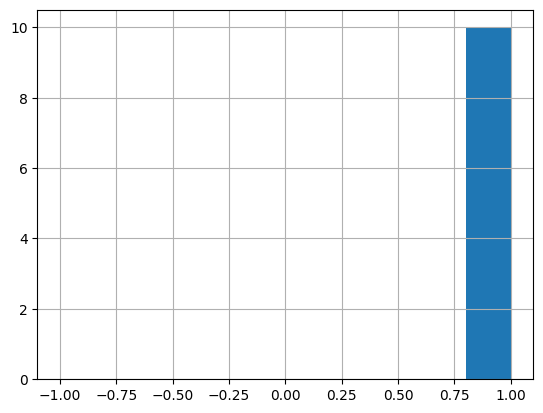

In [25]:
spearman_pairwise['coef'].hist(range=[-1, 1])

<Axes: >

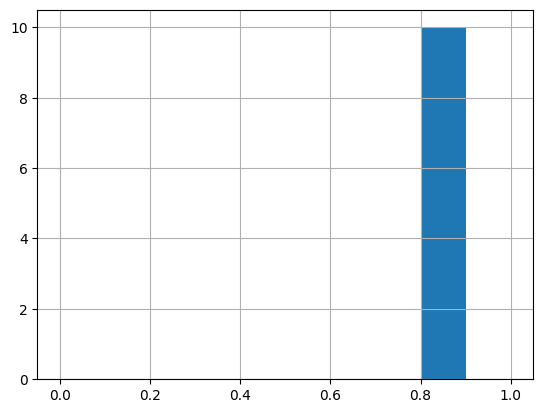

In [26]:
abs(spearman_pairwise['coef']).hist(range=[0, 1])

In [27]:
# filter for effect
df_no_effect = spearman_pairwise[abs(spearman_pairwise['coef'])<0.01]
df_very_small = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.01]
df_very_small = df_very_small[abs(df_very_small['coef'])<0.1]
df_effect = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.1]
print('\nNumber of analyte pairs whose effect size is at least weak: '.format(str(df_effect.shape[0])))


# evaluate effect size - cohen's d
df_small = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.1]
df_small = df_small[abs(df_small['coef'])<0.2]
df_medium = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.2]
df_medium  = df_medium[abs(df_medium['coef'])<0.3]
df_medium_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.3]
df_medium_large = df_medium_large[abs(df_medium_large['coef'])<0.5]
df_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.5]
df_large = df_large[abs(df_large['coef'])<0.7]
df_very_large = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.7]
df_very_large = df_very_large[abs(df_very_large['coef'])<0.9]
df_huge = spearman_pairwise[abs(spearman_pairwise['coef'])>=0.9]

# print info on effect sizes
print('Number of Analyte Pairs with No Monotonic Relationship: {}'.format(str(df_no_effect.shape[0])))
print('Number of Analyte Pairs with Very Weak Monotonic Relationship: {}'.format(str(df_very_small.shape[0])))
print('Number of Analyte Pairs with Weak Monotonic Relationship: {}'.format(str(df_small.shape[0])))
print('Number of Analyte Pairs with Moderate Monotonic Relationship: {}'.format(str(df_medium.shape[0])))
print('Number of Analyte Pairs with Moderate Strong Monotonic Relationship: {}'.format(str(df_medium_large.shape[0])))
print('Number of Analyte Pairs with Strong Monotonic Relationship: {}'.format(str(df_large.shape[0])))
print('Number of Analyte Pairs with Very Strong Monotonic Relationship: {}'.format(str(df_very_large.shape[0])))
print('Number of Analyte Pairs with Near Perfect Monotonic Relationship: {}'.format(str(df_huge.shape[0])))


Number of analyte pairs whose effect size is at least weak: 
Number of Analyte Pairs with No Monotonic Relationship: 0
Number of Analyte Pairs with Very Weak Monotonic Relationship: 0
Number of Analyte Pairs with Weak Monotonic Relationship: 0
Number of Analyte Pairs with Moderate Monotonic Relationship: 0
Number of Analyte Pairs with Moderate Strong Monotonic Relationship: 0
Number of Analyte Pairs with Strong Monotonic Relationship: 0
Number of Analyte Pairs with Very Strong Monotonic Relationship: 10
Number of Analyte Pairs with Near Perfect Monotonic Relationship: 0
